# Developing a Women's Pro Hockey Expected Goals (xG) Model

#### Brian Johns, February 2026

## Notebook #3: Modelling

In notebook #2, I conducted exploratory data analysis and feature engineering in order to prepare the data for modelling.  Here I will explore different classification models to predict the probability of whether shots will be goals which will be the foundation of the xG model.  I will evaluate the models using Log Loss and AUC to pick the most accurate method to build the xG model.

In this notebook, I will do the following:

1. [Load Data and Set-Up](#loading)
2. [Logistic Regression Modelling](#logreg)
3. [XGBoost Modelling](#xgboost)
4. [Modelling Part 1 Summary](#summary)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (accuracy_score, log_loss, classification_report,
                              confusion_matrix, roc_auc_score, roc_curve,
                              precision_recall_curve, average_precision_score)
from sklearn.calibration import calibration_curve
from xgboost import plot_importance
import warnings

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
PWHL = {
    "purple":    "#6B3FA0",
    "purple_lt": "#9B6FD0",
    "purple_dk": "#3D1F6B",
    "gold":      "#C4952A",
    "goal_red":  "#C0394A",
    "silver":    "#4A4460",
    "muted":     "#C8C2D8",
    "bg":        "#EDEAF2",
    "bg2":       "#F7F5FA",
    "white":     "#FFFFFF",
}

def pwhl_theme():
    """Apply PWHL seaborn theme globally."""
    sns.set_theme(style="whitegrid", rc={
        "axes.facecolor":    PWHL["bg2"],
        "figure.facecolor":  PWHL["bg"],
        "axes.edgecolor":    PWHL["muted"],
        "axes.labelcolor":   PWHL["silver"],
        "grid.color":        PWHL["muted"],
        "grid.linewidth":    0.6,
        "xtick.color":       PWHL["silver"],
        "ytick.color":       PWHL["silver"],
        "text.color":        PWHL["silver"],
        "font.family":       "monospace",
        "axes.spines.top":   False,
        "axes.spines.right": False,
    })

<a id = 'loading'></a>

## 1. Load Data and Set-Up

In [3]:
df = pd.read_csv('model_data.csv')

In [4]:
y = df['is_goal']
X = df.drop(['is_goal'], axis = 1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=29,
                                                    stratify=y)

In [6]:
X_train.head(3)

home_team_skaters  away_team_skaters  period_1  period_2  period_3  \
9170                   5                  5         0         0         1   
10828                  5                  5         1         0         0   
8187                   5                  5         1         0         0   

       game_time       x_ft       y_ft      y_abs  dist_ft  angle_deg  \
9170      2802.0  65.000000 -13.271930  13.271930     27.4       28.9   
10828       94.0  60.333333   8.201754   8.201754     29.8       16.0   
8187       356.0  64.666667  16.552632  16.552632     29.4       34.2   

       arclength  shooter_quality  shooter_career_quality  goalie_save_pct  \
9170   13.820564         0.135942                0.141337         0.929026   
10828   8.321730         0.068236                0.076763         0.920099   
8187   17.548937         0.095811                0.108626         0.930239   

       goalie_career_save_pct  home_score  away_score  goal_diff  losing  \
9170                 0.919168           1           1          0       0   
10828                0.919168           0           0          0       0   
8187                 0.928881           0           0          0       0   

       tied  winning  skater_diff  es  pp  sh  rebound  backhand  other  slap  \
9170      1        0            0   1   0   0        0         0      0     0   
10828     1        0            0   1   0   0        0         0      0     0   
8187      1        0            0   1   0   0        0         0      0     0   

       snap  tip  wrist  slot  close_game  late_game  is_forward  pwhl  
9170      0    0      1     1           1          0           1     1  
10828     1    0      0     1           1          0           1     1  
8187      0    0      1     0           1          0           1     1

In [7]:
X_test.head(3)

home_team_skaters  away_team_skaters  period_1  period_2  period_3  \
5445                   5                  5         0         1         0   
3246                   4                  5         0         1         0   
12858                  5                  5         0         1         0   

       game_time       x_ft       y_ft      y_abs  dist_ft  angle_deg  \
5445      2330.0  63.666667  -1.640351   1.640351     25.4        3.7   
3246      1927.0  63.333333   9.096491   9.096491     27.2       19.5   
12858     1526.0  61.000000  18.938596  18.938596     33.8       34.1   

       arclength  shooter_quality  shooter_career_quality  goalie_save_pct  \
5445    1.640260         0.099041                0.126054         0.914014   
3246    9.257226         0.073142                0.076763         0.912353   
12858  20.116316         0.087013                0.075523         0.909116   

       goalie_career_save_pct  home_score  away_score  goal_diff  losing  \
5445                 0.920784           3           0         -3       1   
3246                 0.920784           1           1          0       0   
12858                0.911145           0           0          0       0   

       tied  winning  skater_diff  es  pp  sh  rebound  backhand  other  slap  \
5445      0        0            0   1   0   0        0         0      1     0   
3246      1        0            1   0   1   0        0         0      0     0   
12858     1        0            0   1   0   0        0         0      0     0   

       snap  tip  wrist  slot  close_game  late_game  is_forward  pwhl  
5445      0    0      0     1           0          0           1     1  
3246      1    0      0     1           1          0           1     1  
12858     0    0      1     0           1          0           0     1

In [8]:
y_train[:3]

9170     0
10828    0
8187     0
Name: is_goal, dtype: int64

In [9]:
y_test[:3]

5445     0
3246     0
12858    0
Name: is_goal, dtype: int64

In preparation for modelling, it is already clear that scaling will be needed for some models.  With the majority of features being boolean (1's/0's) and a small number having continuous numbers (especially `game_time` going int the thousands), this is likely going to skew simpler models.

In [10]:
print(f"The Overall Save Percentage is {round(100-df['is_goal'].mean()*100, 2)}\n\
So guessing Save for EVERY shot would be at least this accurate.\n\
Our models should stay close to this throughout.")

The Overall Save Percentage is 91.87
So guessing Save for EVERY shot would be at least this accurate.
Our models should stay close to this throughout.


I'll use the following to help with model evaluation.  This will help us visualize the effectiveness of the model, along with its overall accuracy.  We will primarily be looking at **AUC** and **Log Loss** when evaluating the quality of the models.

In [11]:
eval_list = []

def model_eval(model, X_test, y_test, model_name="Model", threshold=0.5):
    pwhl_theme()
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred       = (y_pred_proba >= threshold).astype(int)

    model_accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, _    = roc_curve(y_test, y_pred_proba)
    auc            = roc_auc_score(y_test, y_pred_proba)
    loss           = log_loss(y_test, y_pred_proba)
    ap             = average_precision_score(y_test, y_pred_proba)

    eval_list.append({
        'model':    model_name,
        'accuracy': round(model_accuracy, 4),
        'auc':      round(auc, 4),
        'log_loss': round(loss, 4),
        'avg_prec': round(ap, 4),
    })

    # --- Print summary ---
    baseline = round(100 - (df['is_goal'].mean() * 100), 2)
    print(f"\n{'='*40}")
    print(f"  {model_name}")
    print(f"{'='*40}")
    print(f"  Baseline (always predict save): {baseline}%")
    print(f"  Accuracy:                       {round(model_accuracy*100, 2)}%")
    print(f"  AUC:                            {round(auc, 3)}")
    print(f"  Log Loss:                       {round(loss, 3)}")
    print(f"  Avg Precision (PR-AUC):         {round(ap, 3)}")
    print(f"\n{classification_report(y_test, y_pred, target_names=['Save', 'Goal'])}")

    fig, axes = plt.subplots(1, 3, figsize=(24, 8), facecolor=PWHL["bg"])

    TITLE_FS  = 20
    LABEL_FS  = 16
    TICK_FS   = 12
    LEGEND_FS = 12
    ANNOT_FS  = 16

    # --- Confusion matrix ---
    ax = axes[0]
    cm = confusion_matrix(y_test, y_pred)
    purple_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "pwhl_purple", [PWHL["bg2"], PWHL["purple_lt"], PWHL["purple_dk"]]
    )
    sns.heatmap(cm, annot=True, fmt='d', cmap=purple_cmap, ax=ax,
                linewidths=0.5, linecolor=PWHL["muted"],
                xticklabels=['Save', 'Goal'],
                yticklabels=['Save', 'Goal'],
                annot_kws={"size": ANNOT_FS, "weight": "bold", "color": PWHL["gold"]})
    ax.set_facecolor(PWHL["bg2"])
    ax.set_xlabel("Predicted", color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_ylabel("Actual",    color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_title("Confusion Matrix", color=PWHL["purple_dk"],
                 fontfamily="monospace", fontweight="bold", fontsize=TITLE_FS)
    ax.tick_params(colors=PWHL["silver"], labelsize=TICK_FS)

    # --- ROC curve ---
    ax = axes[1]
    ax.set_facecolor(PWHL["bg2"])
    ax.plot(fpr, tpr, color=PWHL["purple"], linewidth=2.5,
            label=f"AUC = {round(auc, 3)}")
    ax.plot([0, 1], [0, 1], color=PWHL["muted"], linewidth=1,
            linestyle="--", label="Random")
    ax.set_xlabel("False Positive Rate", color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_ylabel("True Positive Rate",  color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_title("ROC Curve", color=PWHL["purple_dk"],
                 fontfamily="monospace", fontweight="bold", fontsize=TITLE_FS)
    ax.legend(facecolor=PWHL["white"], edgecolor=PWHL["muted"],
              labelcolor=PWHL["silver"], fontsize=LEGEND_FS)
    ax.tick_params(colors=PWHL["silver"], labelsize=TICK_FS)

    # --- Calibration plot ---
    ax = axes[2]
    ax.set_facecolor(PWHL["bg2"])
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
    ax.plot(prob_pred, prob_true, color=PWHL["purple"], linewidth=2.5,
            marker="o", markersize=6, label=model_name)
    ax.plot([0, 1], [0, 1], color=PWHL["gold"], linewidth=1.5,
            linestyle="--", label="Perfect calibration")
    ax.set_xlabel("Mean Predicted Probability", color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_ylabel("Fraction of Positives",      color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_title("Calibration Plot", color=PWHL["purple_dk"],
                 fontfamily="monospace", fontweight="bold", fontsize=TITLE_FS)
    ax.legend(facecolor=PWHL["white"], edgecolor=PWHL["muted"],
              labelcolor=PWHL["silver"], fontsize=LEGEND_FS)
    ax.tick_params(colors=PWHL["silver"], labelsize=TICK_FS)

    fig.suptitle(model_name, color=PWHL["purple_dk"],
                 fontfamily="monospace", fontsize=24, fontweight="bold", y=1.02)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.tight_layout()

    display(fig)
    plt.close(fig)

<a id = 'logreg'></a>

## 2. Logistic Regression Modelling

In [12]:
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



  Base Logistic Regression
  Baseline (always predict save): 91.87%
  Accuracy:                       91.85%
  AUC:                            0.748
  Log Loss:                       0.252
  Avg Precision (PR-AUC):         0.199

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.00      0.00      0.00       271

    accuracy                           0.92      3338
   macro avg       0.46      0.50      0.48      3338
weighted avg       0.84      0.92      0.88      3338



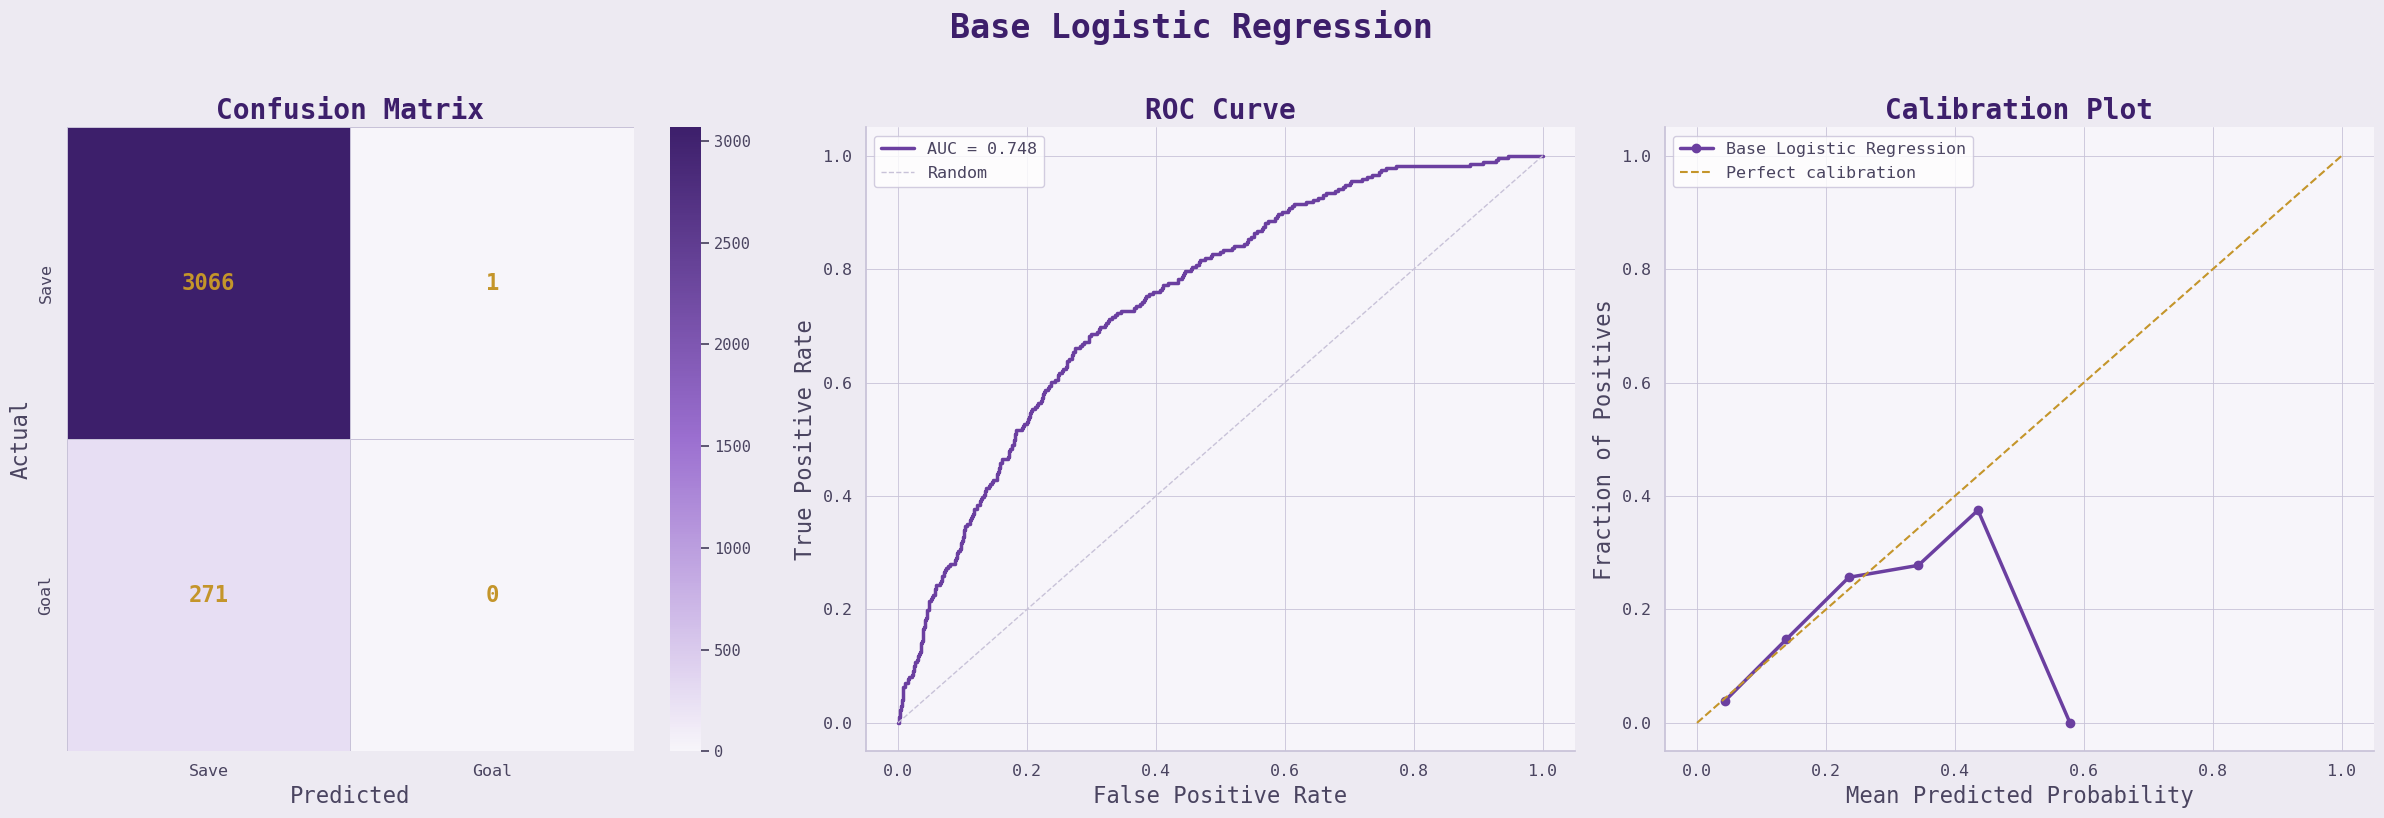

In [13]:
model_eval(logreg, X_test, y_test, "Base Logistic Regression")

Using all of the data, it's very clear that scaling will be needed.  I will try a more minimalist Logistic Regression based on the EDA performed in the previous notebook and see if there's anything that could be learned.  This will use only `x_ft`, `y_abs`, `rebound`, `slot`, `shooter_career_quality` and `goalie_career_save_pct`.

In [14]:
selected_cols = ['x_ft', 'y_abs', 'rebound', 'slot', 'shooter_career_quality', 'goalie_career_save_pct']

In [15]:
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(X_train[selected_cols], y_train)
y_pred = logreg.predict(X_test[selected_cols])


  Selected Logistic Regression
  Baseline (always predict save): 91.87%
  Accuracy:                       91.88%
  AUC:                            0.715
  Log Loss:                       0.26
  Avg Precision (PR-AUC):         0.185

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.00      0.00      0.00       271

    accuracy                           0.92      3338
   macro avg       0.46      0.50      0.48      3338
weighted avg       0.84      0.92      0.88      3338



/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

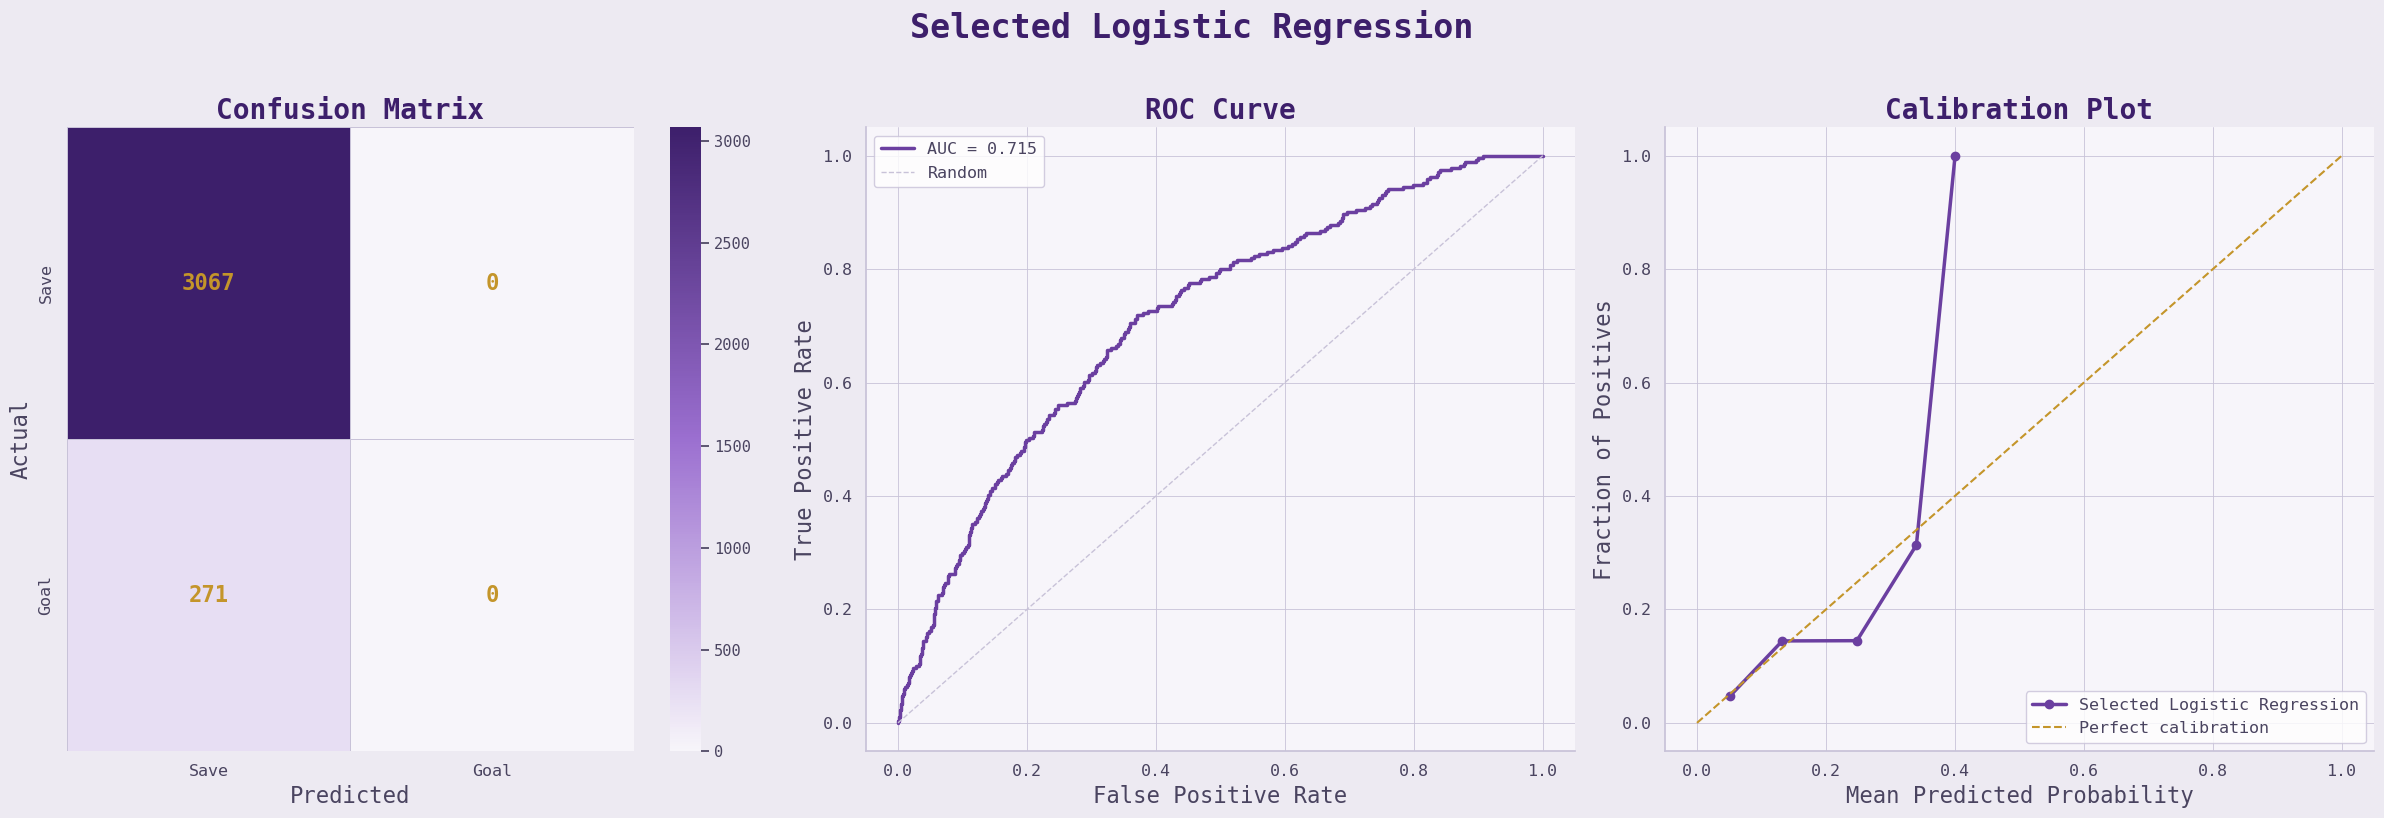

In [16]:
model_eval(logreg, X_test[selected_cols], y_test, "Selected Logistic Regression")

Both models essentially just guessed 'Save' for everything, so it is clear that scaling will be required to get a more meaningful model.

I am going to separate the continuous numerical columns and the boolean columns and experiment with using different scalers on the full dataset first, then on the selected features after.

Here we are going to make some adjustments to the features.
`home_team_skaters` and `away_team_skaters` are both captured by `skater_diff` and the different strength states, so we will not use them from here on out.

We'll keep all of the positional data (`x_ft`, `y_abs` and `angle_deg`) along with `arc_length` because it could be the case that one side is more accurate than the other, but for most modelling I will likely not include `arc_length` unless to simplify the model, but it still needs to be scaled.



In [17]:
df.head(1)

home_team_skaters  away_team_skaters  period_1  period_2  period_3  \
0                  5                  5         1         0         0   

   game_time       x_ft       y_ft      y_abs  dist_ft  angle_deg  arclength  \
0  30.266666  75.142281  15.844118  15.844118     21.0       48.8  17.886134   

   shooter_quality  shooter_career_quality  goalie_save_pct  \
0         0.081256                0.061335         0.918744   

   goalie_career_save_pct  home_score  away_score  goal_diff  losing  tied  \
0                0.926386           0           0          0       0     1   

   winning  skater_diff  es  pp  sh  rebound  backhand  other  slap  snap  \
0        0            0   1   0   0        0         0      0     0     1   

   tip  wrist  slot  close_game  late_game  is_forward  pwhl  is_goal  
0    0      0     0           1          0           1     0        0

In [18]:
continuous_col = ['game_time','x_ft', 'y_ft', 'y_abs', 'dist_ft', 'angle_deg', 'arclength',
                  'shooter_quality', 'shooter_career_quality', 'goalie_save_pct', 'goalie_career_save_pct',
                  'home_score', 'away_score', 'goal_diff', 'skater_diff']

In [19]:
boolean_col = ['losing', 'tied', 'winning', 'es', 'pp', 'sh', 'rebound',
            'backhand', 'other', 'slap', 'snap', 'tip', 'wrist', 
            'slot', 'close_game', 'late_game', 'is_forward', 'pwhl']

In [20]:
X_train = X_train[continuous_col+boolean_col]
X_test = X_test[continuous_col+boolean_col]


  Log Reg — Full Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       91.91%
  AUC:                            0.774
  Log Loss:                       0.244
  Avg Precision (PR-AUC):         0.242

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.55      0.02      0.04       271

    accuracy                           0.92      3338
   macro avg       0.73      0.51      0.50      3338
weighted avg       0.89      0.92      0.88      3338



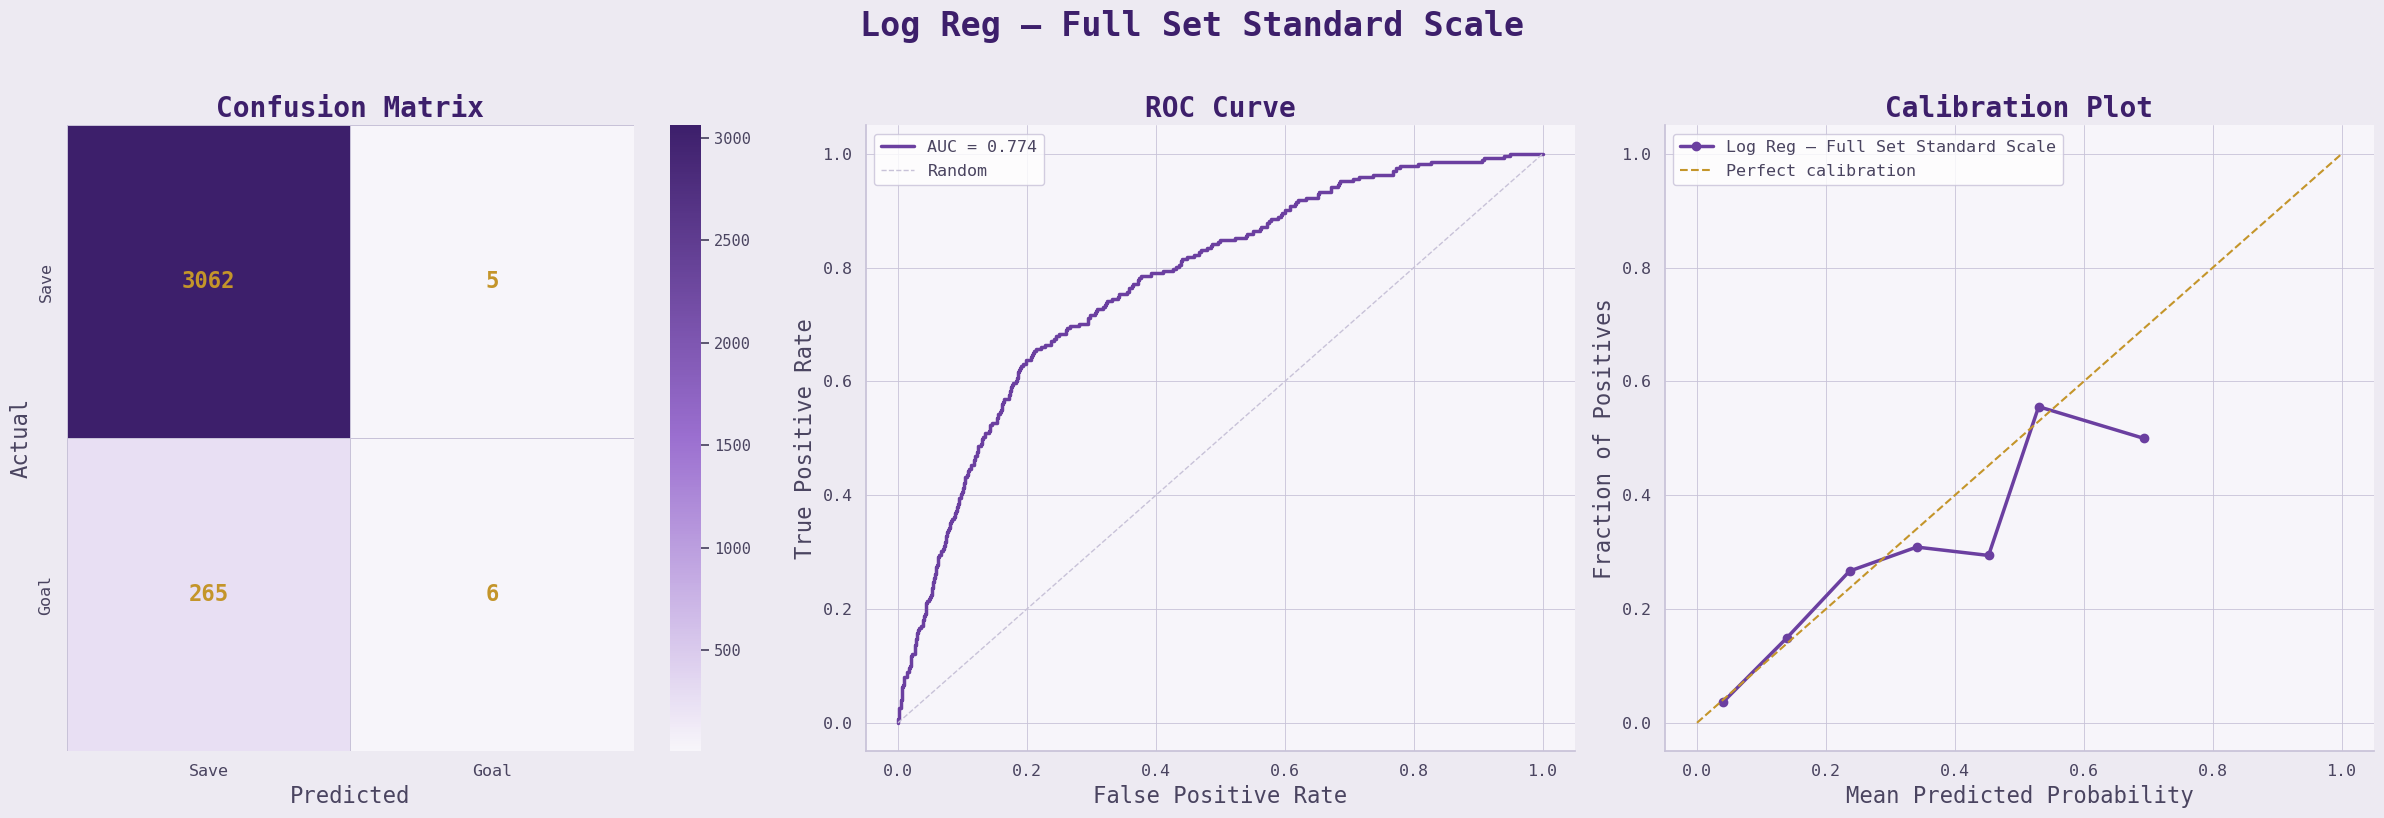

In [21]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(random_state=29))
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, model_name="Log Reg — Full Set Standard Scale")


  Log Reg - Full Set MinMax Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       91.85%
  AUC:                            0.771
  Log Loss:                       0.245
  Avg Precision (PR-AUC):         0.237

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.44      0.01      0.03       271

    accuracy                           0.92      3338
   macro avg       0.68      0.51      0.49      3338
weighted avg       0.88      0.92      0.88      3338



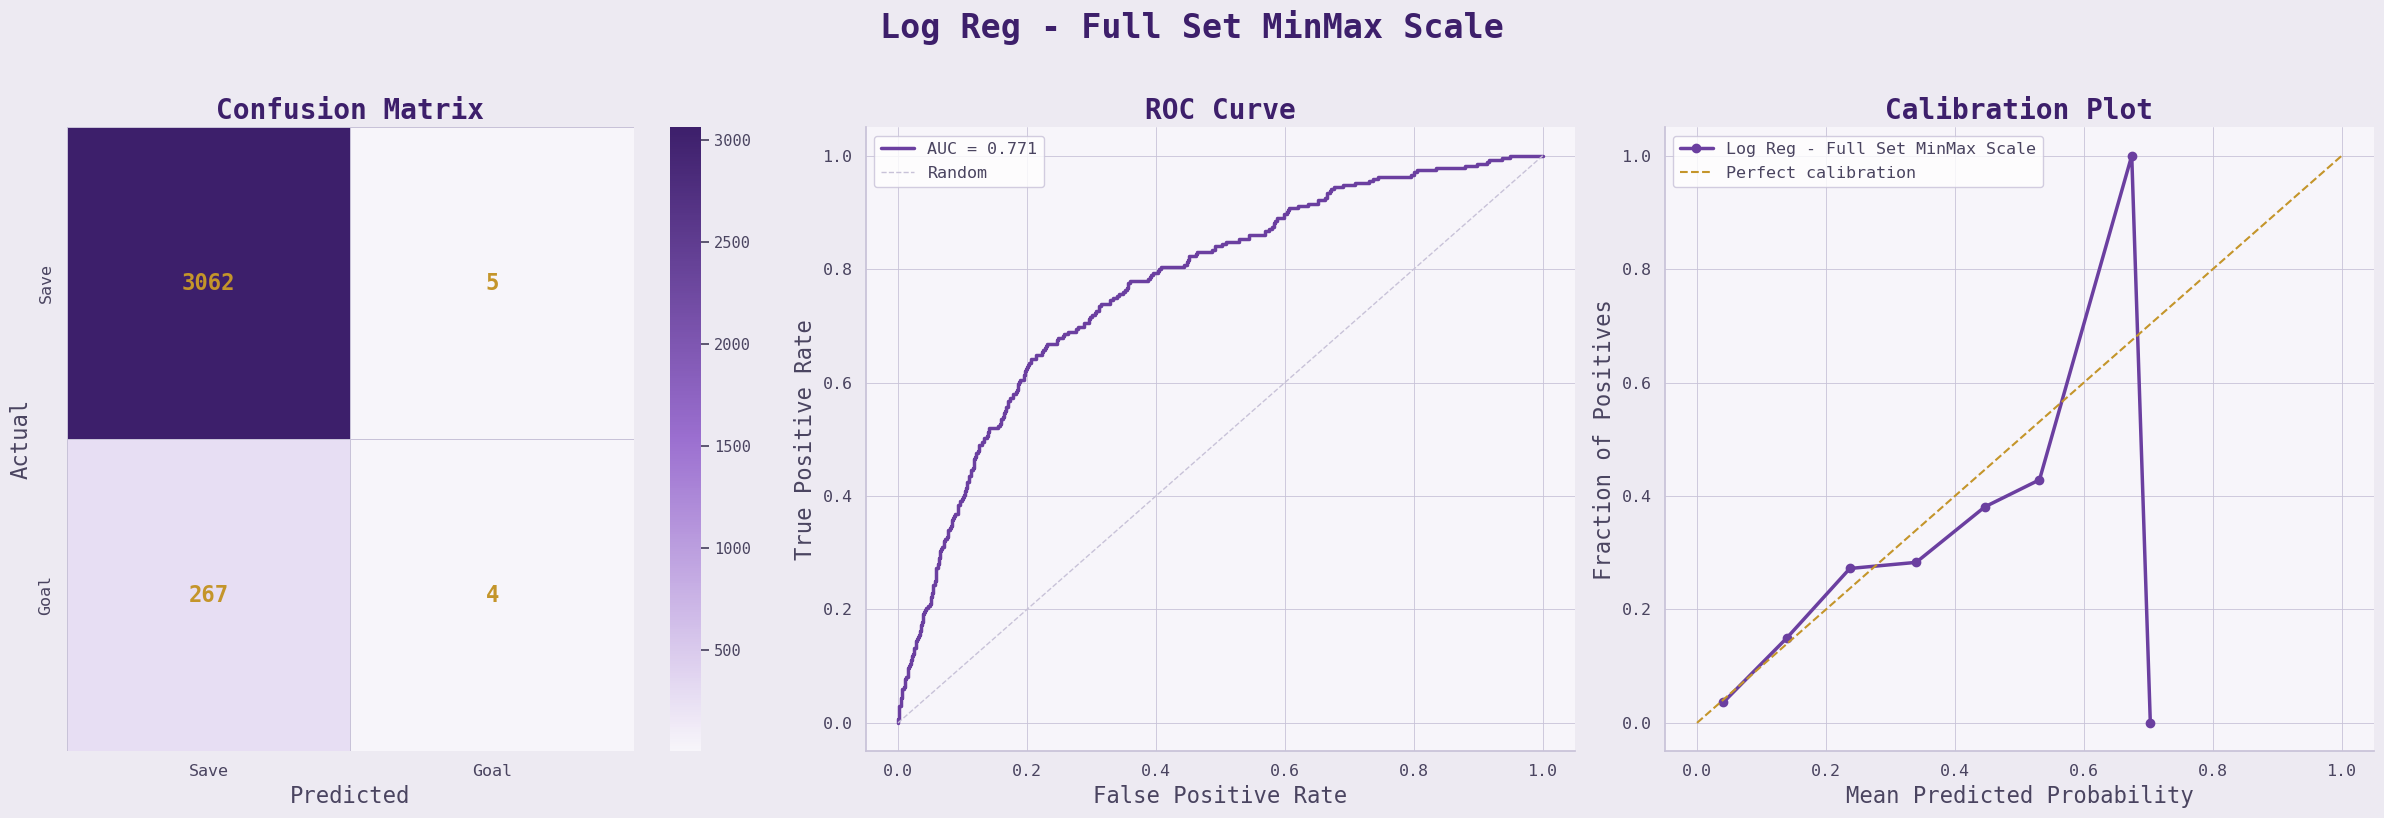

In [22]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(random_state=29))
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, "Log Reg - Full Set MinMax Scale")

In [23]:
continuous_col_sel = [c for c in continuous_col if c in selected_cols]
boolean_col_sel    = [c for c in boolean_col    if c in selected_cols]


  Selected Log Reg - Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       91.85%
  AUC:                            0.723
  Log Loss:                       0.258
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.33      0.00      0.01       271

    accuracy                           0.92      3338
   macro avg       0.63      0.50      0.48      3338
weighted avg       0.87      0.92      0.88      3338



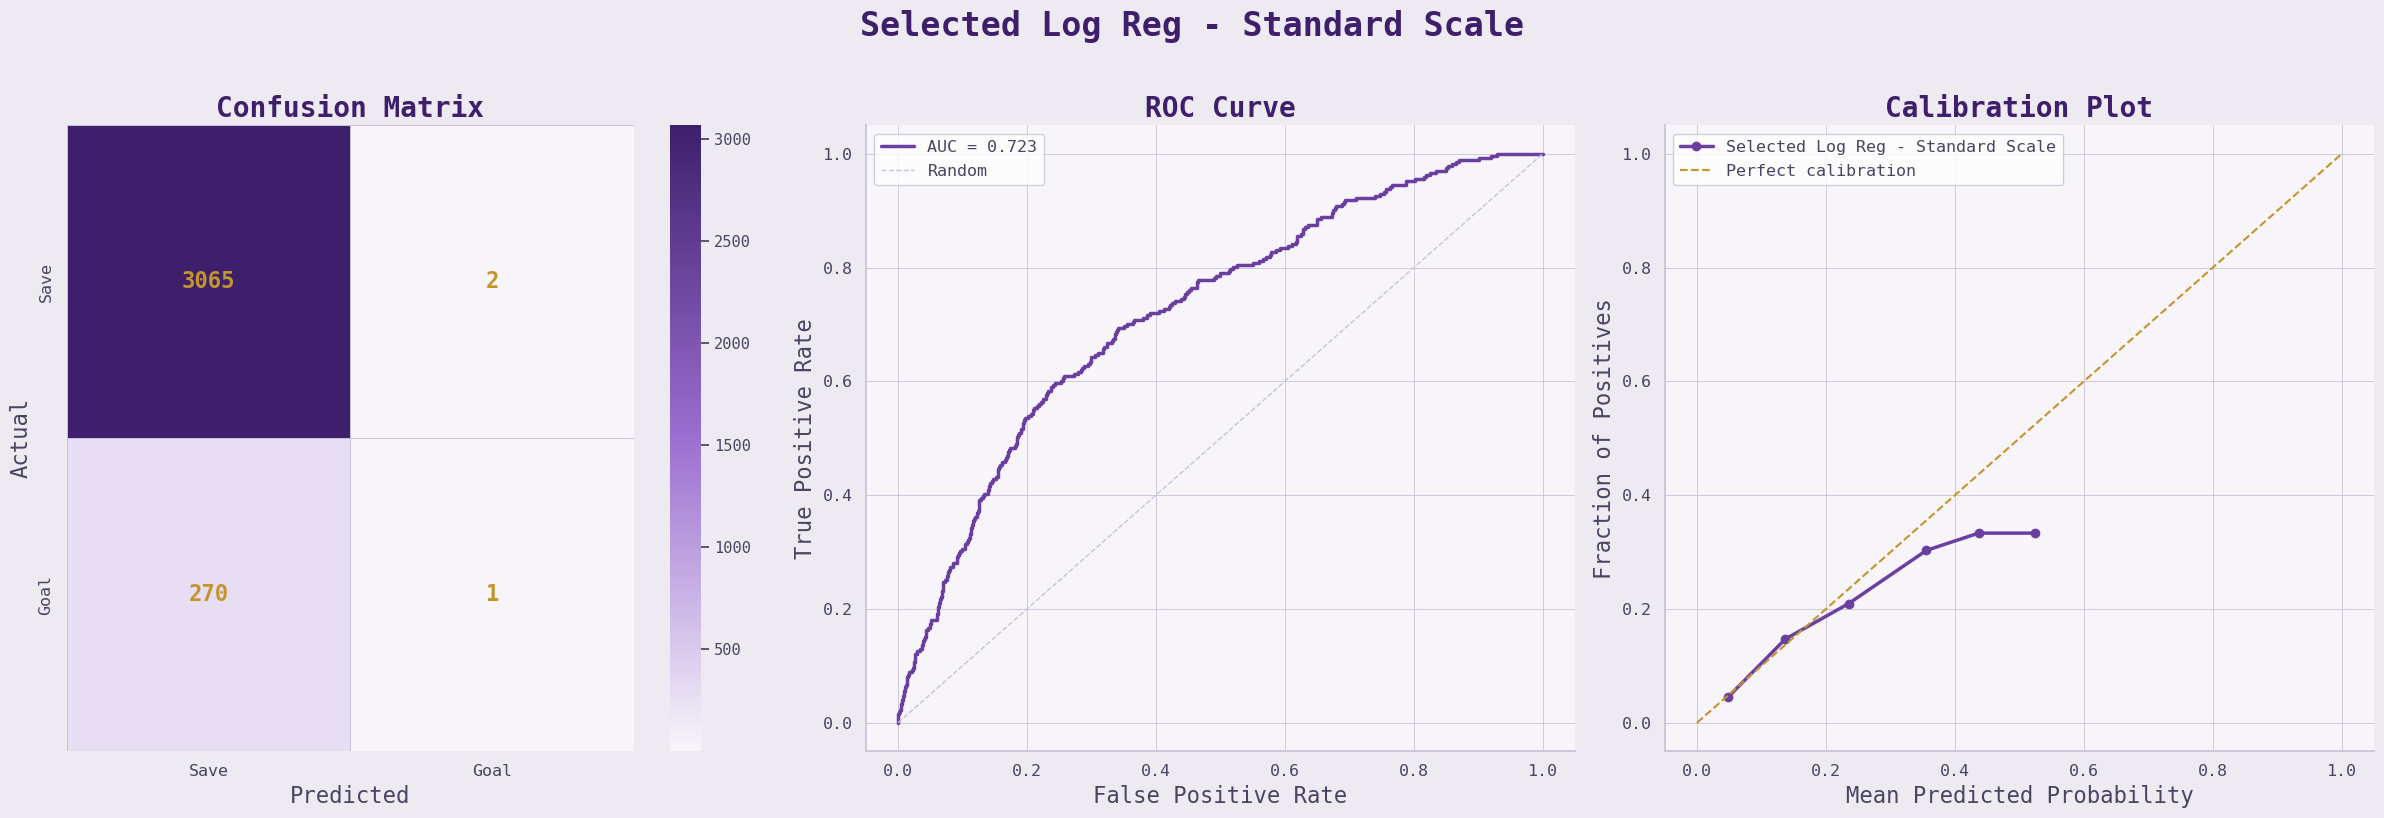

In [24]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(random_state=29))
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, "Selected Log Reg - Standard Scale")


  Selected Log Reg - MinMax Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       91.88%
  AUC:                            0.723
  Log Loss:                       0.258
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.50      0.00      0.01       271

    accuracy                           0.92      3338
   macro avg       0.71      0.50      0.48      3338
weighted avg       0.89      0.92      0.88      3338



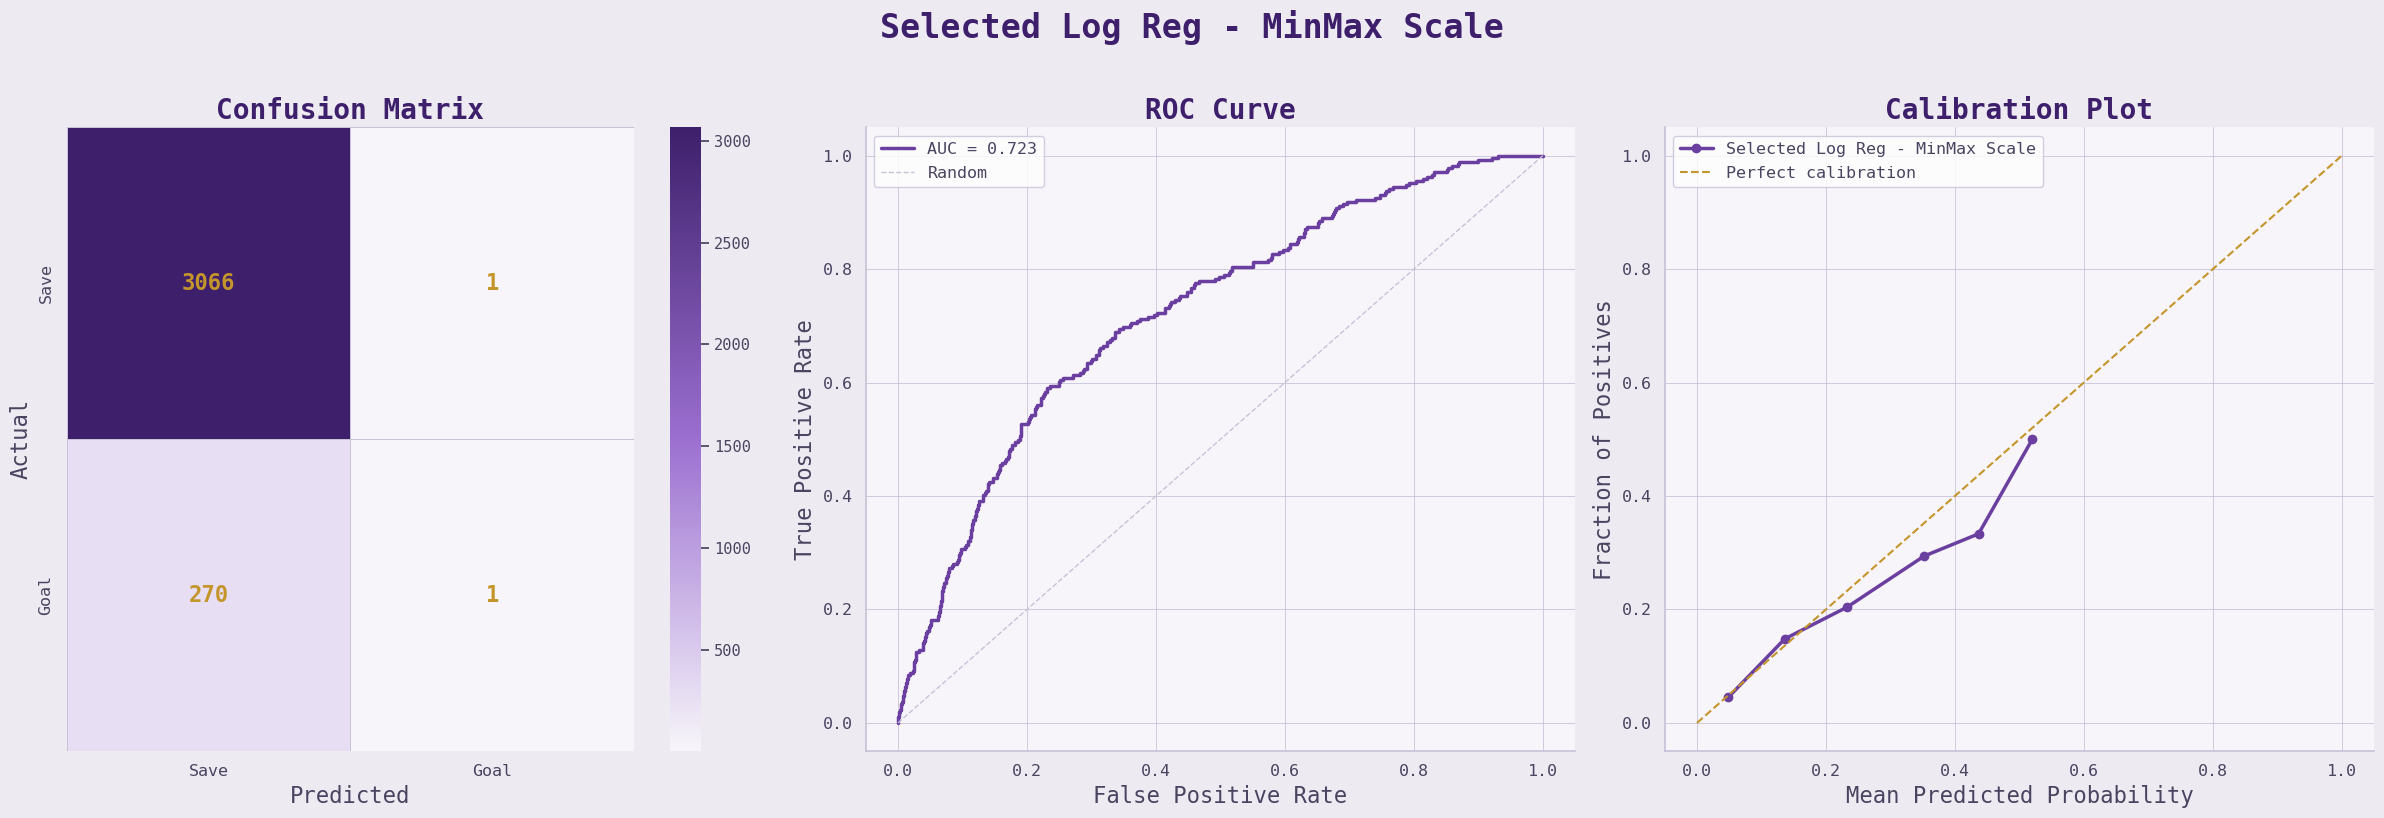

In [25]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(random_state=29))
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, "Selected Log Reg - MinMax Scale")

Unfortunately the scaling did not do much to improve the modelling.  Given that only 8% of shots go in, the next step will be to balance the data and see if that has an effect of the accuracy.

I will try to do this within the standard Logistic Regression, and if that does not yield better results I will apply SMOTE to the dataset and retry.


  Balanced Log Reg — Full Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       67.05%
  AUC:                            0.773
  Log Loss:                       0.576
  Avg Precision (PR-AUC):         0.236

              precision    recall  f1-score   support

        Save       0.97      0.66      0.79      3067
        Goal       0.16      0.73      0.27       271

    accuracy                           0.67      3338
   macro avg       0.56      0.70      0.53      3338
weighted avg       0.90      0.67      0.75      3338



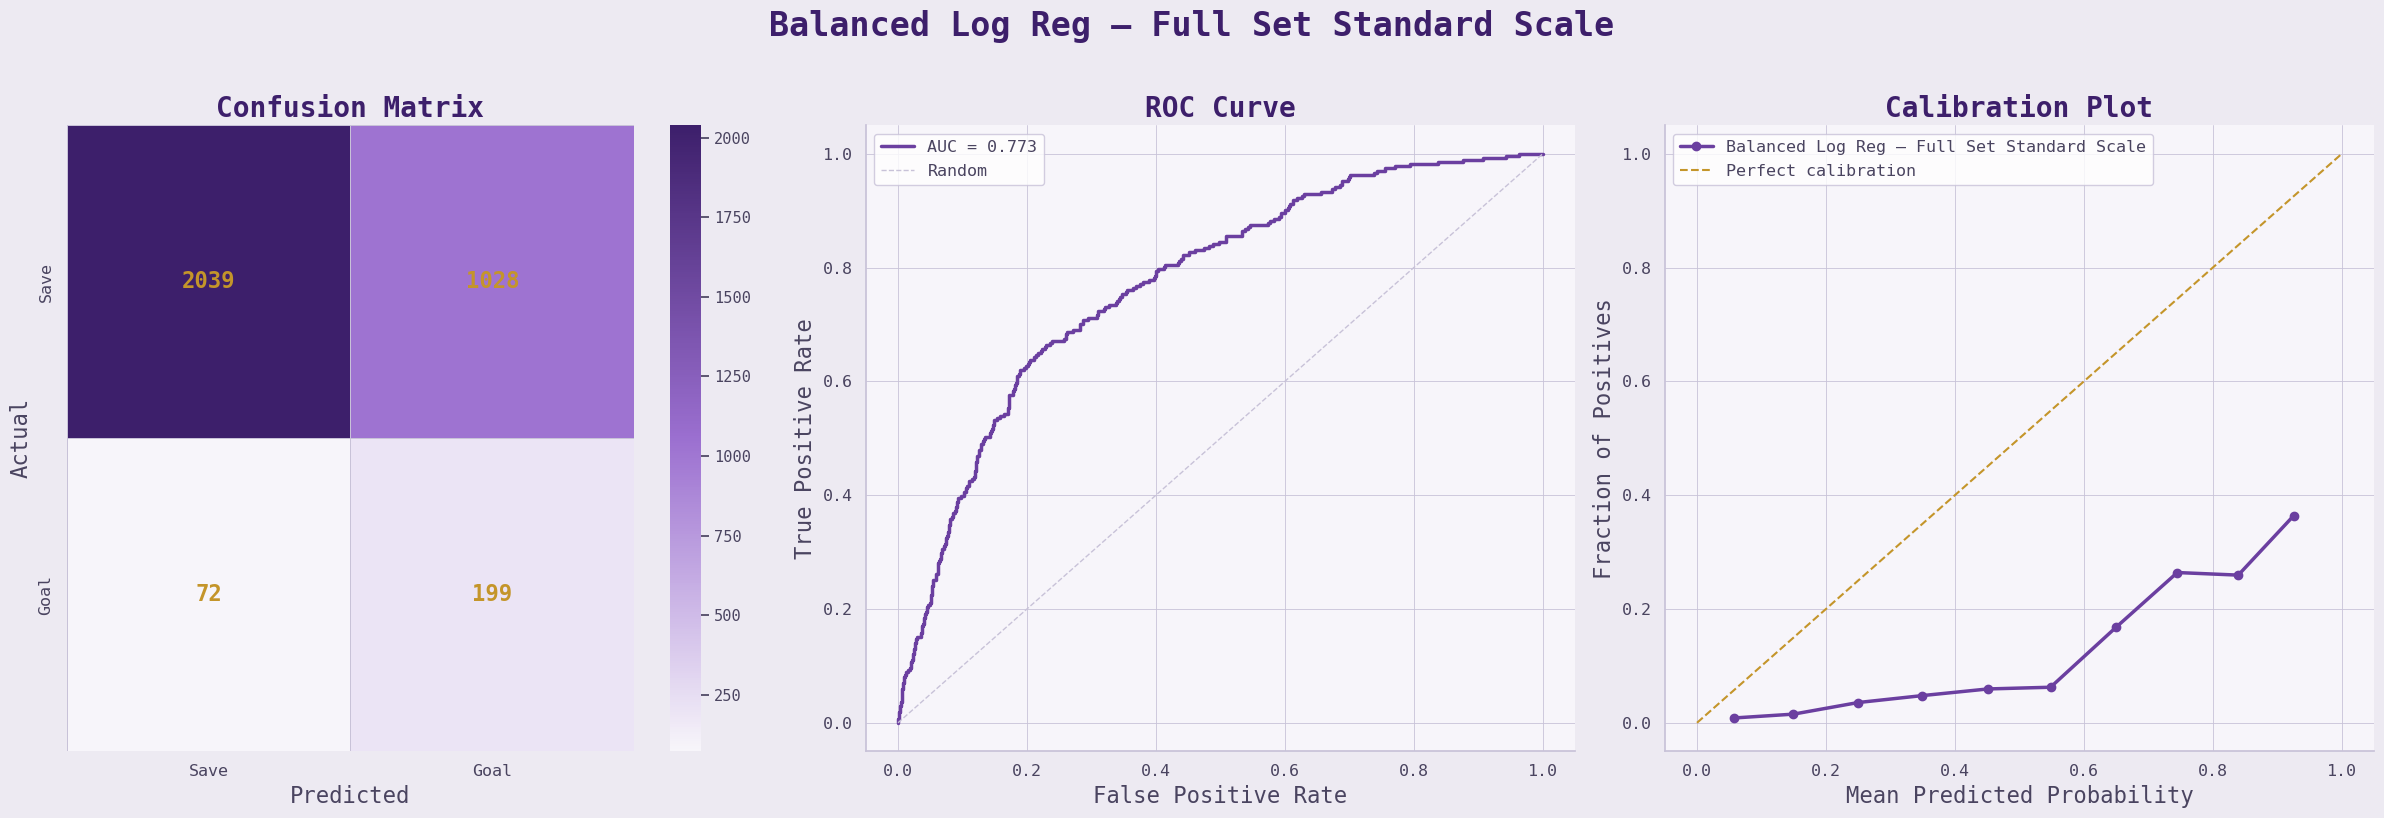

In [26]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(class_weight = 'balanced', random_state=29))
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, model_name="Balanced Log Reg — Full Set Standard Scale")


  Balanced Log Reg — Full Set MinMax Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       67.35%
  AUC:                            0.772
  Log Loss:                       0.577
  Avg Precision (PR-AUC):         0.235

              precision    recall  f1-score   support

        Save       0.97      0.67      0.79      3067
        Goal       0.16      0.74      0.27       271

    accuracy                           0.67      3338
   macro avg       0.57      0.70      0.53      3338
weighted avg       0.90      0.67      0.75      3338



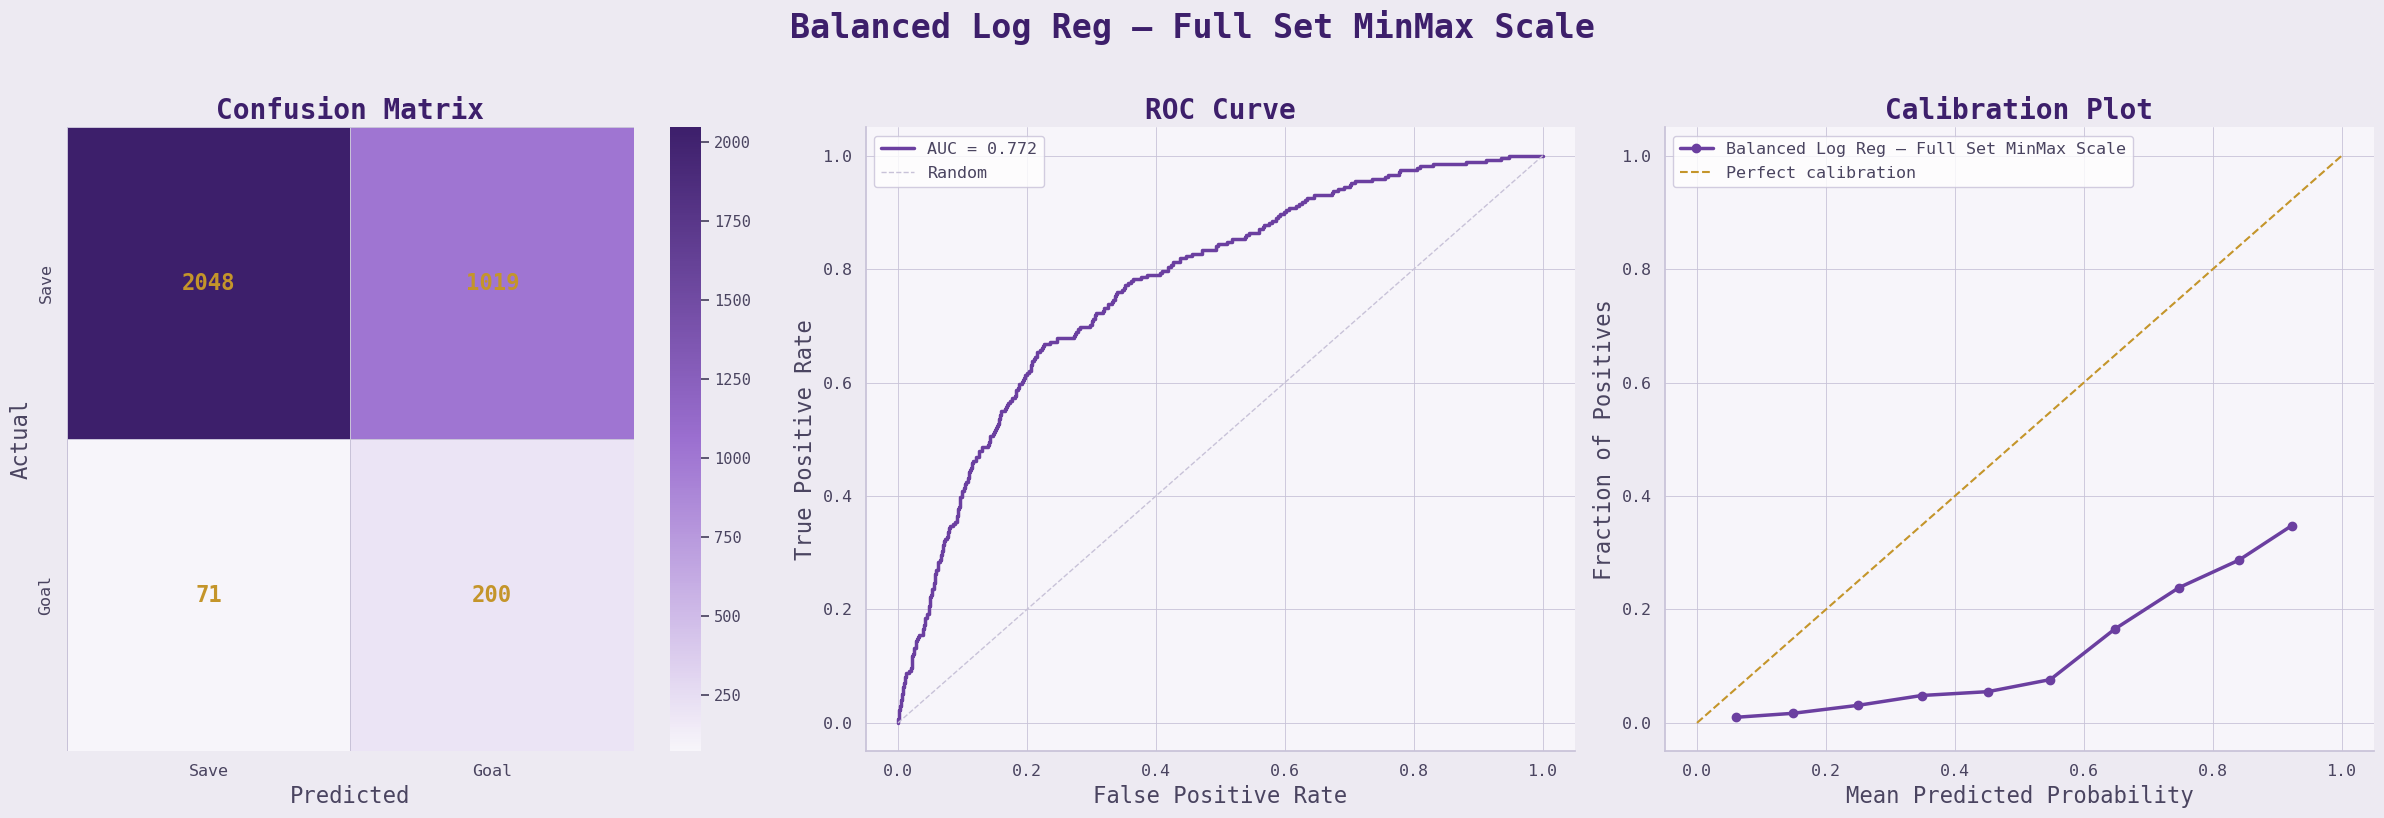

In [27]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(class_weight = 'balanced', random_state=29))
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, model_name="Balanced Log Reg — Full Set MinMax Scale")


  Balanced Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       63.18%
  AUC:                            0.721
  Log Loss:                       0.622
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.96      0.63      0.76      3067
        Goal       0.14      0.71      0.24       271

    accuracy                           0.63      3338
   macro avg       0.55      0.67      0.50      3338
weighted avg       0.89      0.63      0.72      3338



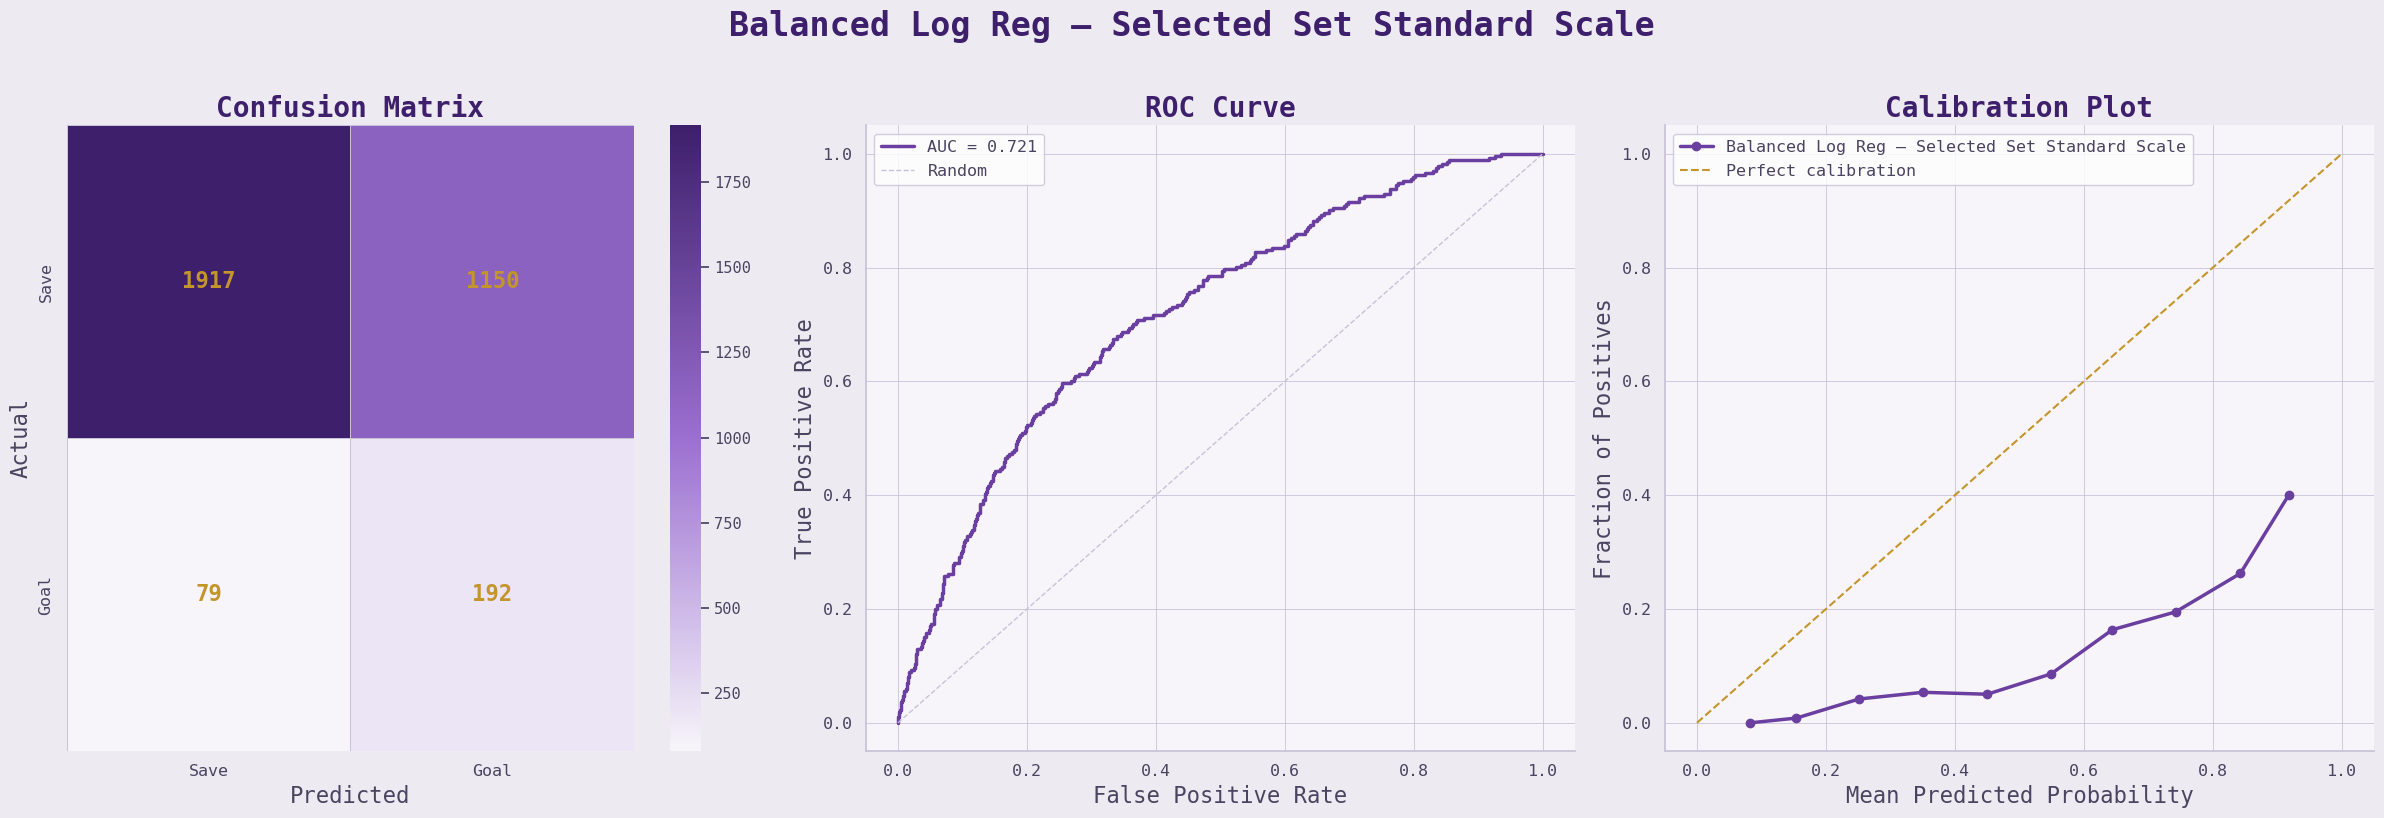

In [28]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(class_weight = 'balanced', random_state=29))
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, model_name="Balanced Log Reg — Selected Set Standard Scale")


  Balanced Log Reg — Selected Set MinMax Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       63.0%
  AUC:                            0.721
  Log Loss:                       0.622
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.96      0.62      0.76      3067
        Goal       0.14      0.71      0.24       271

    accuracy                           0.63      3338
   macro avg       0.55      0.67      0.50      3338
weighted avg       0.89      0.63      0.71      3338



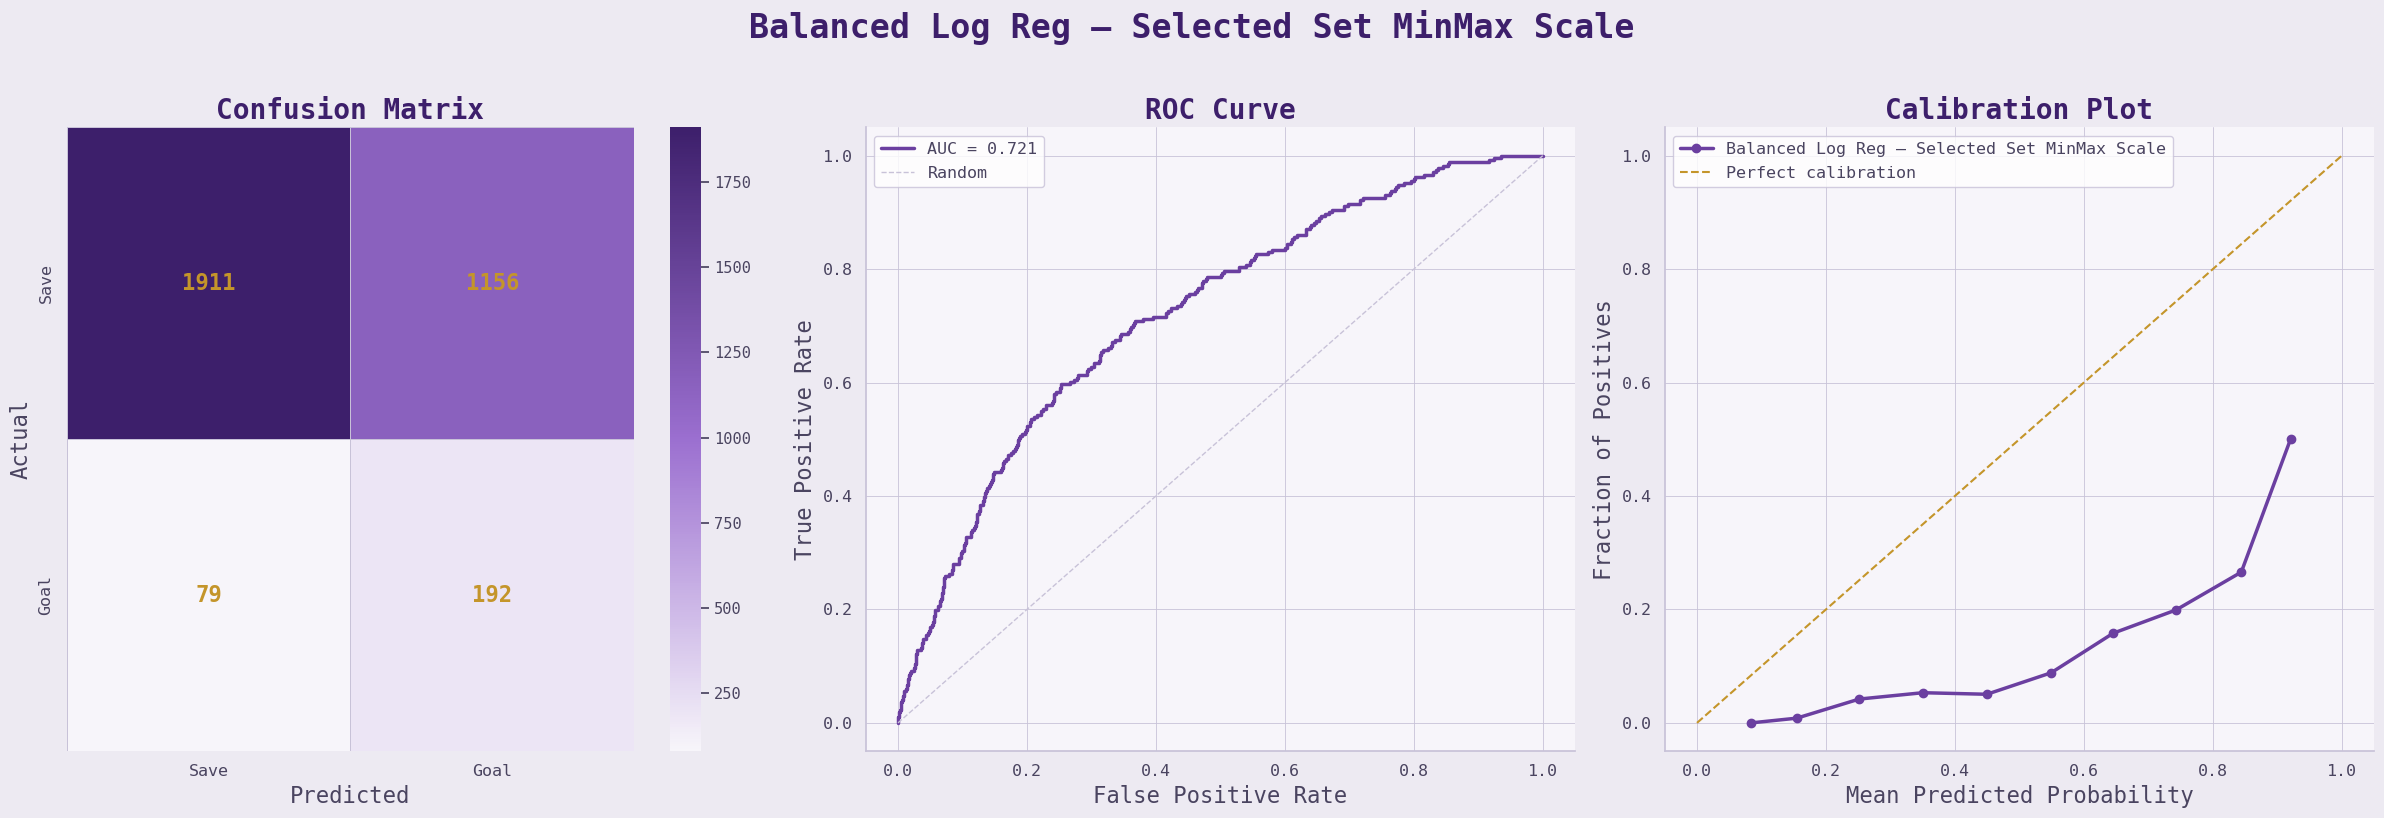

In [29]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(class_weight = 'balanced', random_state=29))
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, model_name="Balanced Log Reg — Selected Set MinMax Scale")

Unfortunately these models were not very successful either.  They at least started to predict goals, but significantly over-predicted them.  These models actually increased the precision on saves, but for an effective xG model, we want to have much better precision on Goals.  So now I will try to use SMOTE instead to balance the data.


  SMOTE Log Reg — Full Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       67.65%
  AUC:                            0.771
  Log Loss:                       0.571
  Avg Precision (PR-AUC):         0.234

              precision    recall  f1-score   support

        Save       0.97      0.67      0.79      3067
        Goal       0.17      0.74      0.27       271

    accuracy                           0.68      3338
   macro avg       0.57      0.71      0.53      3338
weighted avg       0.90      0.68      0.75      3338



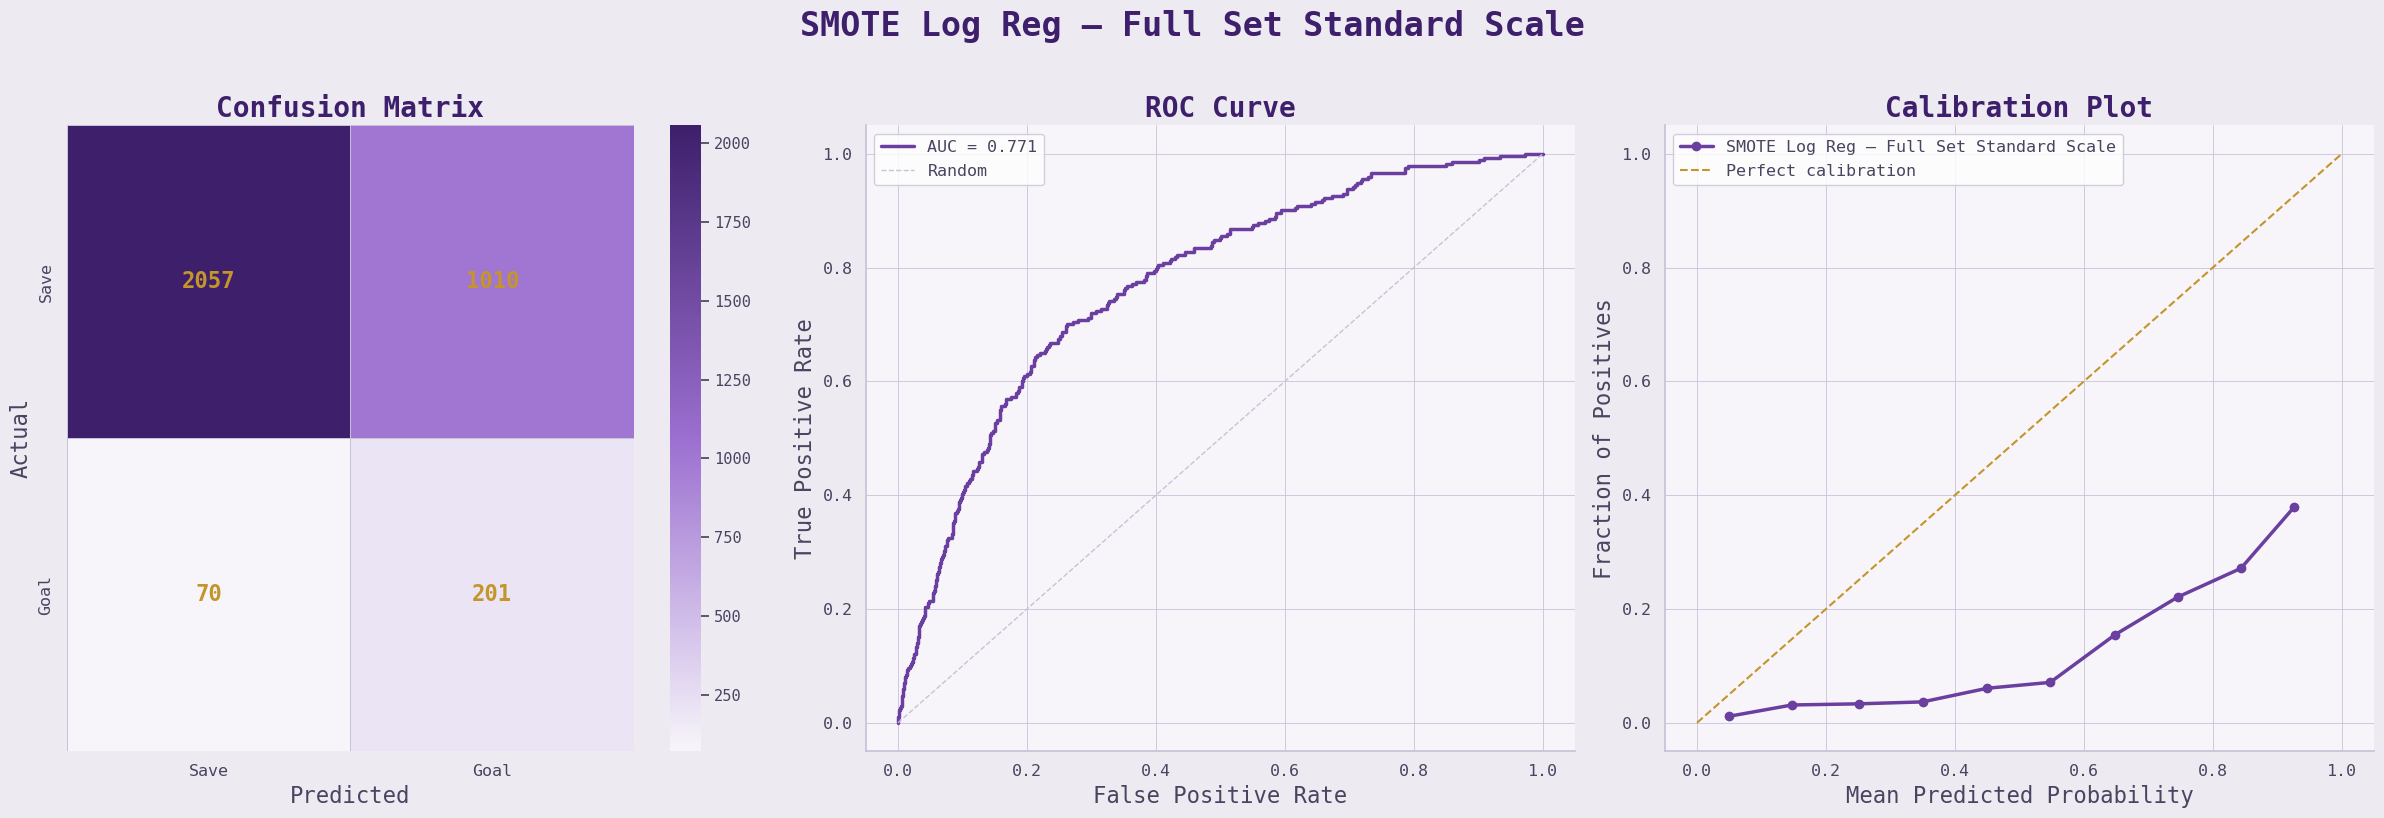

In [30]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote',        SMOTE(random_state=29)),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, model_name="SMOTE Log Reg — Full Set Standard Scale")


  SMOTE Log Reg — Full Set MinMax Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       67.62%
  AUC:                            0.772
  Log Loss:                       0.574
  Avg Precision (PR-AUC):         0.231

              precision    recall  f1-score   support

        Save       0.97      0.67      0.79      3067
        Goal       0.17      0.75      0.27       271

    accuracy                           0.68      3338
   macro avg       0.57      0.71      0.53      3338
weighted avg       0.90      0.68      0.75      3338



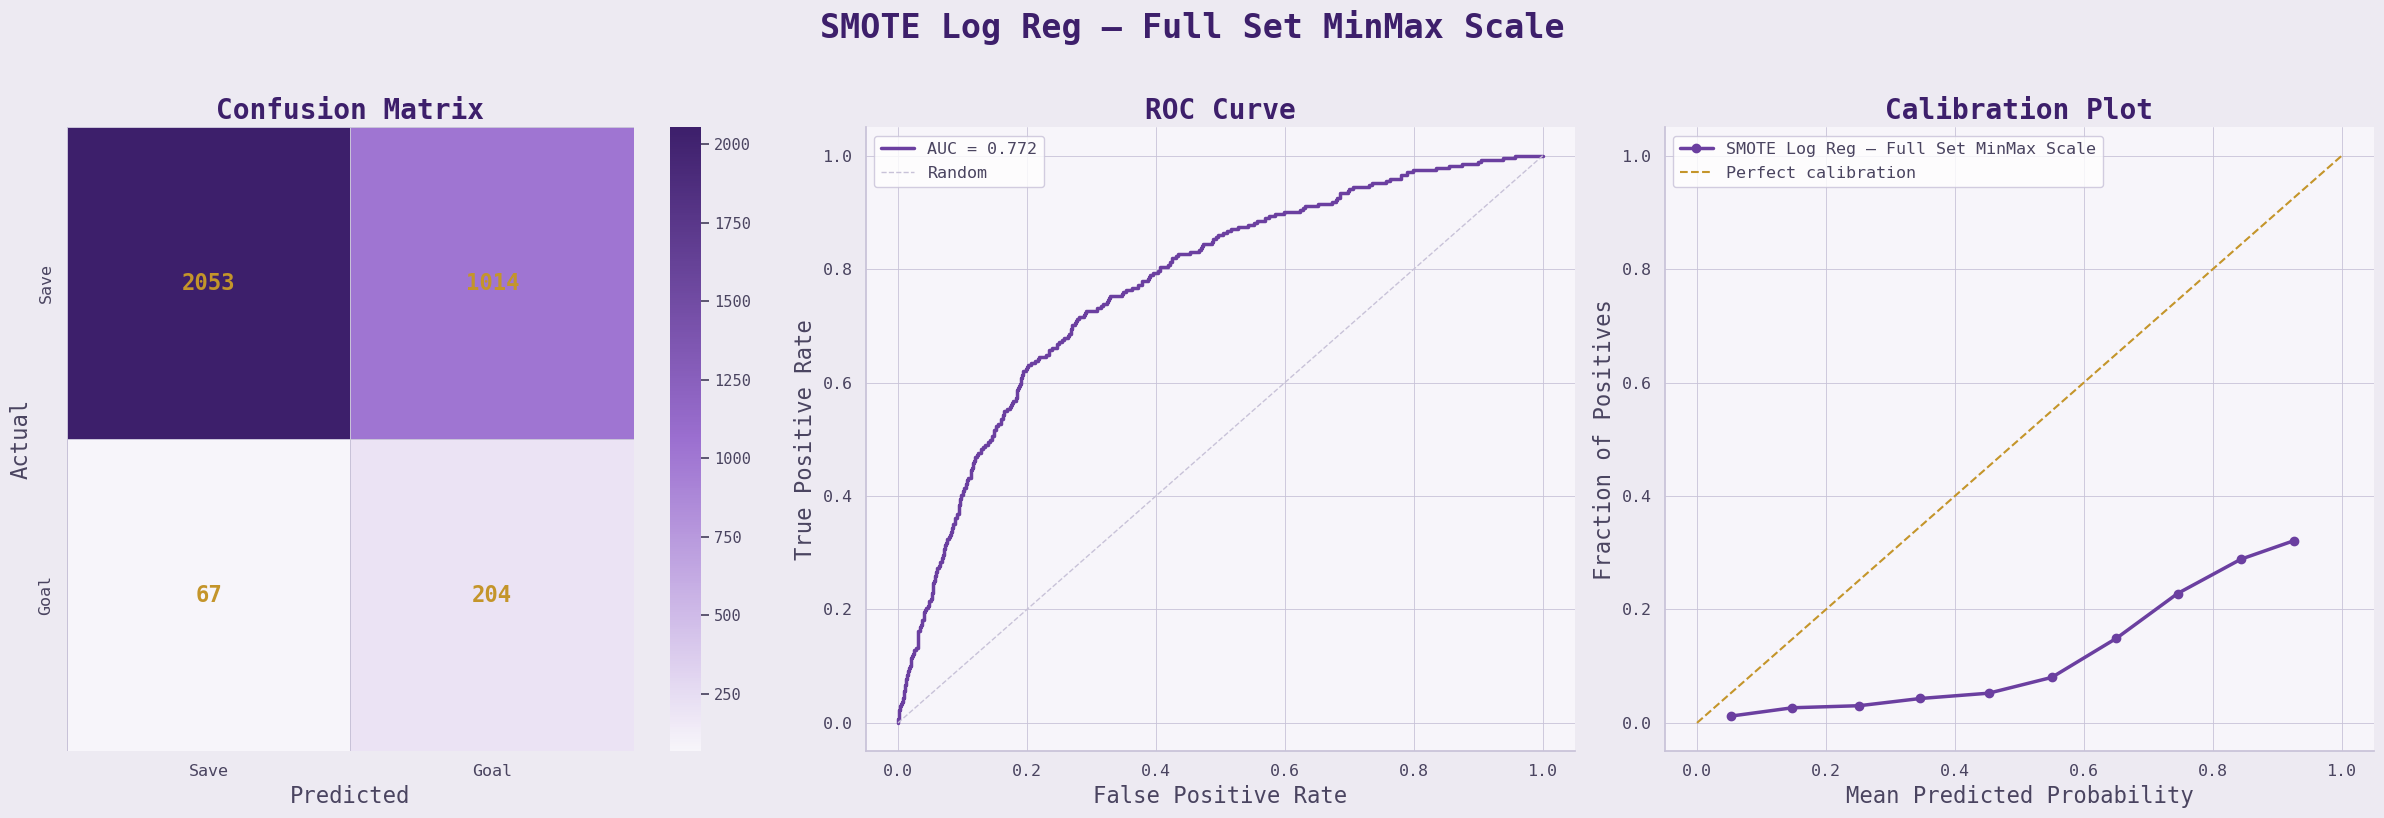

In [31]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote',        SMOTE(random_state=29)),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, model_name="SMOTE Log Reg — Full Set MinMax Scale")


  SMOTE Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       63.15%
  AUC:                            0.721
  Log Loss:                       0.62
  Avg Precision (PR-AUC):         0.194

              precision    recall  f1-score   support

        Save       0.96      0.63      0.76      3067
        Goal       0.14      0.70      0.24       271

    accuracy                           0.63      3338
   macro avg       0.55      0.66      0.50      3338
weighted avg       0.89      0.63      0.71      3338



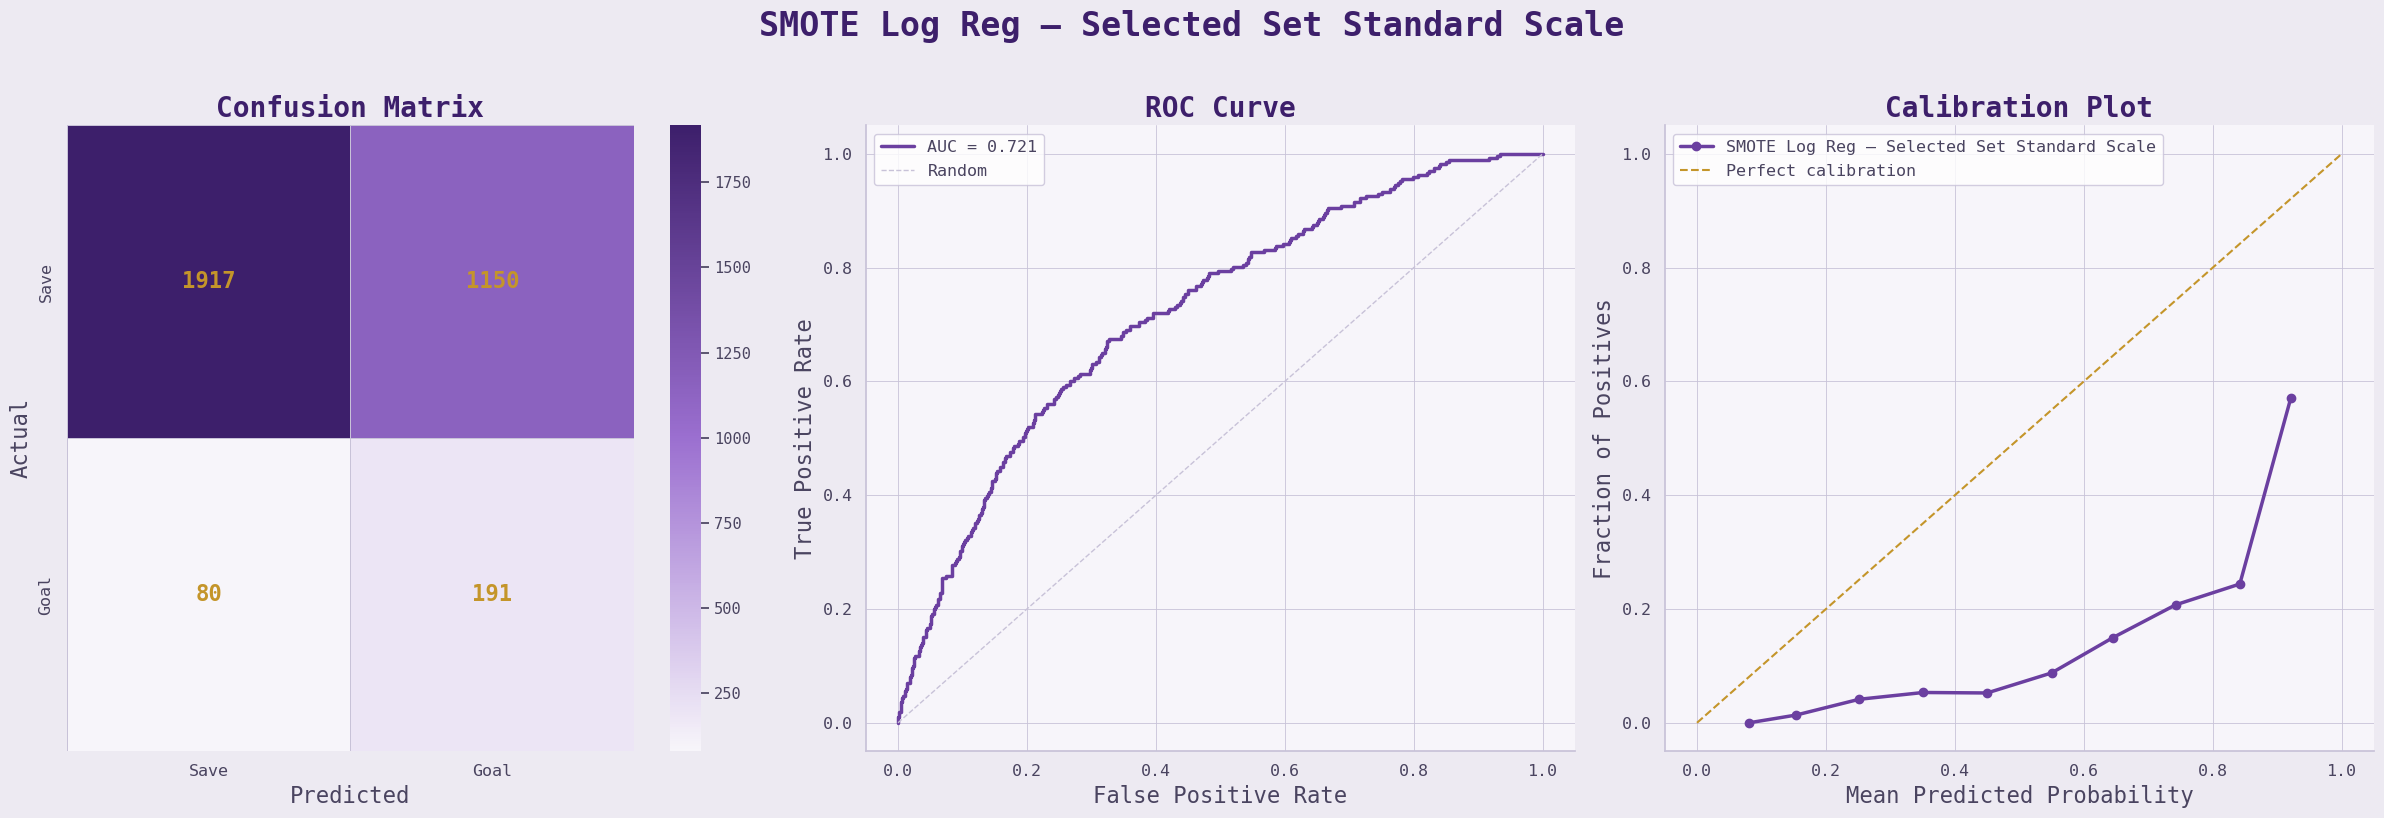

In [32]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote',        SMOTE(random_state=29)),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, model_name="SMOTE Log Reg — Selected Set Standard Scale")


  SMOTE Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       63.06%
  AUC:                            0.72
  Log Loss:                       0.621
  Avg Precision (PR-AUC):         0.194

              precision    recall  f1-score   support

        Save       0.96      0.62      0.76      3067
        Goal       0.14      0.70      0.23       271

    accuracy                           0.63      3338
   macro avg       0.55      0.66      0.50      3338
weighted avg       0.89      0.63      0.71      3338



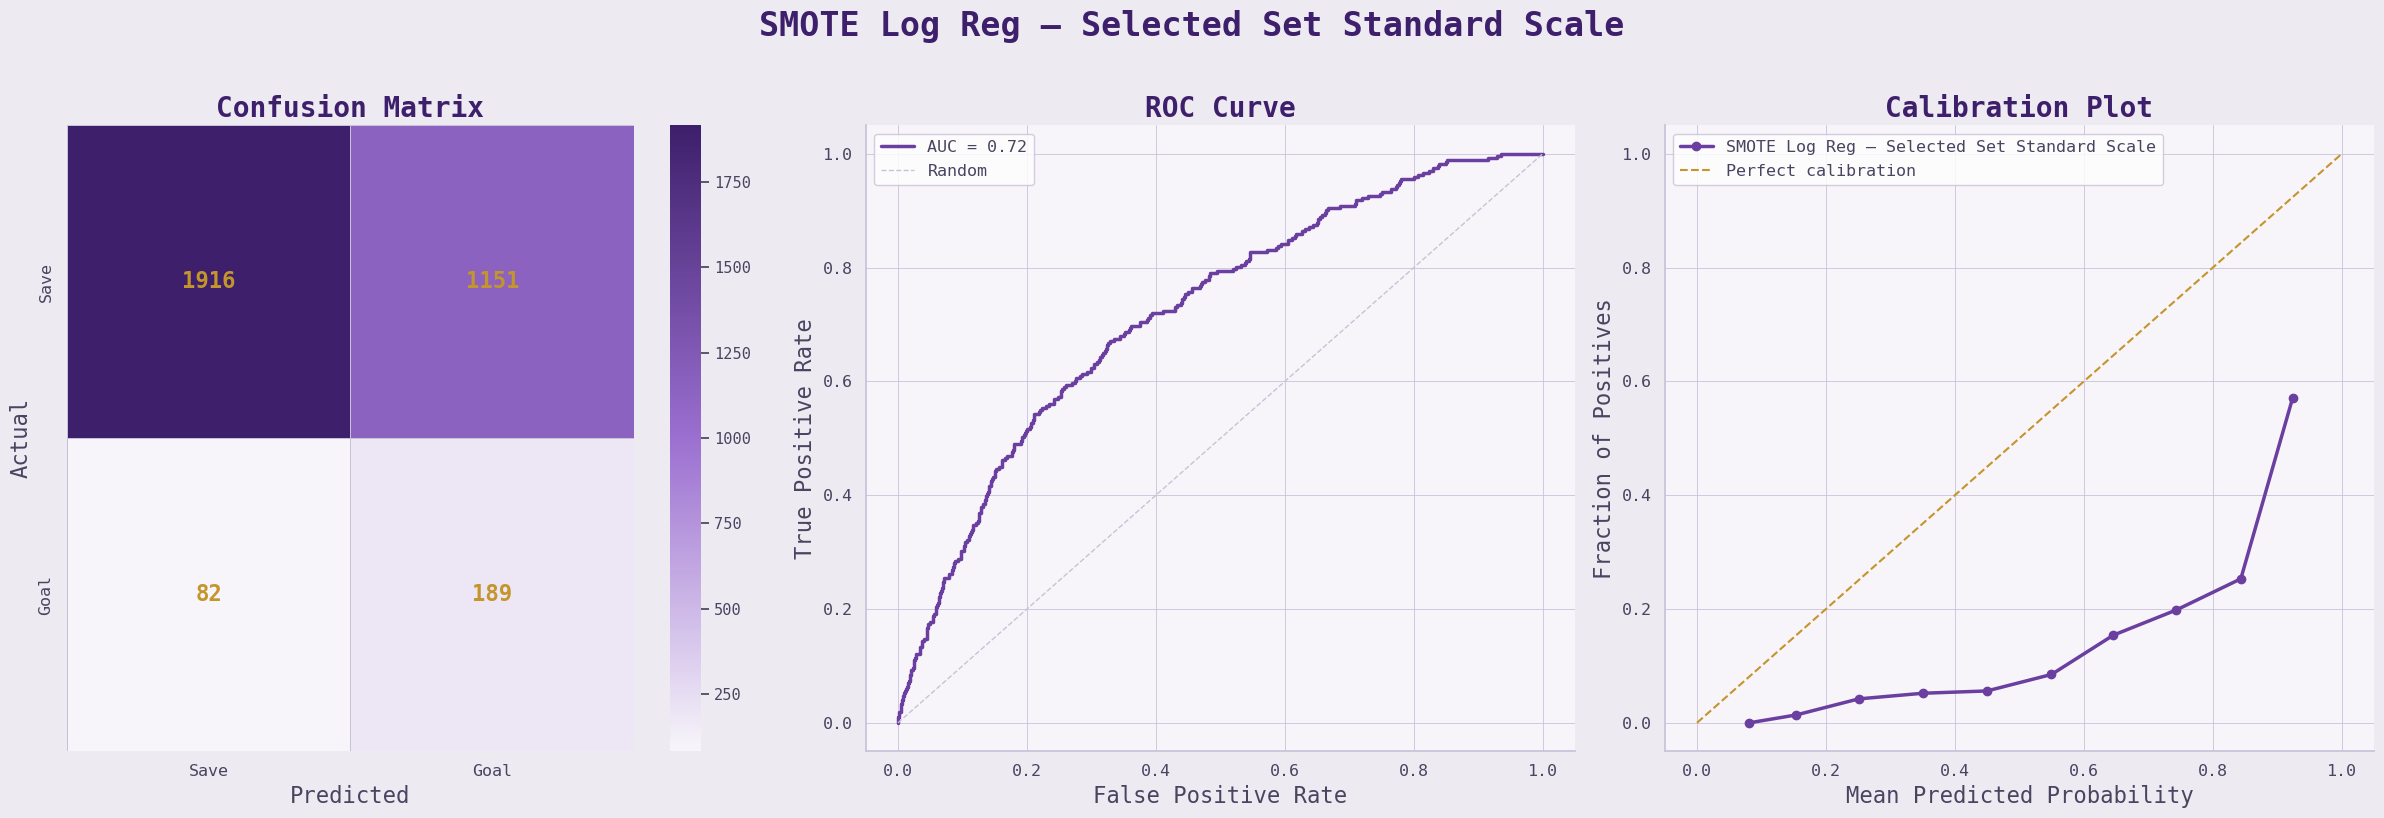

In [33]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote',        SMOTE(random_state=29)),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, model_name="SMOTE Log Reg — Selected Set Standard Scale")

Using smote yielded similar results without any improvement.

Balancing the data did yield some guesses for goals, but without precision.  I am going to return to the unbalanced data but lower the threshold for predicting a goal.  The hope is that the models will increase the number of guesses for goals, which may lower the accuracy of the model but improve its applicability.


   Lowered (0.25) Log Reg — Full Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       90.08%
  AUC:                            0.774
  Log Loss:                       0.244
  Avg Precision (PR-AUC):         0.242

              precision    recall  f1-score   support

        Save       0.93      0.97      0.95      3067
        Goal       0.30      0.17      0.21       271

    accuracy                           0.90      3338
   macro avg       0.61      0.57      0.58      3338
weighted avg       0.88      0.90      0.89      3338



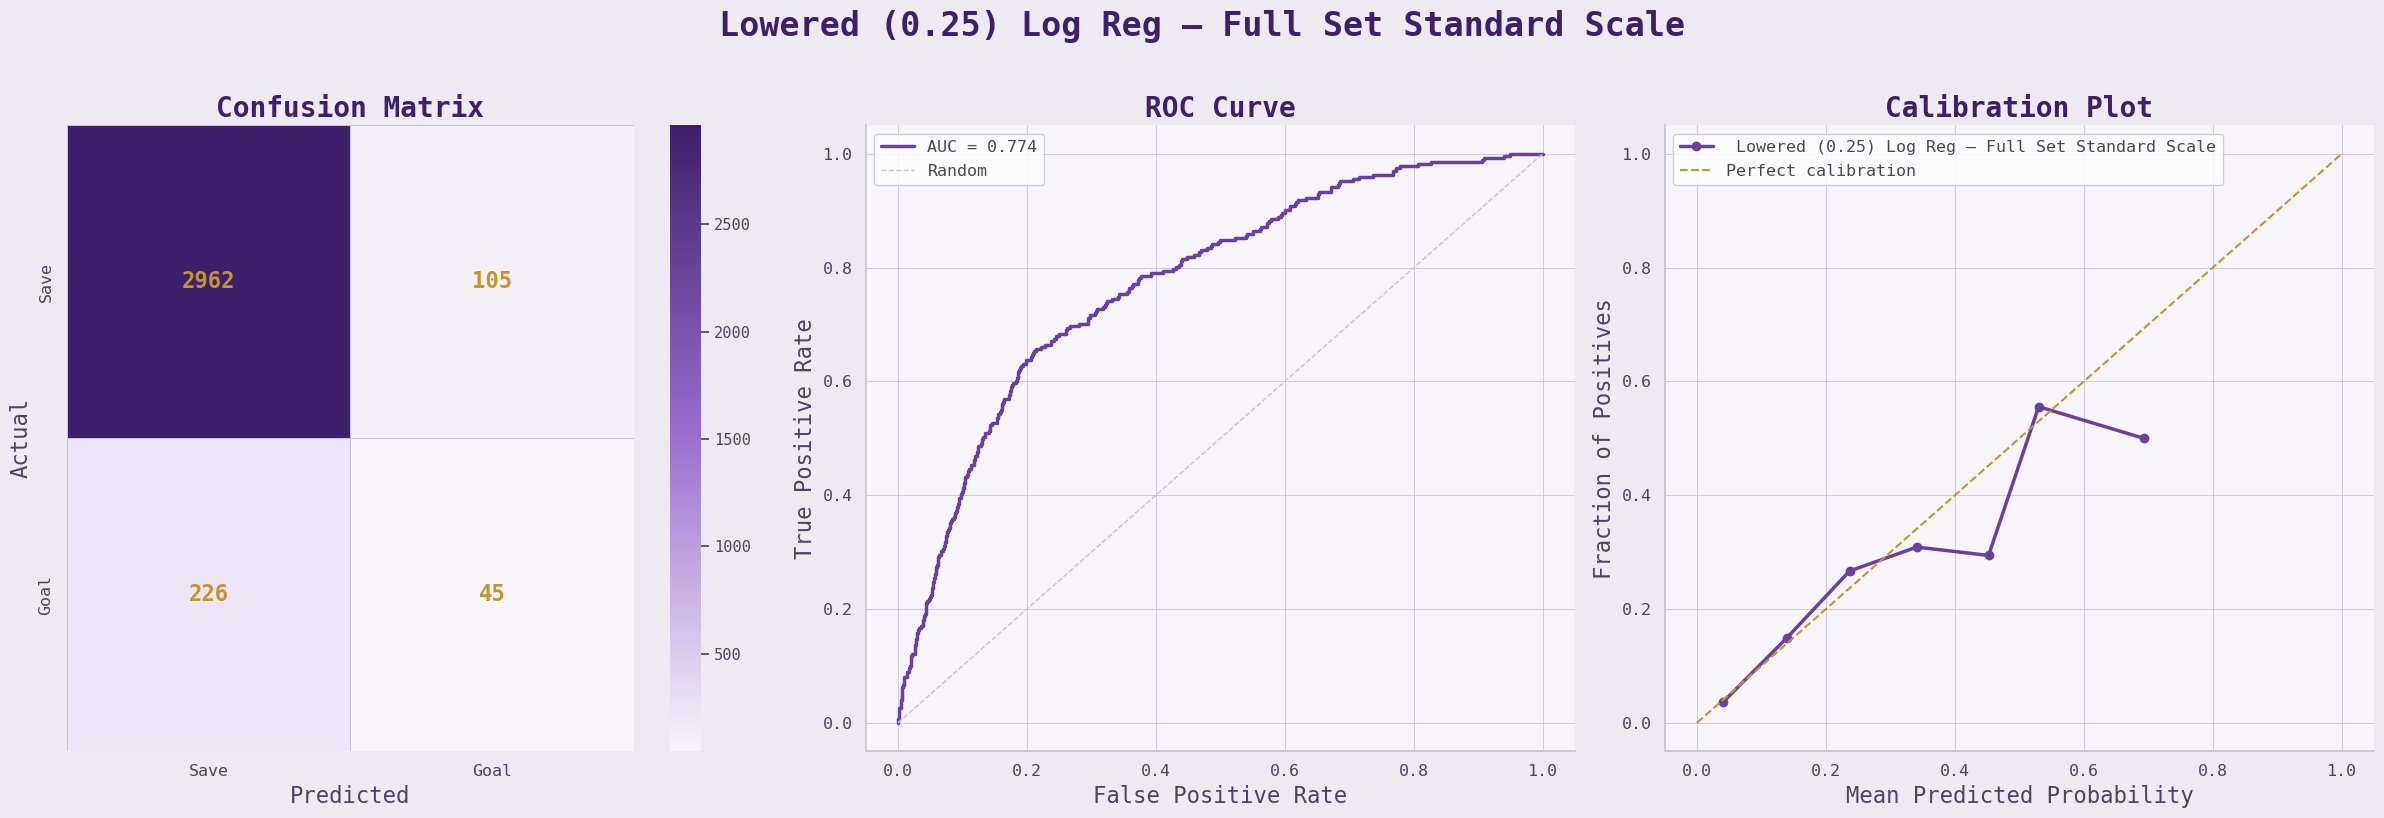

In [34]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train, y_train)
model_eval(pipeline,
           X_test,
           y_test,
           model_name=" Lowered (0.25) Log Reg — Full Set Standard Scale",
           threshold = 0.25)

We got more guesses for goals, but the recall is pretty low (though better than the balanced data) for guessing goals.  I'll lower the threshold even lower to see the effect on the model.


   Lowered (0.1) Log Reg — Full Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       73.49%
  AUC:                            0.774
  Log Loss:                       0.244
  Avg Precision (PR-AUC):         0.242

              precision    recall  f1-score   support

        Save       0.96      0.74      0.84      3067
        Goal       0.19      0.69      0.30       271

    accuracy                           0.73      3338
   macro avg       0.58      0.71      0.57      3338
weighted avg       0.90      0.73      0.79      3338



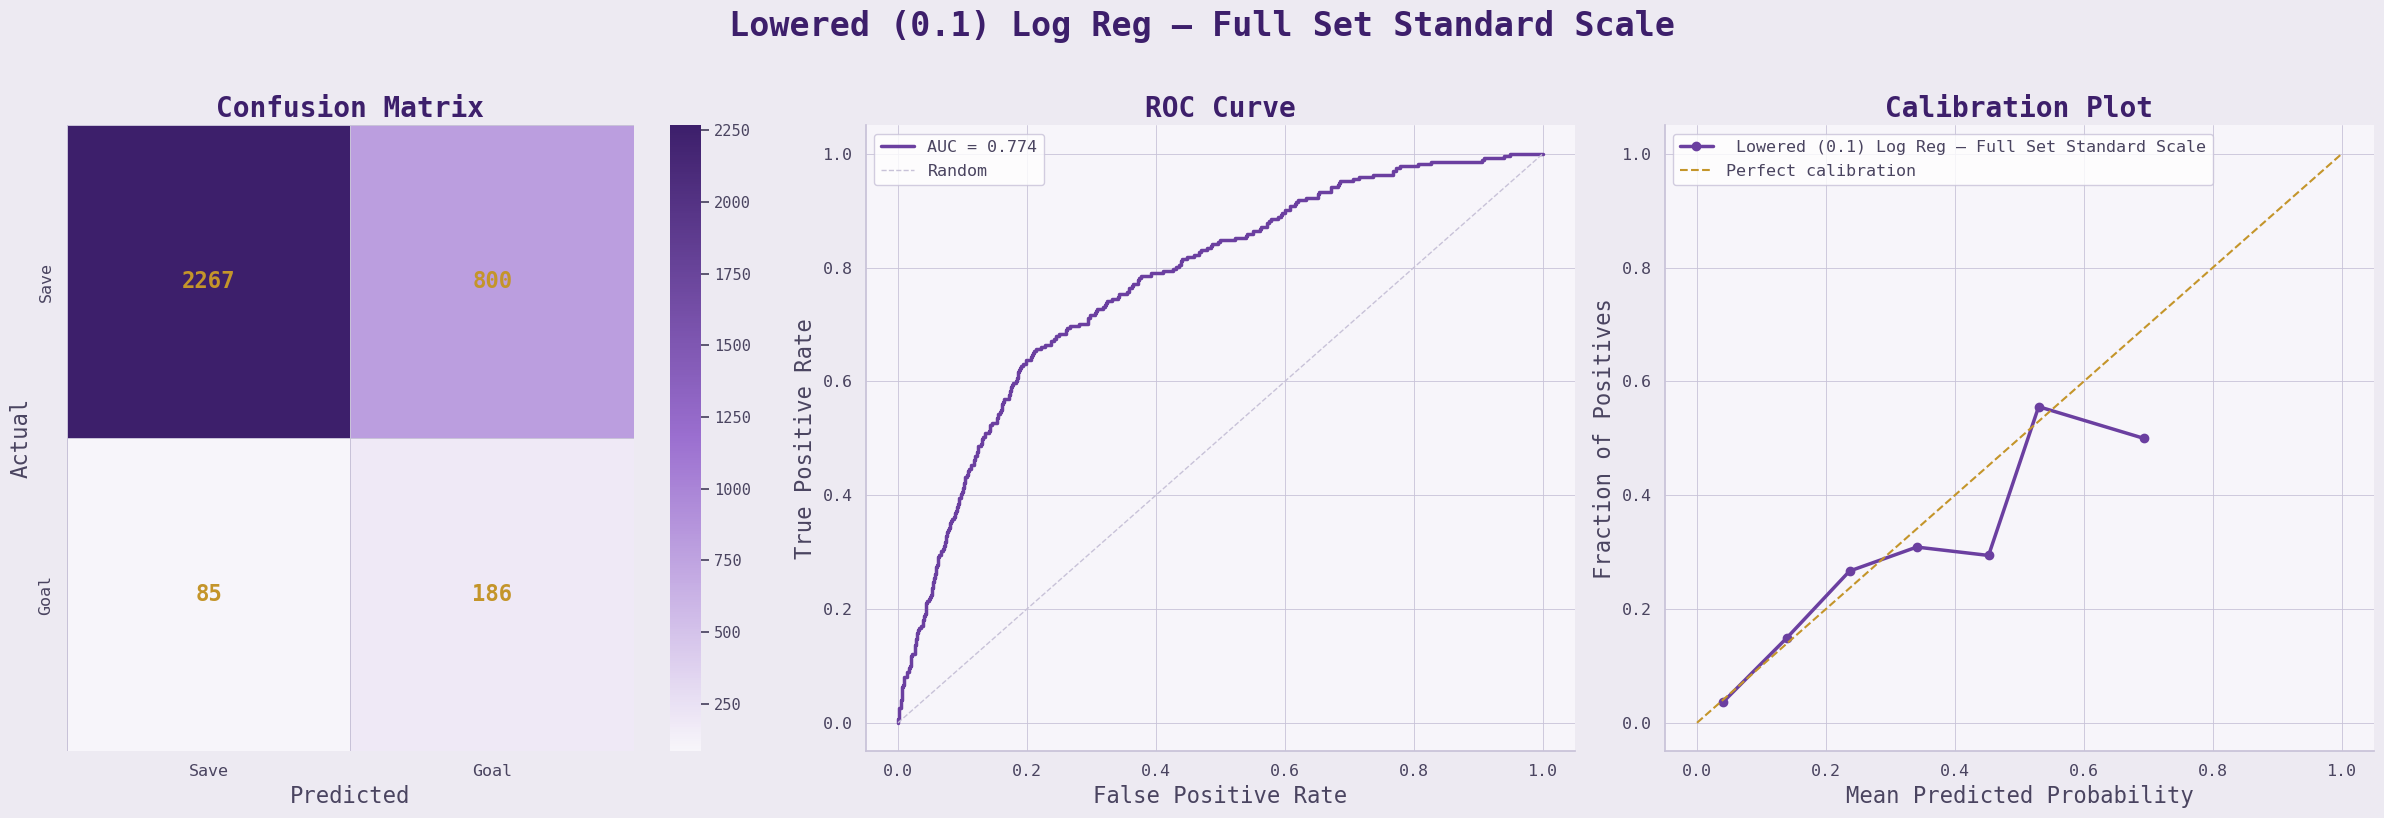

In [35]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train, y_train)
model_eval(pipeline,
           X_test,
           y_test,
           model_name=" Lowered (0.1) Log Reg — Full Set Standard Scale",
           threshold = 0.1)

This one has ticked over and is now over guessing goals and the accuracy is lowering.  I'll try again with the limited dataset.


   Lowered (0.25) Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       90.56%
  AUC:                            0.723
  Log Loss:                       0.258
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.92      0.98      0.95      3067
        Goal       0.27      0.09      0.14       271

    accuracy                           0.91      3338
   macro avg       0.60      0.53      0.54      3338
weighted avg       0.87      0.91      0.88      3338



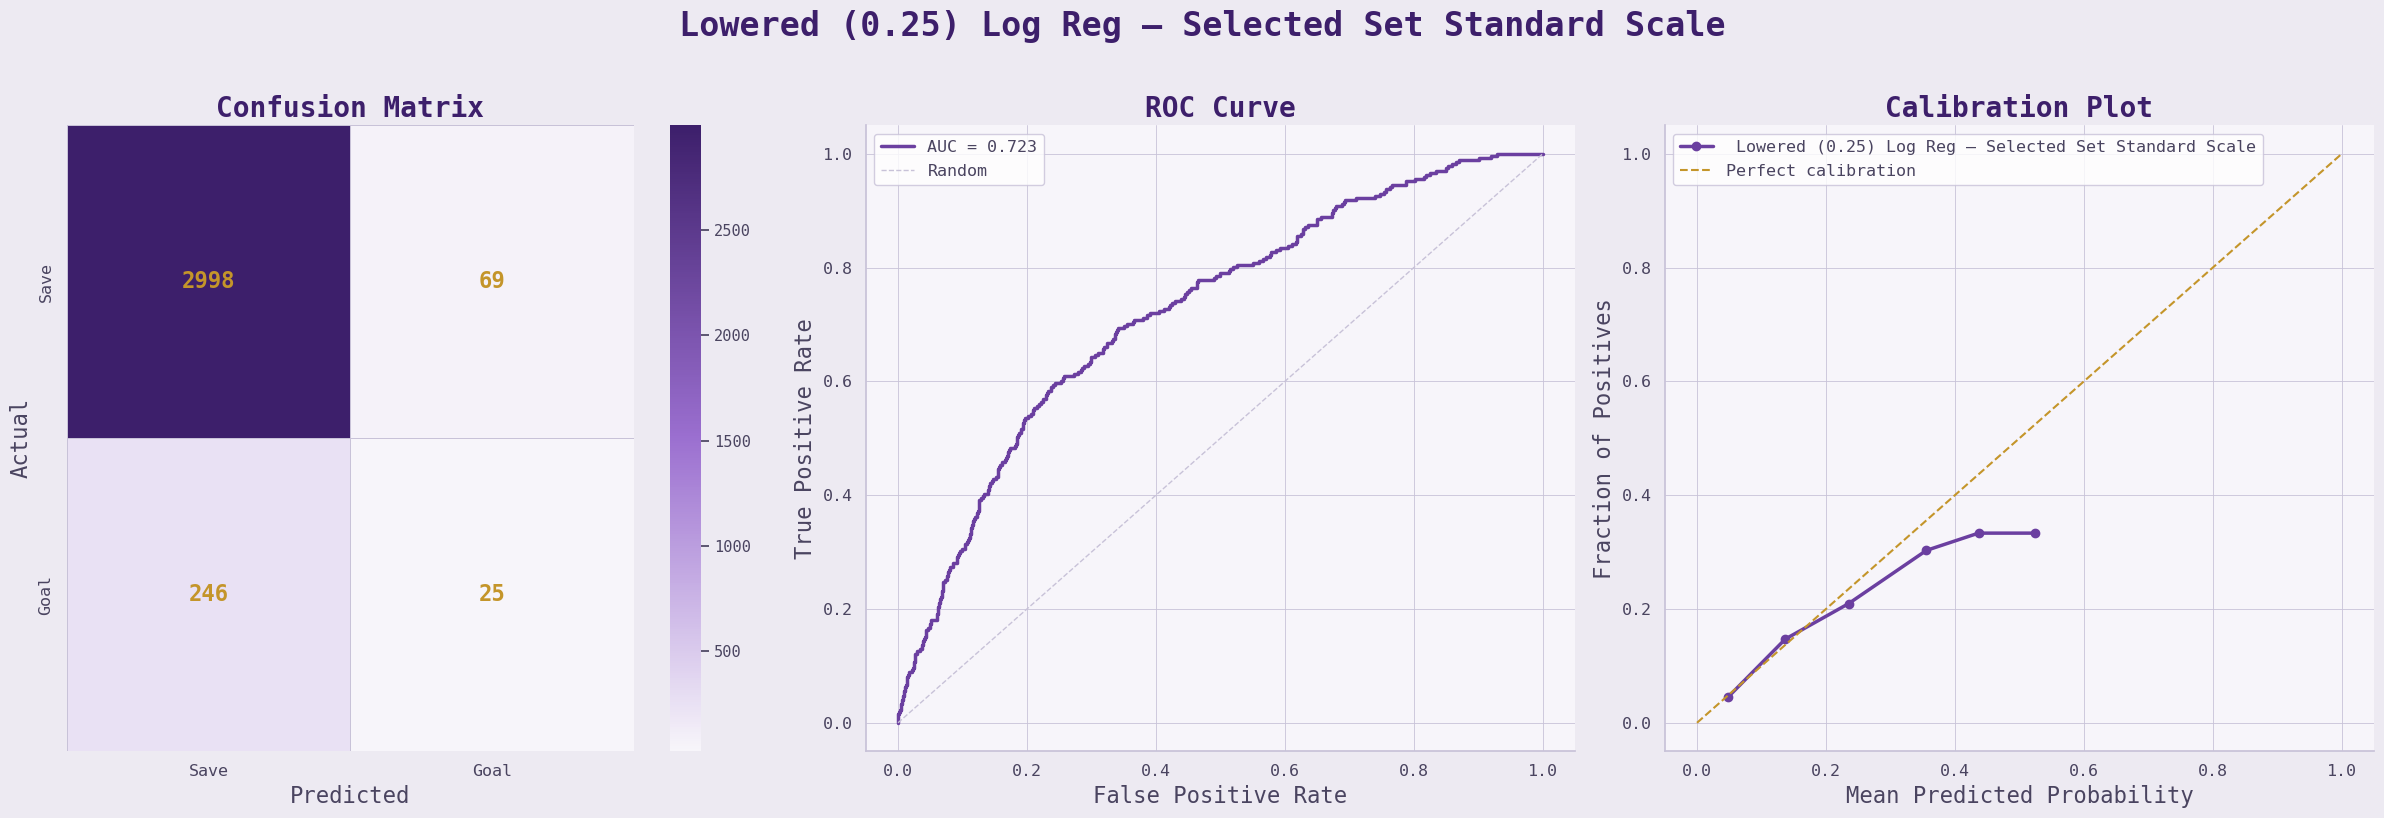

In [36]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name=" Lowered (0.25) Log Reg — Selected Set Standard Scale",
           threshold = 0.25)


   Lowered (0.1) Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       71.63%
  AUC:                            0.723
  Log Loss:                       0.258
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.95      0.73      0.82      3067
        Goal       0.16      0.61      0.26       271

    accuracy                           0.72      3338
   macro avg       0.56      0.67      0.54      3338
weighted avg       0.89      0.72      0.78      3338



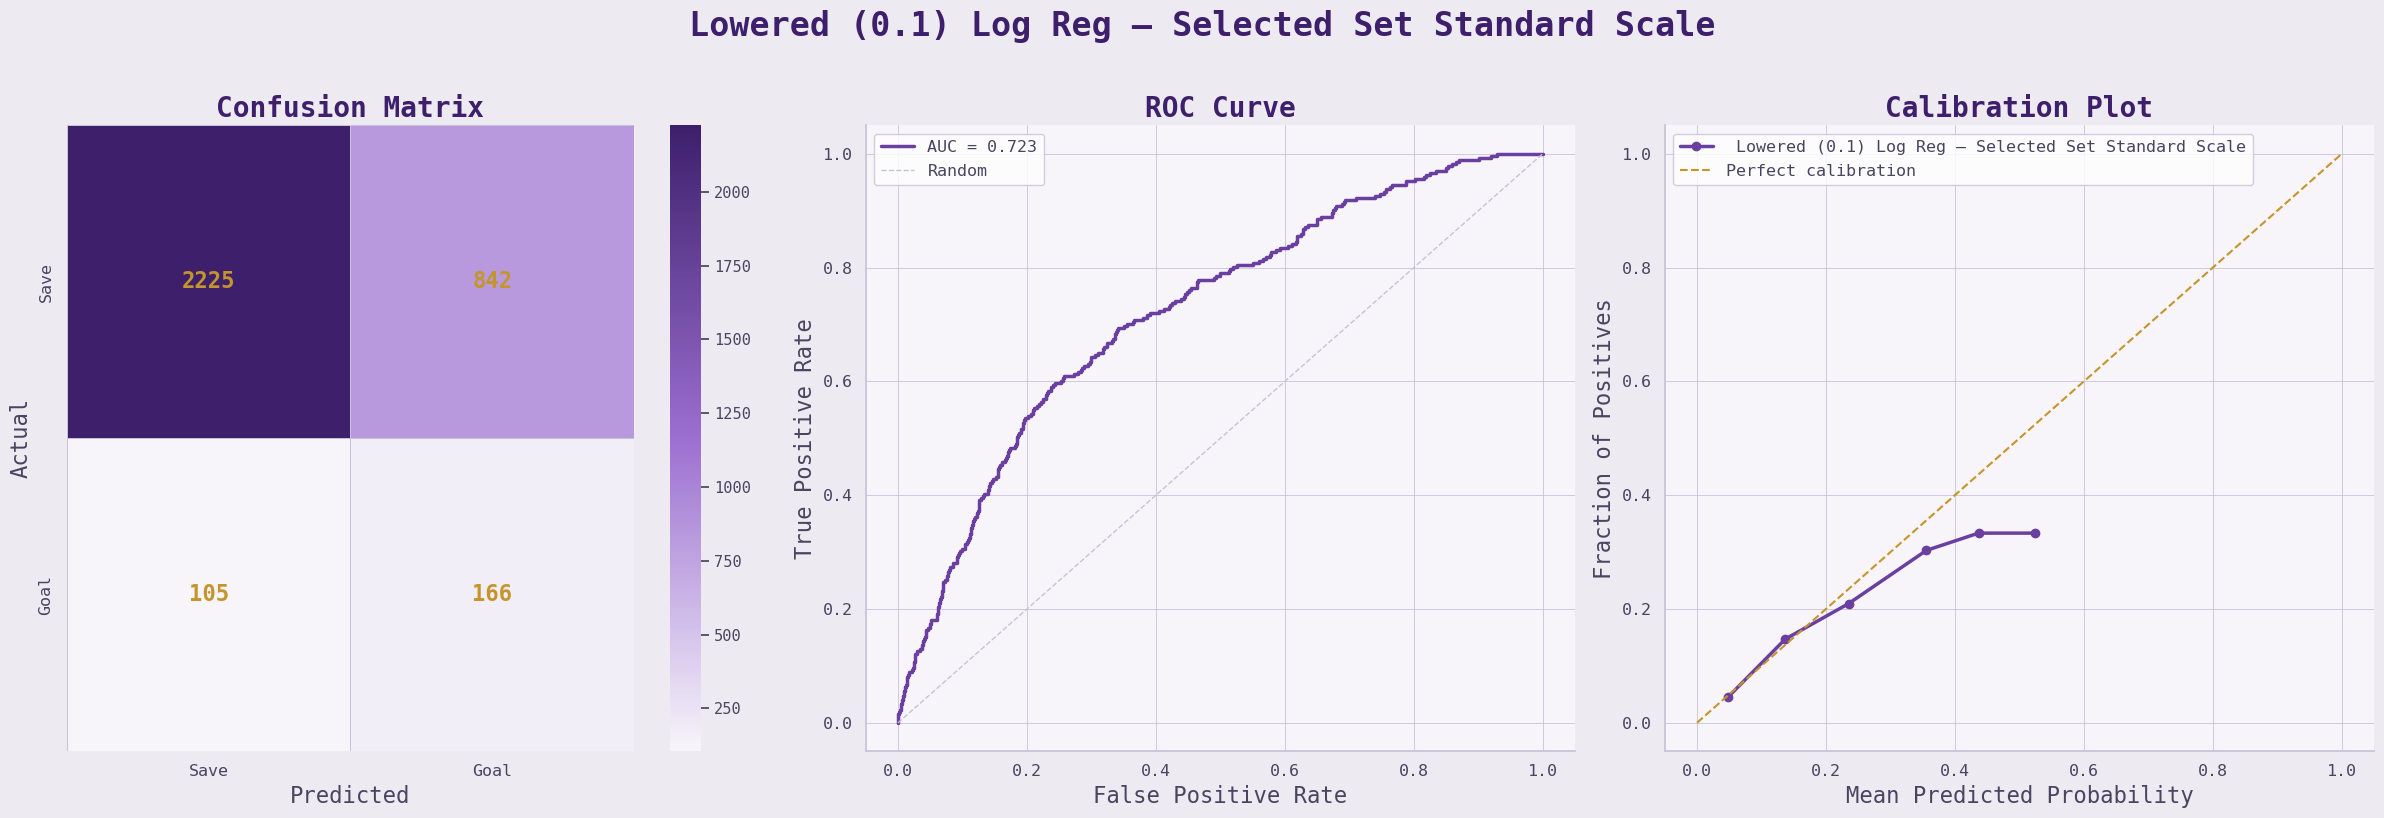

In [37]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name=" Lowered (0.1) Log Reg — Selected Set Standard Scale",
           threshold = 0.1)


   Lowered (0.25) Log Reg — Selected Set MinMax Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       90.59%
  AUC:                            0.723
  Log Loss:                       0.258
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.92      0.98      0.95      3067
        Goal       0.26      0.09      0.13       271

    accuracy                           0.91      3338
   macro avg       0.59      0.53      0.54      3338
weighted avg       0.87      0.91      0.88      3338



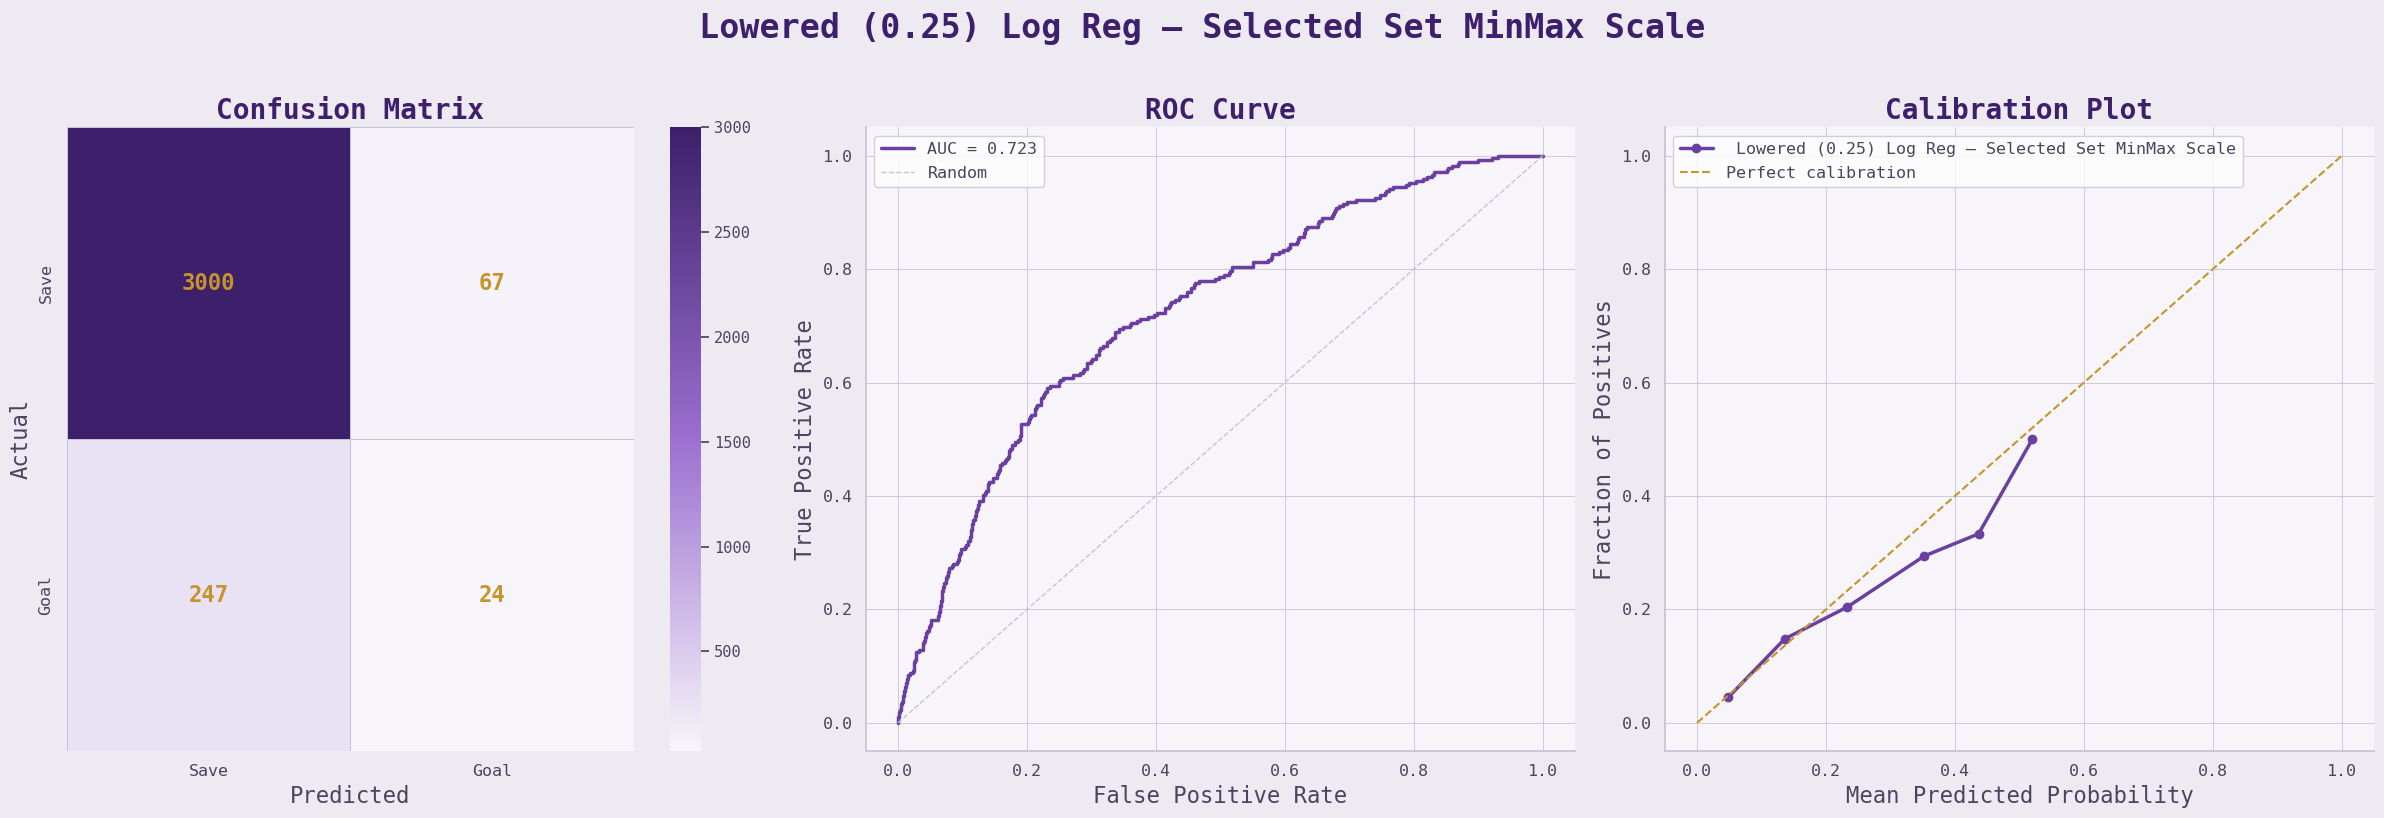

In [38]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name=" Lowered (0.25) Log Reg — Selected Set MinMax Scale",
           threshold = 0.25)


   Lowered (0.1) Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       71.63%
  AUC:                            0.723
  Log Loss:                       0.258
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.95      0.73      0.82      3067
        Goal       0.16      0.61      0.26       271

    accuracy                           0.72      3338
   macro avg       0.56      0.67      0.54      3338
weighted avg       0.89      0.72      0.78      3338



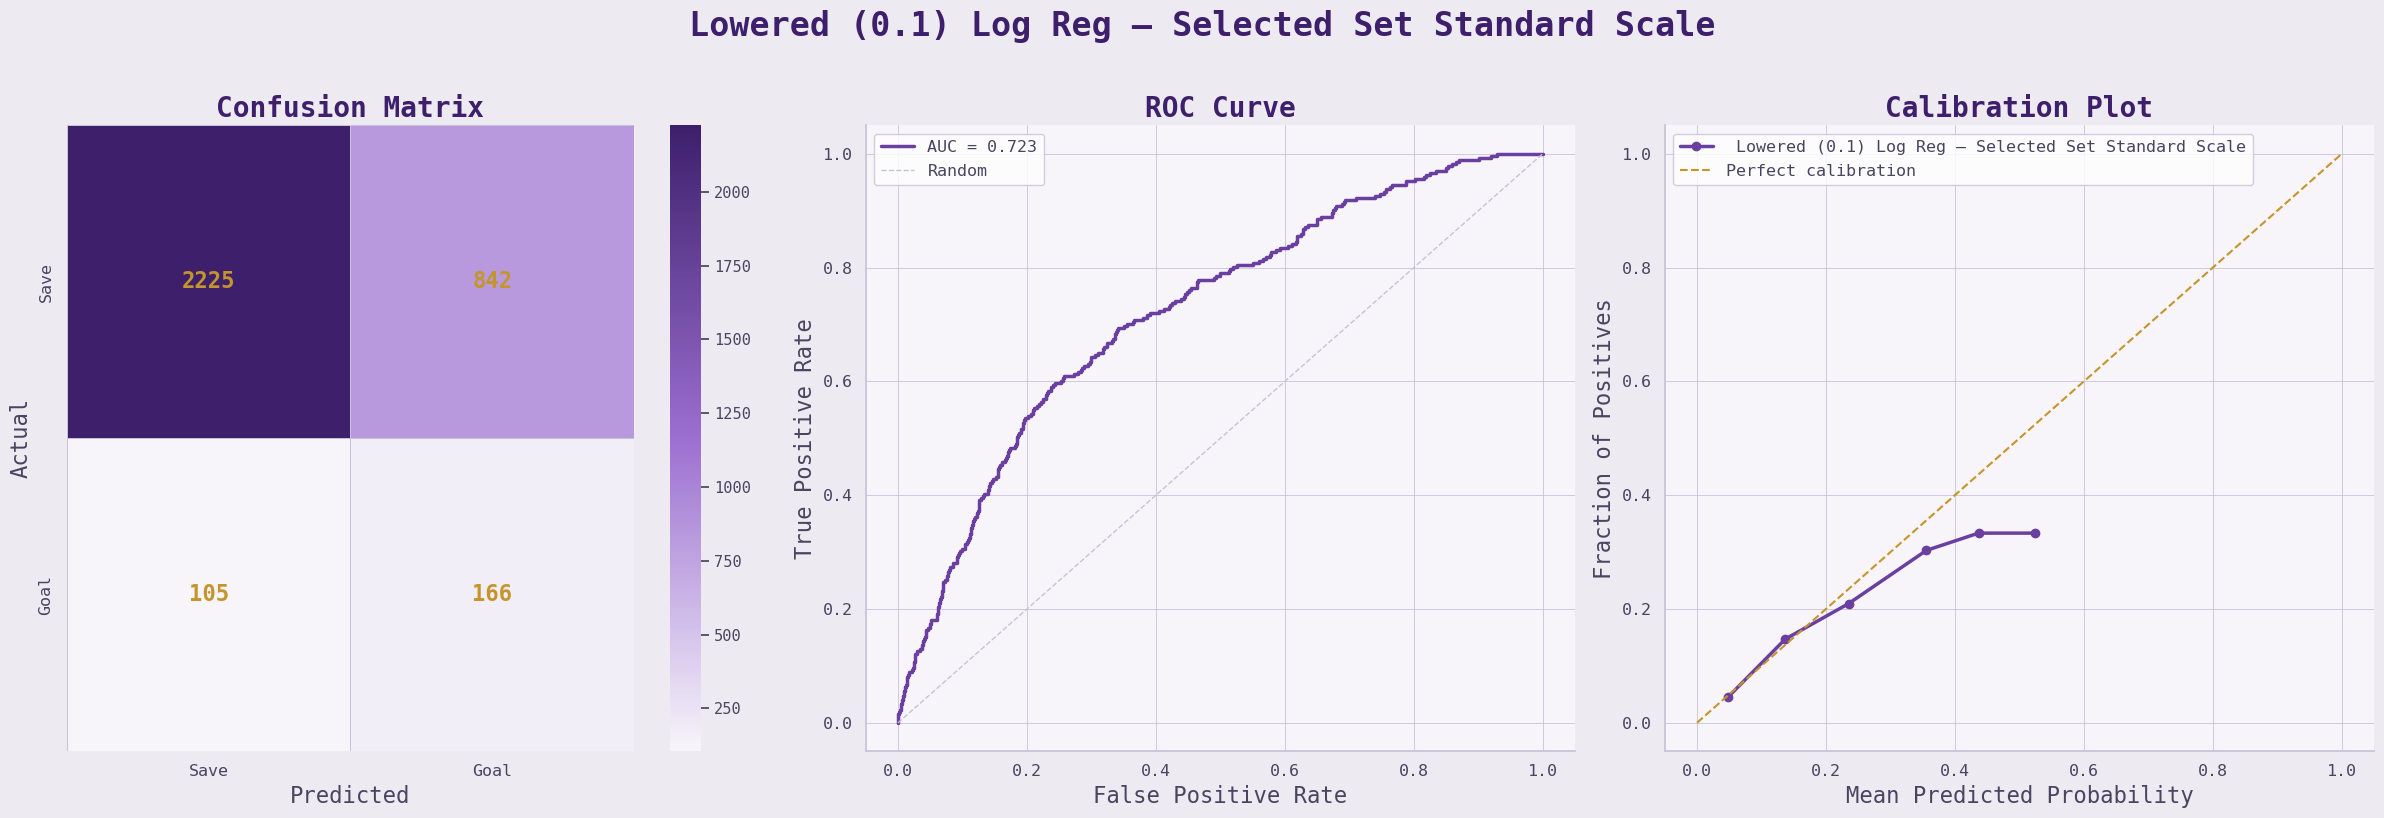

In [39]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name=" Lowered (0.1) Log Reg — Selected Set Standard Scale",
           threshold = 0.1, )

There does seem to be some success in lowering the threshold in making predictions for goals, but not in a meaningful way in improving the models.

Up to this point:
- Scaling has a good impact, but difference between standard and minmax scaling so we'll stick to Standard
- Balancing the data had an overall negative impact on the models
- Lowering the threshold succeeded at making more goal predictions with a smaller decrease having a smaller negative impact on accuracy
- The full set of data is yielding better results than the smaller subset but fairly small.

I will try to tune the C-value hyperparameter in order to see if that will have an effect on the model.  Given what I've seen so far, I will focus on Standard Scaled data but will try different thresholds for predictions along with using the full and the selected datasets.

In [40]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

In [41]:
param_grid = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 5000]}
grid = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)

{'model__C': 500} 0.773947822754419


In [42]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(C = 500))
])


  Log Reg C 500 — Full Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       91.88%
  AUC:                            0.775
  Log Loss:                       0.244
  Avg Precision (PR-AUC):         0.241

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.50      0.02      0.04       271

    accuracy                           0.92      3338
   macro avg       0.71      0.51      0.50      3338
weighted avg       0.89      0.92      0.88      3338



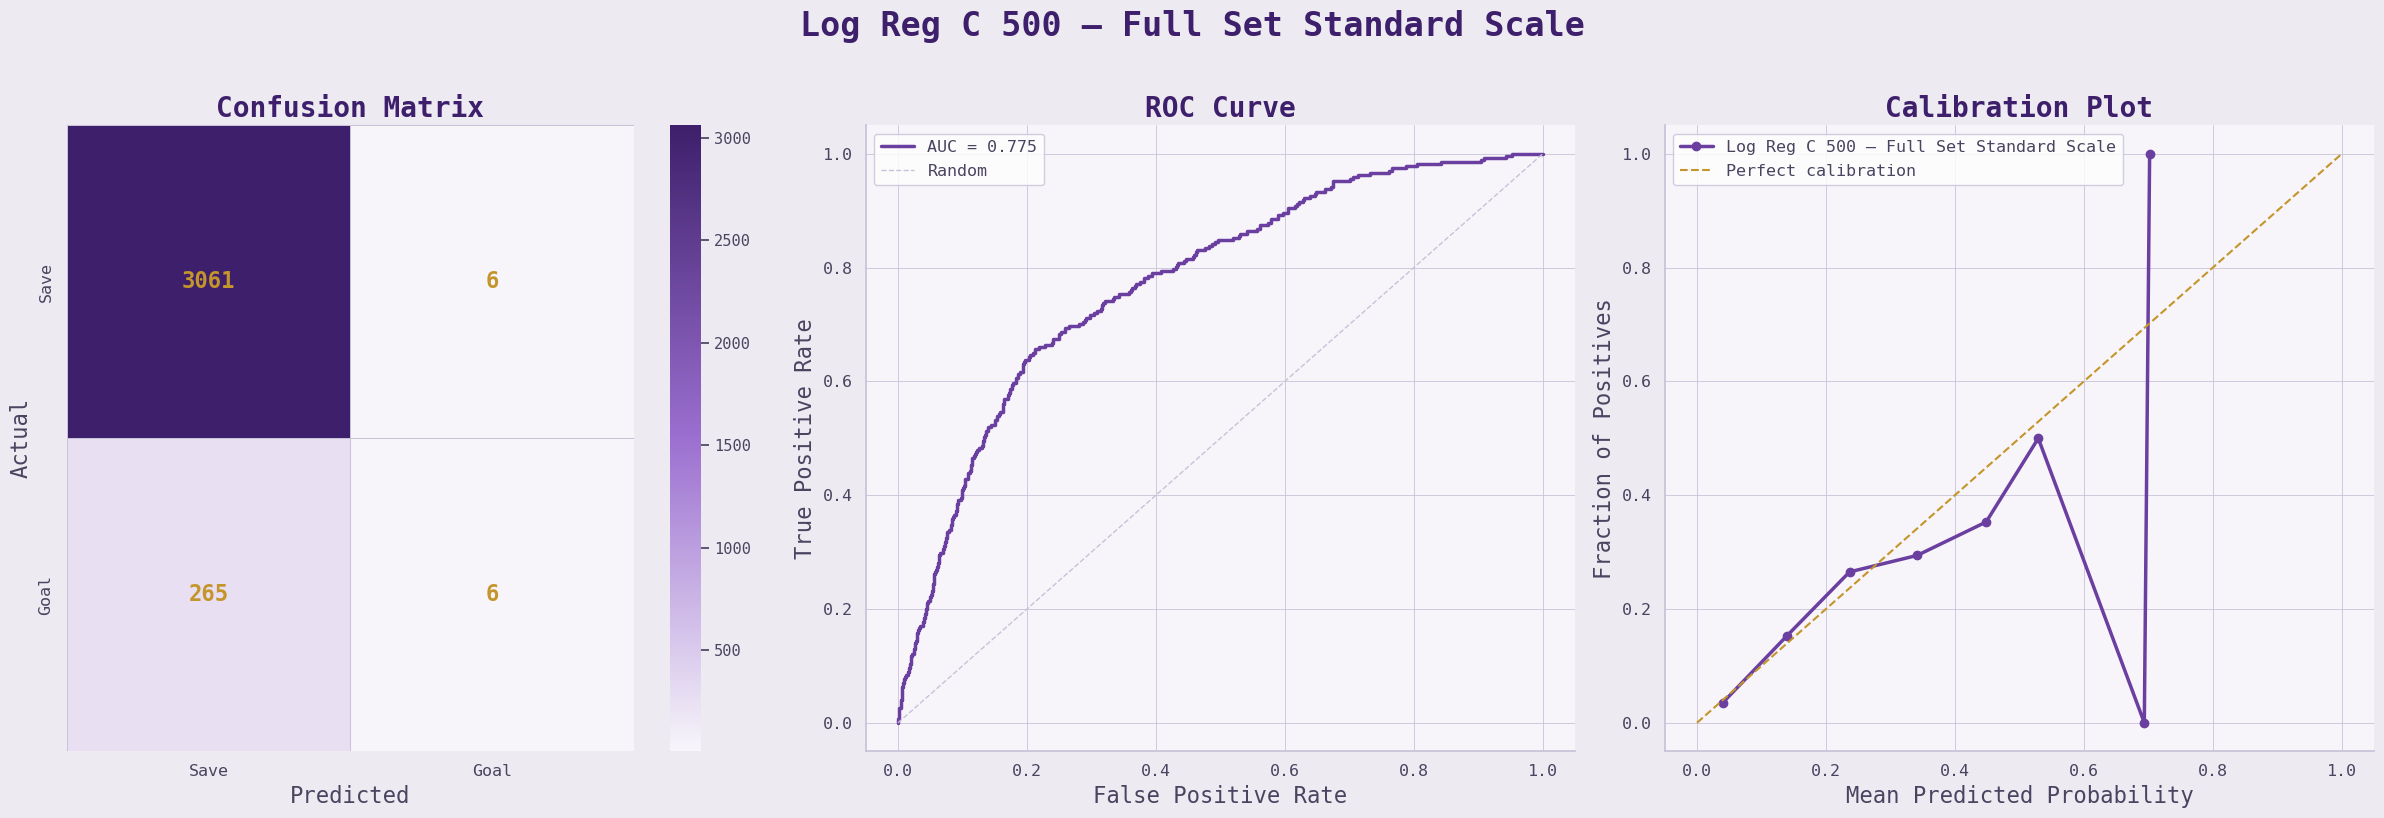

In [43]:
pipeline.fit(X_train, y_train)
model_eval(pipeline,
           X_test,
           y_test,
           model_name="Log Reg C 500 — Full Set Standard Scale")


  Lowered (0.25) Log Reg C 500 — Full Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       90.05%
  AUC:                            0.775
  Log Loss:                       0.244
  Avg Precision (PR-AUC):         0.241

              precision    recall  f1-score   support

        Save       0.93      0.97      0.95      3067
        Goal       0.30      0.17      0.22       271

    accuracy                           0.90      3338
   macro avg       0.62      0.57      0.58      3338
weighted avg       0.88      0.90      0.89      3338



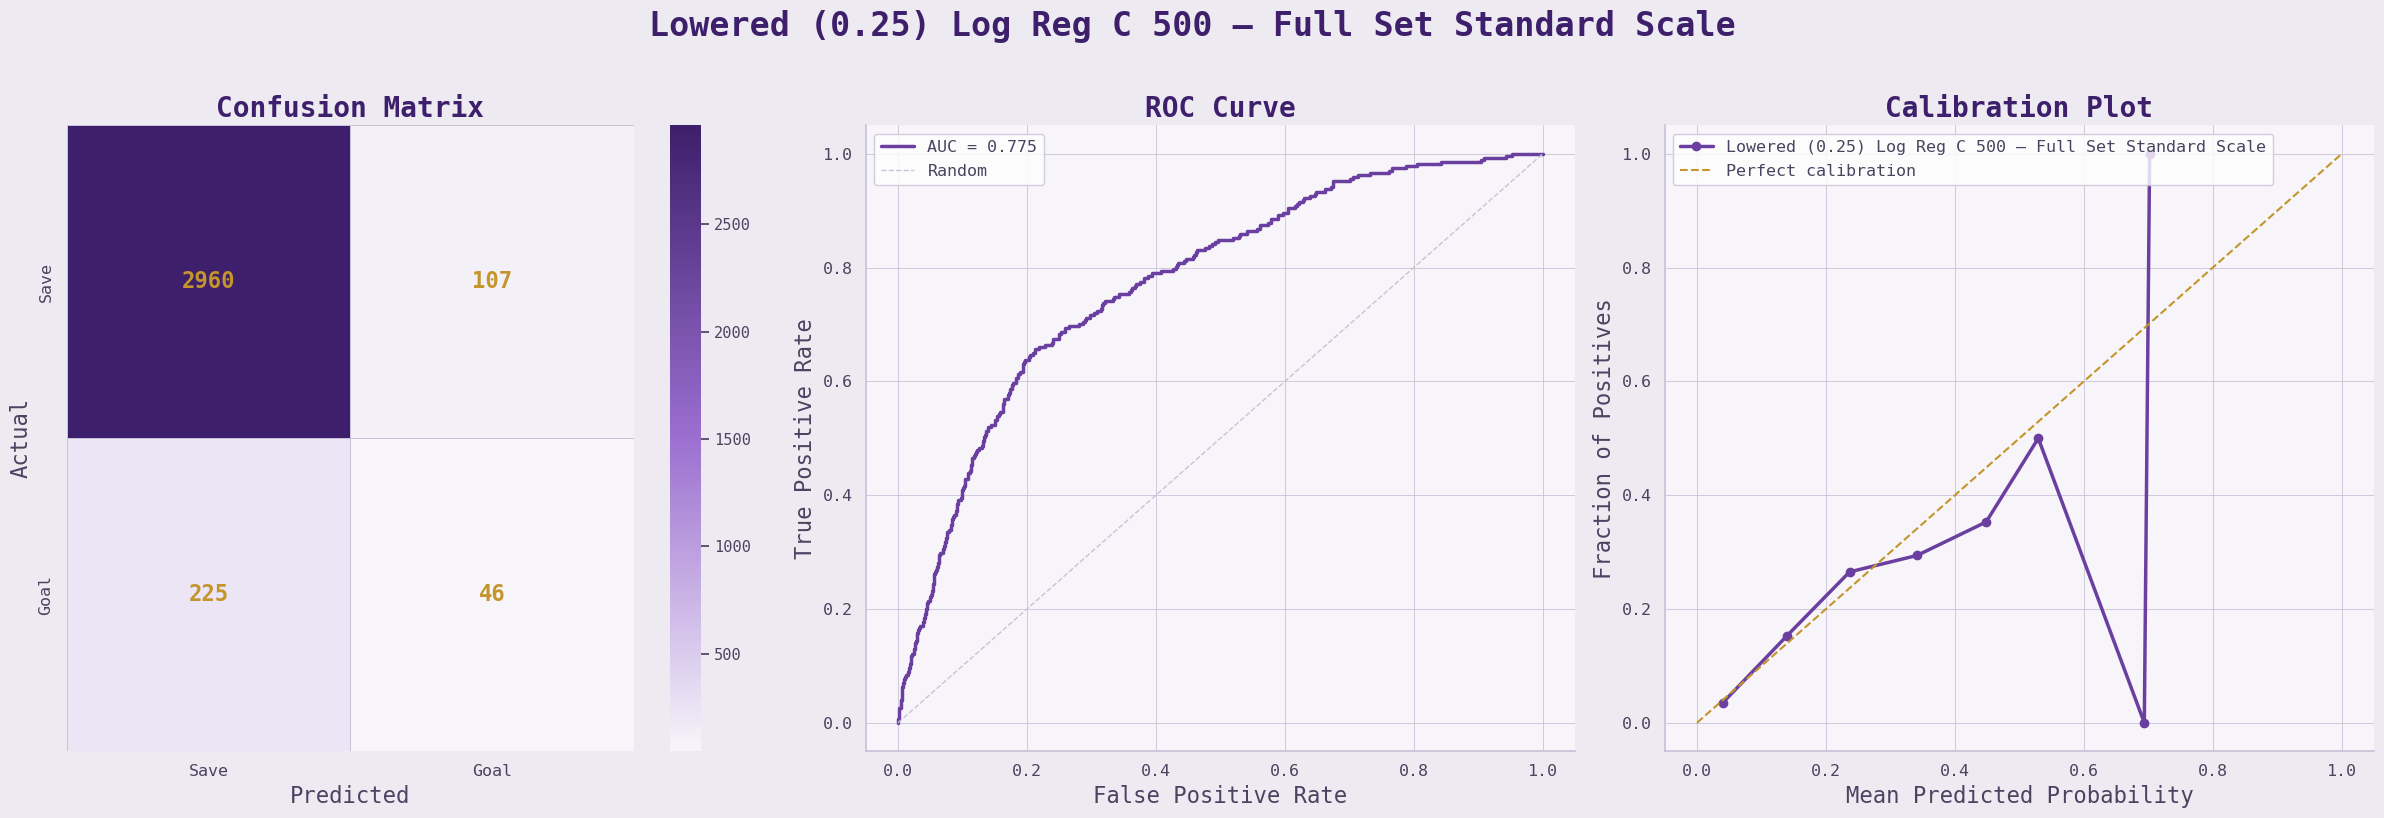

In [44]:
pipeline.fit(X_train, y_train)
model_eval(pipeline,
           X_test,
           y_test,
           model_name="Lowered (0.25) Log Reg C 500 — Full Set Standard Scale",
           threshold = 0.25)

In [45]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

In [46]:
param_grid = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 5000]}
grid = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)
grid.fit(X_train[selected_cols], y_train)
print(grid.best_params_, grid.best_score_)

{'model__C': 1000} 0.7288470245218402


In [47]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(C = 1000))
])


  Log Reg C 1000 — Selected Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       91.88%
  AUC:                            0.723
  Log Loss:                       0.258
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.50      0.01      0.01       271

    accuracy                           0.92      3338
   macro avg       0.71      0.50      0.49      3338
weighted avg       0.89      0.92      0.88      3338



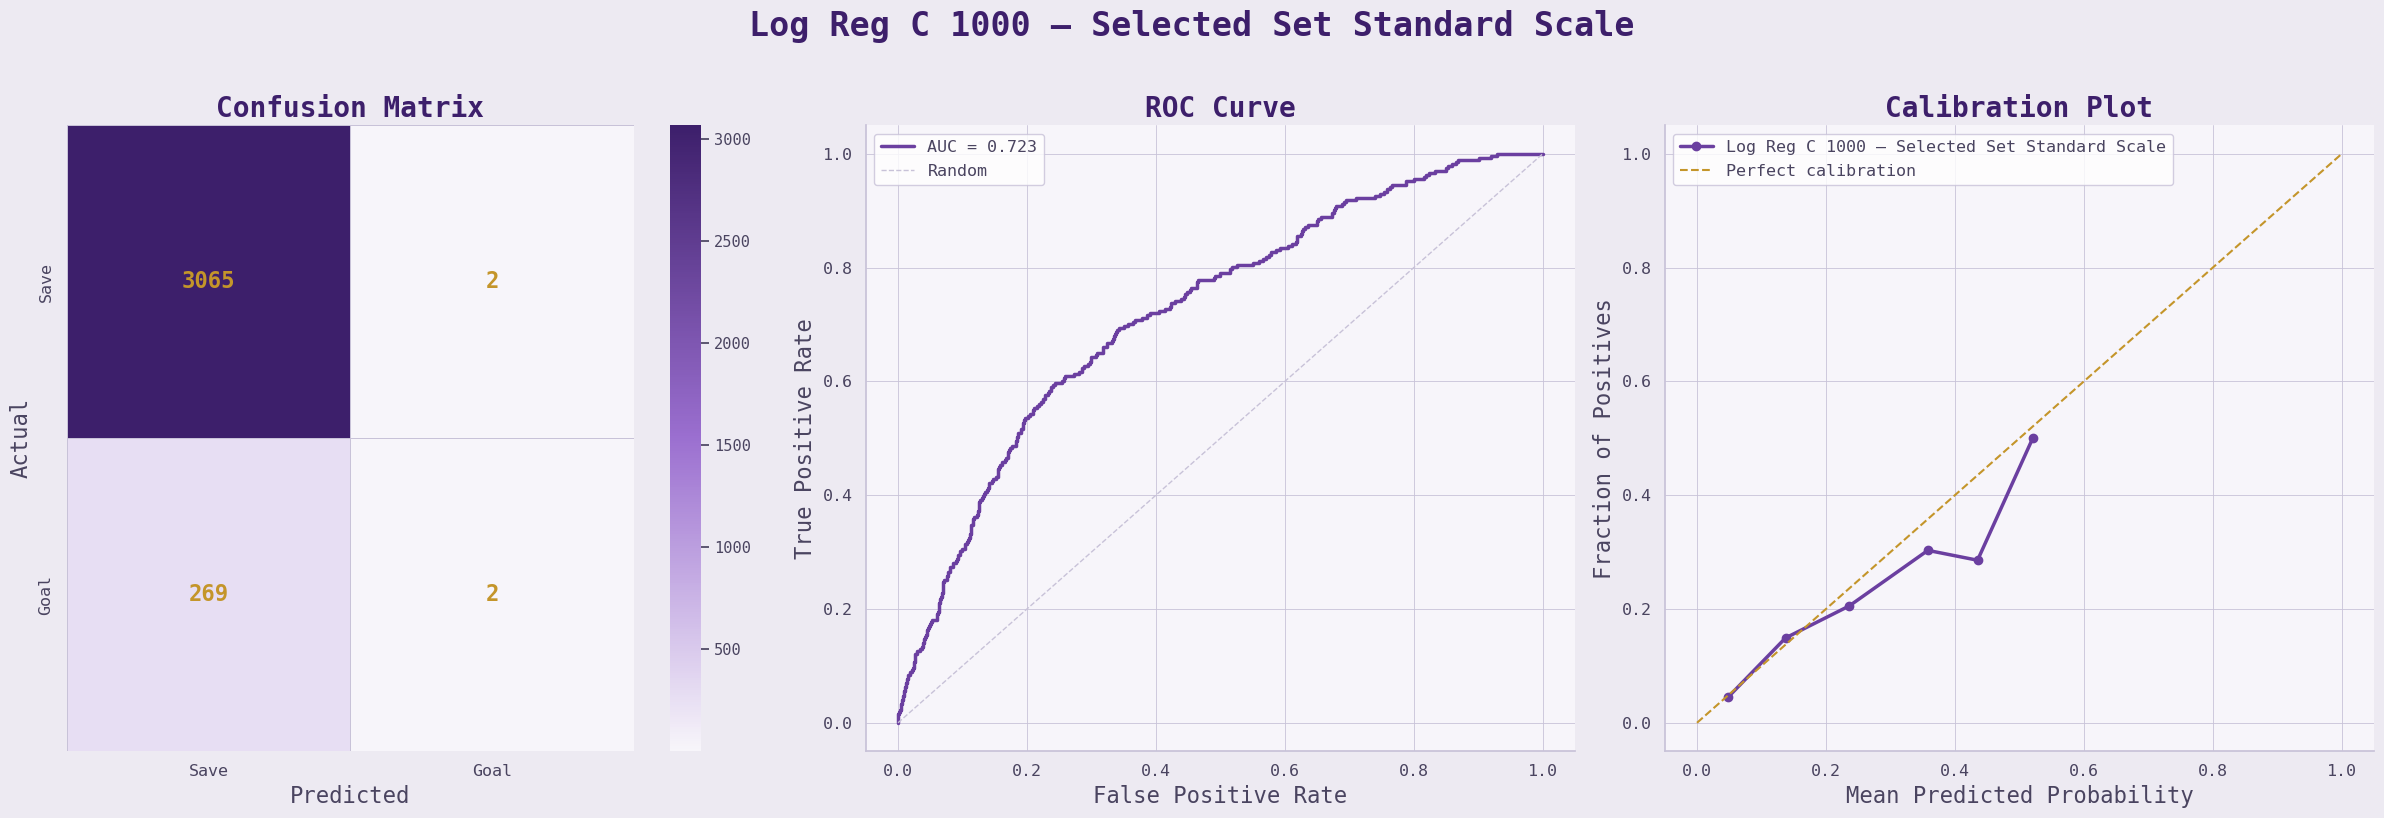

In [48]:
pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name="Log Reg C 1000 — Selected Set Standard Scale")


  Lowered (0.25) Log Reg C 1000 — Selected Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       90.5%
  AUC:                            0.723
  Log Loss:                       0.258
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.92      0.98      0.95      3067
        Goal       0.26      0.09      0.14       271

    accuracy                           0.91      3338
   macro avg       0.59      0.53      0.54      3338
weighted avg       0.87      0.91      0.88      3338



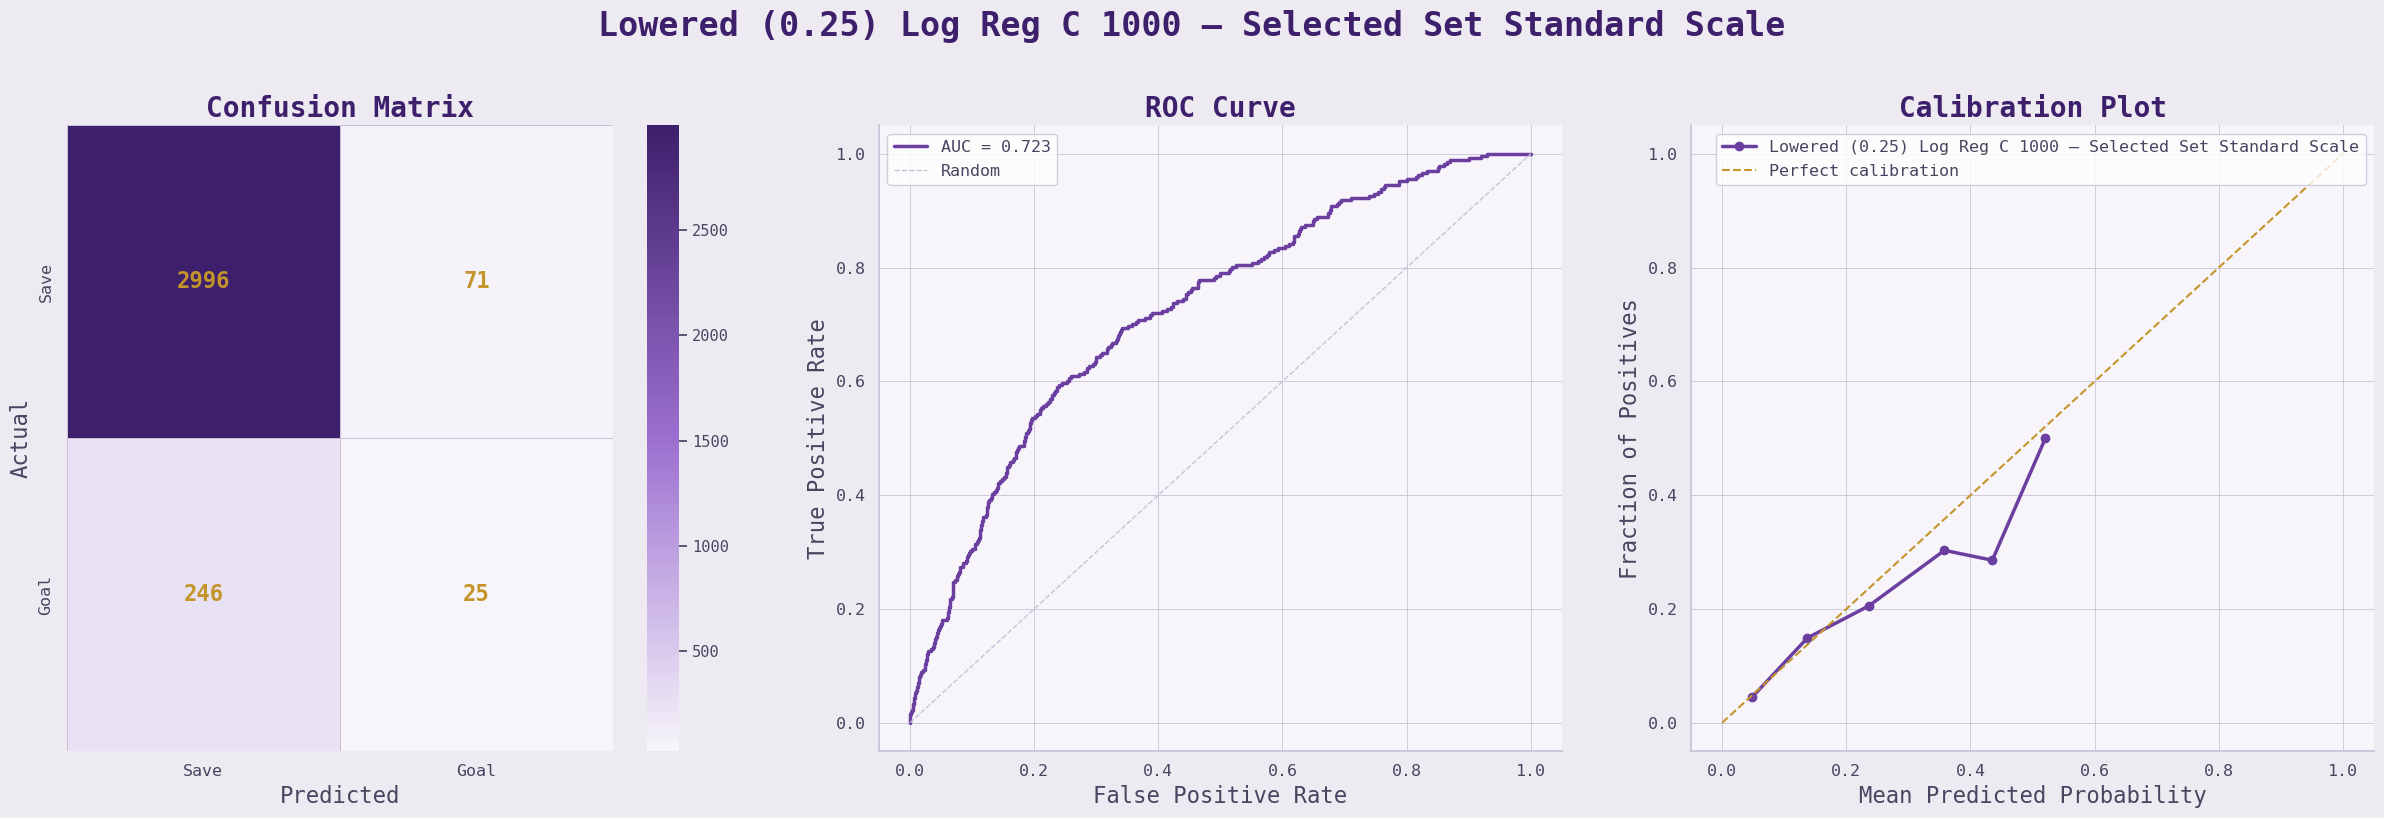

In [49]:
pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name="Lowered (0.25) Log Reg C 1000 — Selected Set Standard Scale",
           threshold = 0.25)

### Logistic Regression Summary

The best performing Logistic Regression Models used the full dataset with Standard scaling.  Tuning the c-value up to 500 produced the highest performing model with an **AUC = 0.7749**.

However, it was difficult to get the Logistic Regression models to reliably predict goals in general.  The best performing model only made *12* goal predictions, with a precision of 50%.  Decreasing the threshold did increase the number of goal predictions, but lowered the precision for goal predictions down to 30%.

An effective xG model will need to predict goals reliably, and have more precision in doing so.  

In [50]:
pd.DataFrame(eval_list).sort_values(['auc', 'accuracy'], ascending = [False, False]).head(25)

model  accuracy     auc  \
20            Log Reg C 500 — Full Set Standard Scale    0.9188  0.7747   
21  Lowered (0.25) Log Reg C 500 — Full Set Standa...    0.9005  0.7747   
2                   Log Reg — Full Set Standard Scale    0.9191  0.7743   
14   Lowered (0.25) Log Reg — Full Set Standard Scale    0.9008  0.7743   
15    Lowered (0.1) Log Reg — Full Set Standard Scale    0.7349  0.7743   
6          Balanced Log Reg — Full Set Standard Scale    0.6705  0.7734   
7            Balanced Log Reg — Full Set MinMax Scale    0.6735  0.7721   
11              SMOTE Log Reg — Full Set MinMax Scale    0.6762  0.7717   
10            SMOTE Log Reg — Full Set Standard Scale    0.6765  0.7714   
3                     Log Reg - Full Set MinMax Scale    0.9185  0.7709   
0                            Base Logistic Regression    0.9185  0.7485   
5                     Selected Log Reg - MinMax Scale    0.9188  0.7229   
18   Lowered (0.25) Log Reg — Selected Set MinMax ...    0.9059  0.7229   
22       Log Reg C 1000 — Selected Set Standard Scale    0.9188  0.7226   
4                   Selected Log Reg - Standard Scale    0.9185  0.7226   
16   Lowered (0.25) Log Reg — Selected Set Standar...    0.9056  0.7226   
23  Lowered (0.25) Log Reg C 1000 — Selected Set S...    0.9050  0.7226   
17   Lowered (0.1) Log Reg — Selected Set Standard...    0.7163  0.7226   
19   Lowered (0.1) Log Reg — Selected Set Standard...    0.7163  0.7226   
9        Balanced Log Reg — Selected Set MinMax Scale    0.6300  0.7209   
8      Balanced Log Reg — Selected Set Standard Scale    0.6318  0.7208   
12        SMOTE Log Reg — Selected Set Standard Scale    0.6315  0.7207   
13        SMOTE Log Reg — Selected Set Standard Scale    0.6306  0.7204   
1                        Selected Logistic Regression    0.9188  0.7152   

    log_loss  avg_prec  
20    0.2442    0.2415  
21    0.2442    0.2415  
2     0.2443    0.2418  
14    0.2443    0.2418  
15    0.2443    0.2418  
6     0.5755    0.2361  
7     0.5770    0.2349  
11    0.5741    0.2313  
10    0.5712    0.2342  
3     0.2454    0.2372  
0     0.2521    0.1994  
5     0.2575    0.1948  
18    0.2575    0.1948  
22    0.2576    0.1951  
4     0.2576    0.1952  
16    0.2576    0.1952  
23    0.2576    0.1951  
17    0.2576    0.1952  
19    0.2576    0.1952  
9     0.6216    0.1947  
8     0.6218    0.1947  
12    0.6203    0.1940  
13    0.6205    0.1937  
1     0.2597    0.1854

Before moving on, I want to take a closer look at the best performing model that included the Full dataset and the best performing model that used just the 6 selected features.  I will choose the models that made more meaningful goal predictions, which were generally the best performing models with a lower threshold:

- *Lowered (0.25) Log Reg C 1000 — Selected Set Standard Scale* (This was the final model developed)
- *Lowered (0.25) Log Reg C 500 - Full Set Standard Scale*

In [51]:
# Our most recent model developed was Lowered (0.25) Log Reg C 1000 — Selected Set Standard Scale
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
coef_df = pd.DataFrame({
    'feature':     feature_names,
    'coefficient': pipeline.named_steps['model'].coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print(coef_df)

                         feature  coefficient
4                  pass__rebound     1.061213
1                   scale__y_abs    -0.480374
2  scale__shooter_career_quality     0.427054
5                     pass__slot     0.236616
0                    scale__x_ft     0.175255
3  scale__goalie_career_save_pct    -0.157876



  Lowered (0.25) Log Reg C 500 — Full Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       90.05%
  AUC:                            0.775
  Log Loss:                       0.244
  Avg Precision (PR-AUC):         0.241

              precision    recall  f1-score   support

        Save       0.93      0.97      0.95      3067
        Goal       0.30      0.17      0.22       271

    accuracy                           0.90      3338
   macro avg       0.62      0.57      0.58      3338
weighted avg       0.88      0.90      0.89      3338



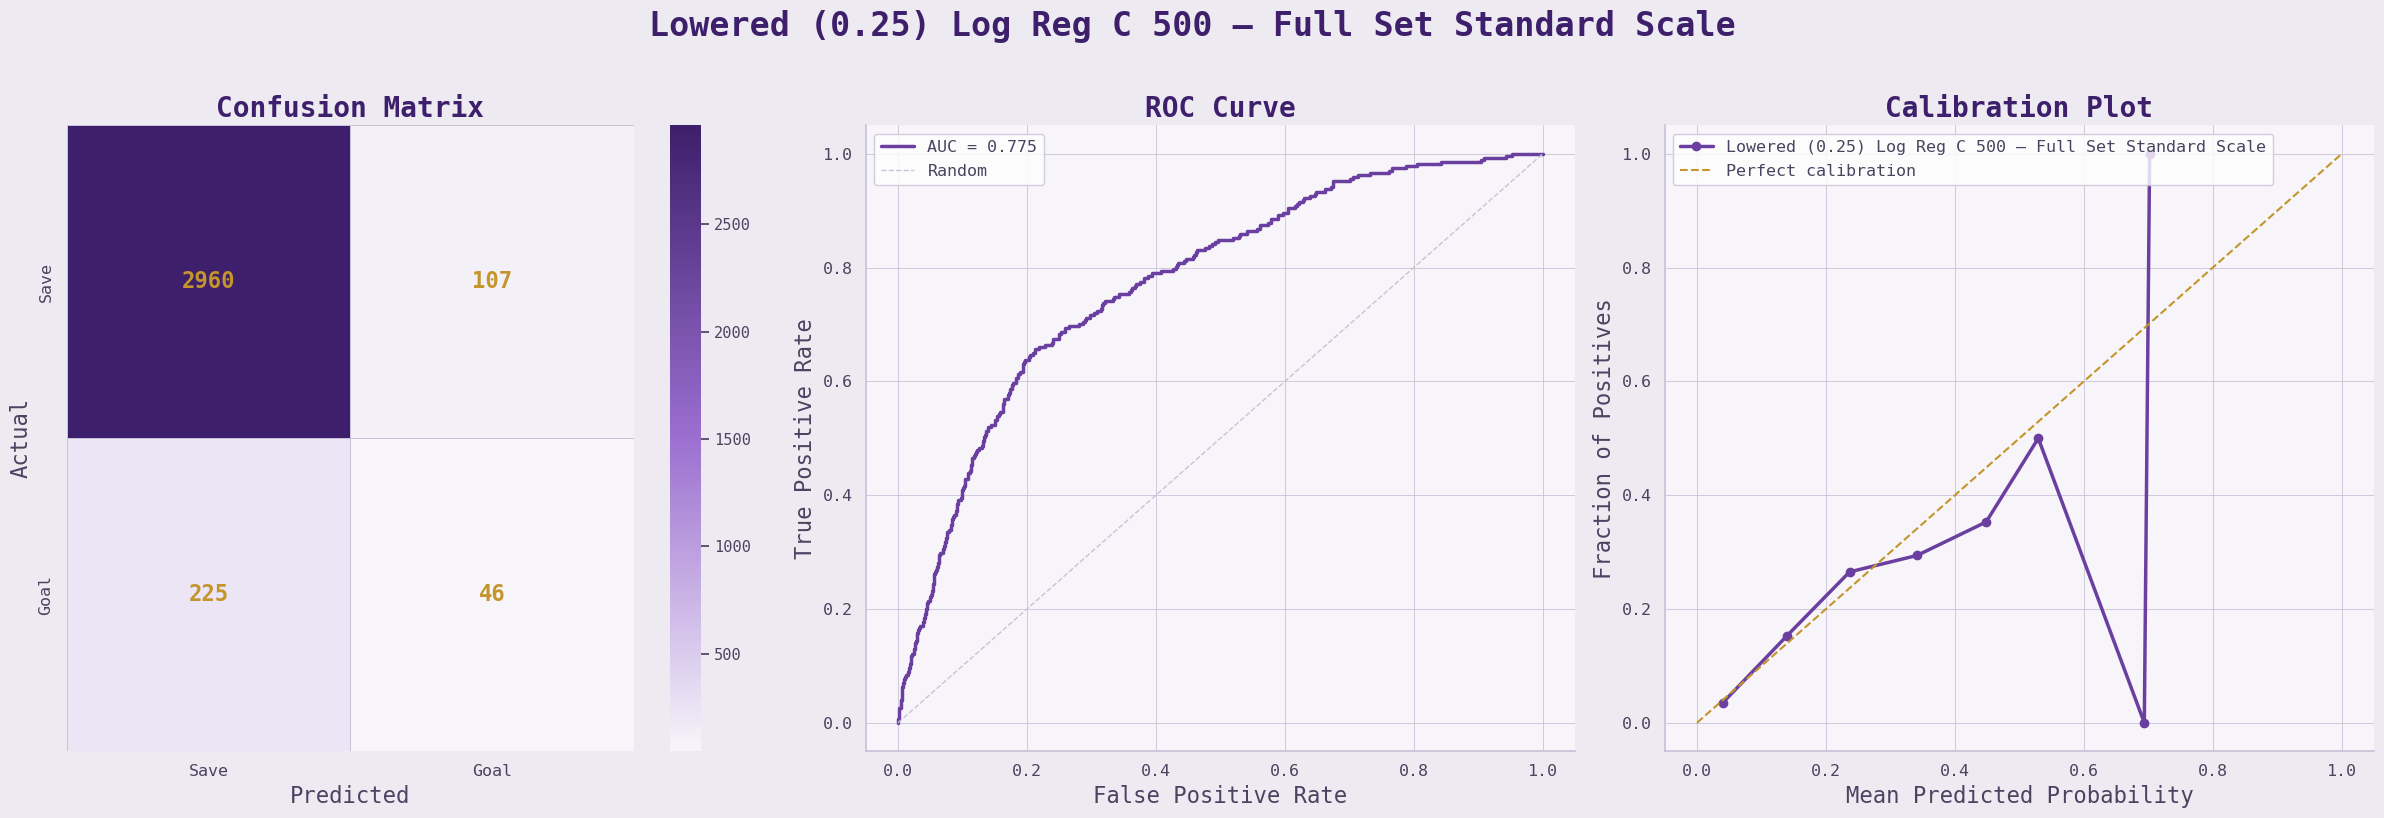

                          feature  coefficient
19                       pass__pp    -2.962083
4                  scale__dist_ft    -1.426229
21                  pass__rebound     1.051623
1                     scale__x_ft    -1.002602
6                scale__arclength    -0.882218
22                 pass__backhand    -0.771656
8   scale__shooter_career_quality     0.745110
16                     pass__tied    -0.729081
15                   pass__losing    -0.669138
3                    scale__y_abs     0.653016
18                       pass__es     0.648216
17                  pass__winning    -0.648173
14             scale__skater_diff     0.517494
27                    pass__wrist    -0.446576
31               pass__is_forward    -0.429287
25                     pass__snap    -0.365513
23                    pass__other    -0.363358
26                      pass__tip    -0.353054
7          scale__shooter_quality    -0.322049
20                       pass__sh     0.267475
24           

In [52]:
# Re-running Lowered (0.25) Log Reg C 500 - Full Set Standard Scale to get its Coefficients
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(C = 500))
])

pipeline.fit(X_train, y_train)
model_eval(pipeline,
           X_test,
           y_test,
           model_name="Lowered (0.25) Log Reg C 500 — Full Set Standard Scale",
           threshold = 0.25)

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
coef_df = pd.DataFrame({
    'feature':     feature_names,
    'coefficient': pipeline.named_steps['model'].coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print(coef_df)

The coefficients for the selected data seems to show that all of the features have some predictive power, although none are particularly strong, leading to lower performing models.

The coefficients for the full data set are more problematic.  `pp` being the strongest indicator, and in a negative direction, seems to skew the data strongly.  Literature on developing NHL xG models suggest creating separate Even Strength, Power Play and Short Handed xG models.  Seeing these coefficients lends credence to that theory.

Also, through the EDA it was shown that the features most correlated to each other were `dist_ft`, `x_ft` and `arc_length`.  Having all of 3 of these in the top 5 of the strongest predictors in the model suggests that multi-colinearity is likely an issue in the full dataset.

It seems necessary that we will need to follow the same processes for an Even Strength specific model, and deal with these issues of multi-colinearity, which will be addressed in the next notebook.

For now, we will move on to a more advanced model keeping the dataset as is to see if an XGBoost model can avoid these issues while developing a more accurate model.

<a id = 'xgboost'></a>

## 3. XGBoost Modelling


  XGBoost - Base
  Baseline (always predict save): 91.87%
  Accuracy:                       91.34%
  AUC:                            0.734
  Log Loss:                       0.279
  Avg Precision (PR-AUC):         0.185

              precision    recall  f1-score   support

        Save       0.92      0.99      0.95      3067
        Goal       0.24      0.03      0.05       271

    accuracy                           0.91      3338
   macro avg       0.58      0.51      0.50      3338
weighted avg       0.86      0.91      0.88      3338



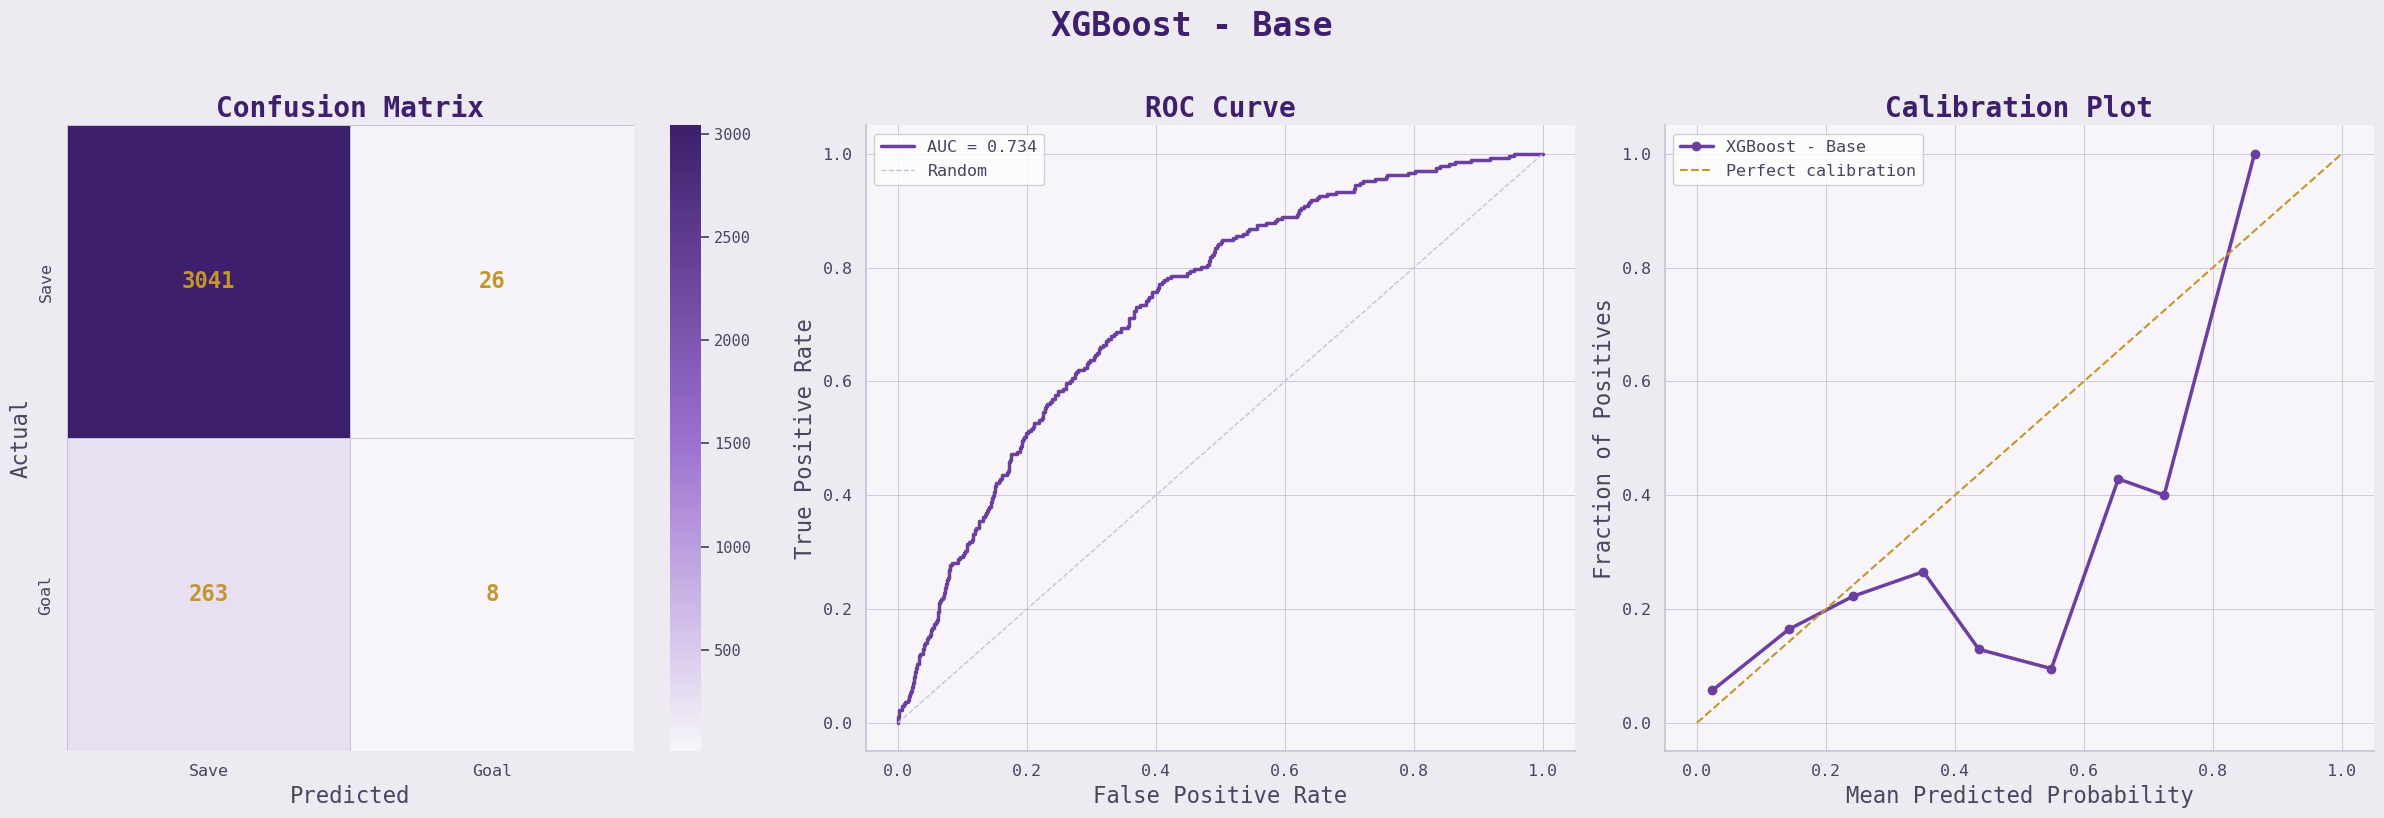

In [53]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss')

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Base")

This is a more promising start compared to the Logistic Regression models.  The AUC is lower, but the base model is already predicting more goals, albeit still a small number.

The first adjustment I want to make is to address the class imbalance.  I'll try a weighting that reflects the mismatch in the classes, and then try to strengthen and weaken the weighting.

In [54]:
# Classifying the default weight as the proportion of Saves to Goals
weight = len(y_train[y_train==0]) / len(y_train[y_train==1])


  XGBoost - Weighted
  Baseline (always predict save): 91.87%
  Accuracy:                       85.83%
  AUC:                            0.732
  Log Loss:                       0.333
  Avg Precision (PR-AUC):         0.185

              precision    recall  f1-score   support

        Save       0.94      0.91      0.92      3067
        Goal       0.23      0.31      0.26       271

    accuracy                           0.86      3338
   macro avg       0.58      0.61      0.59      3338
weighted avg       0.88      0.86      0.87      3338



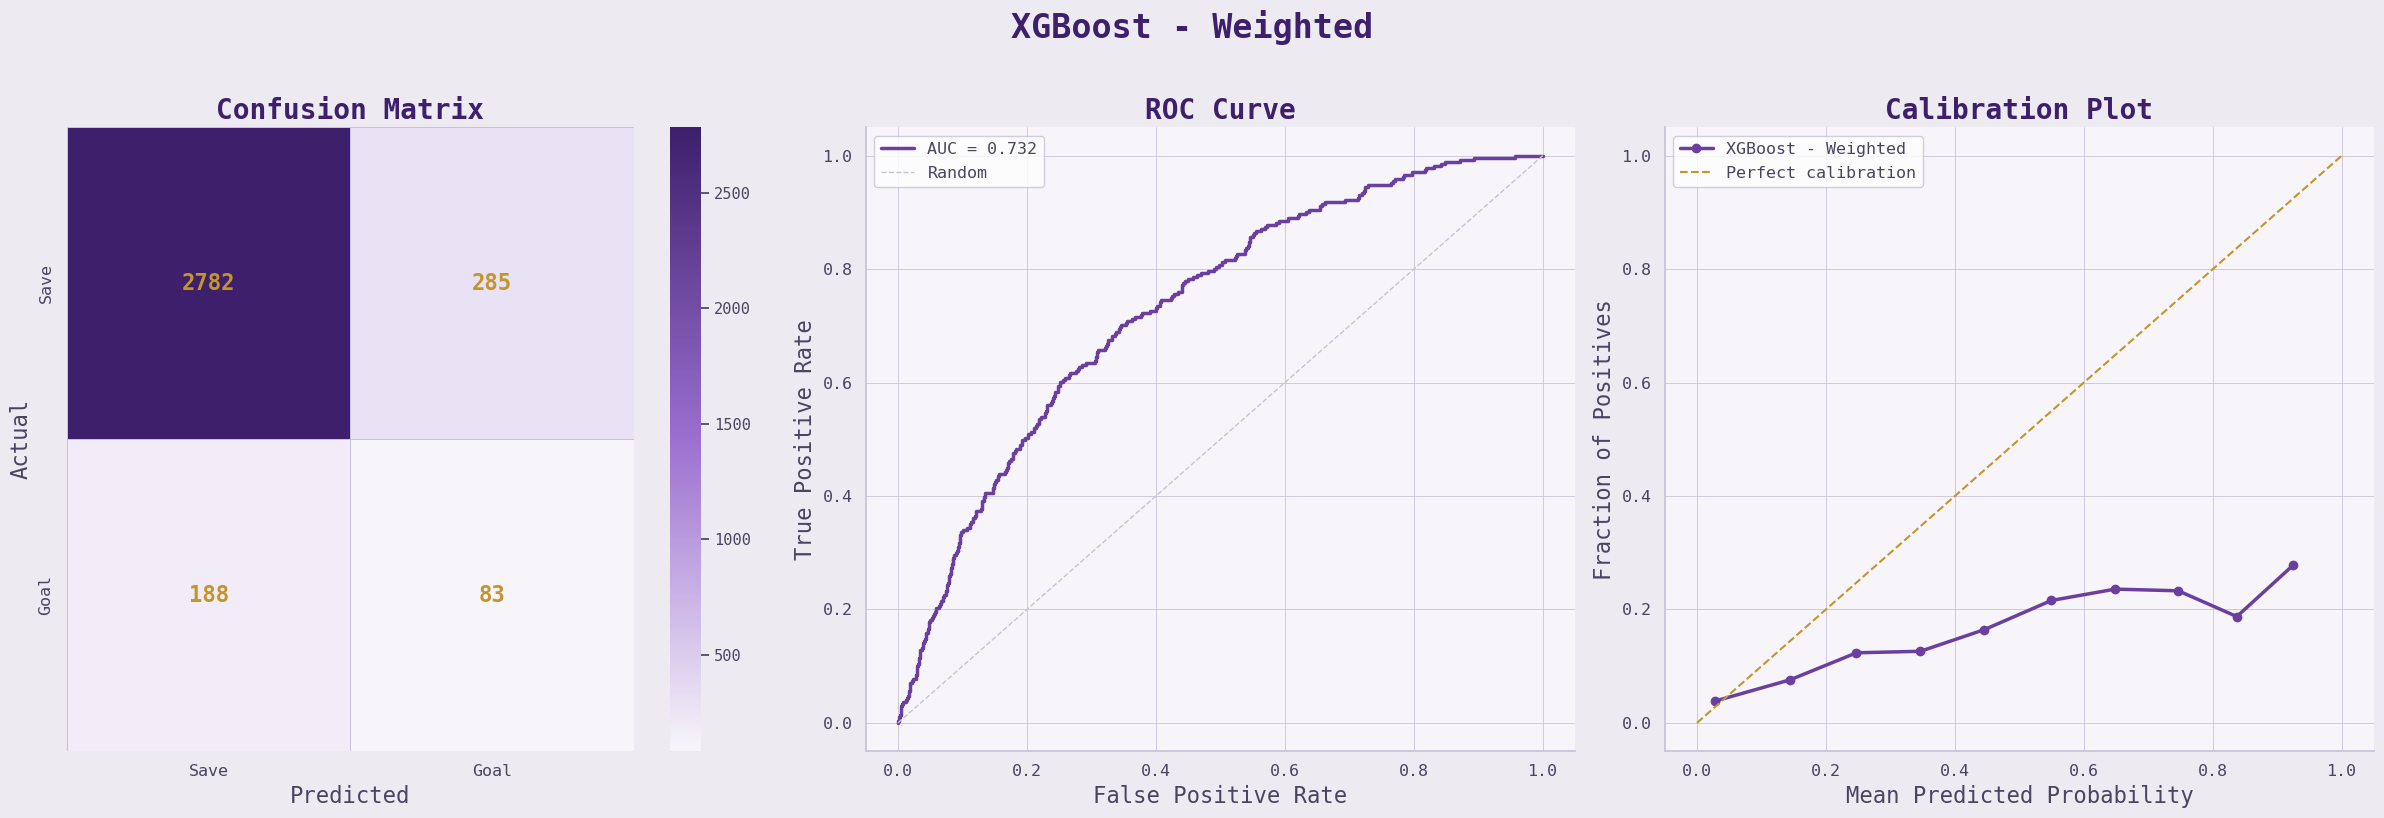

In [55]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=weight)

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Weighted")


  XGBoost - Weighted Doubled
  Baseline (always predict save): 91.87%
  Accuracy:                       83.19%
  AUC:                            0.721
  Log Loss:                       0.383
  Avg Precision (PR-AUC):         0.171

              precision    recall  f1-score   support

        Save       0.94      0.87      0.91      3067
        Goal       0.20      0.36      0.26       271

    accuracy                           0.83      3338
   macro avg       0.57      0.62      0.58      3338
weighted avg       0.88      0.83      0.85      3338



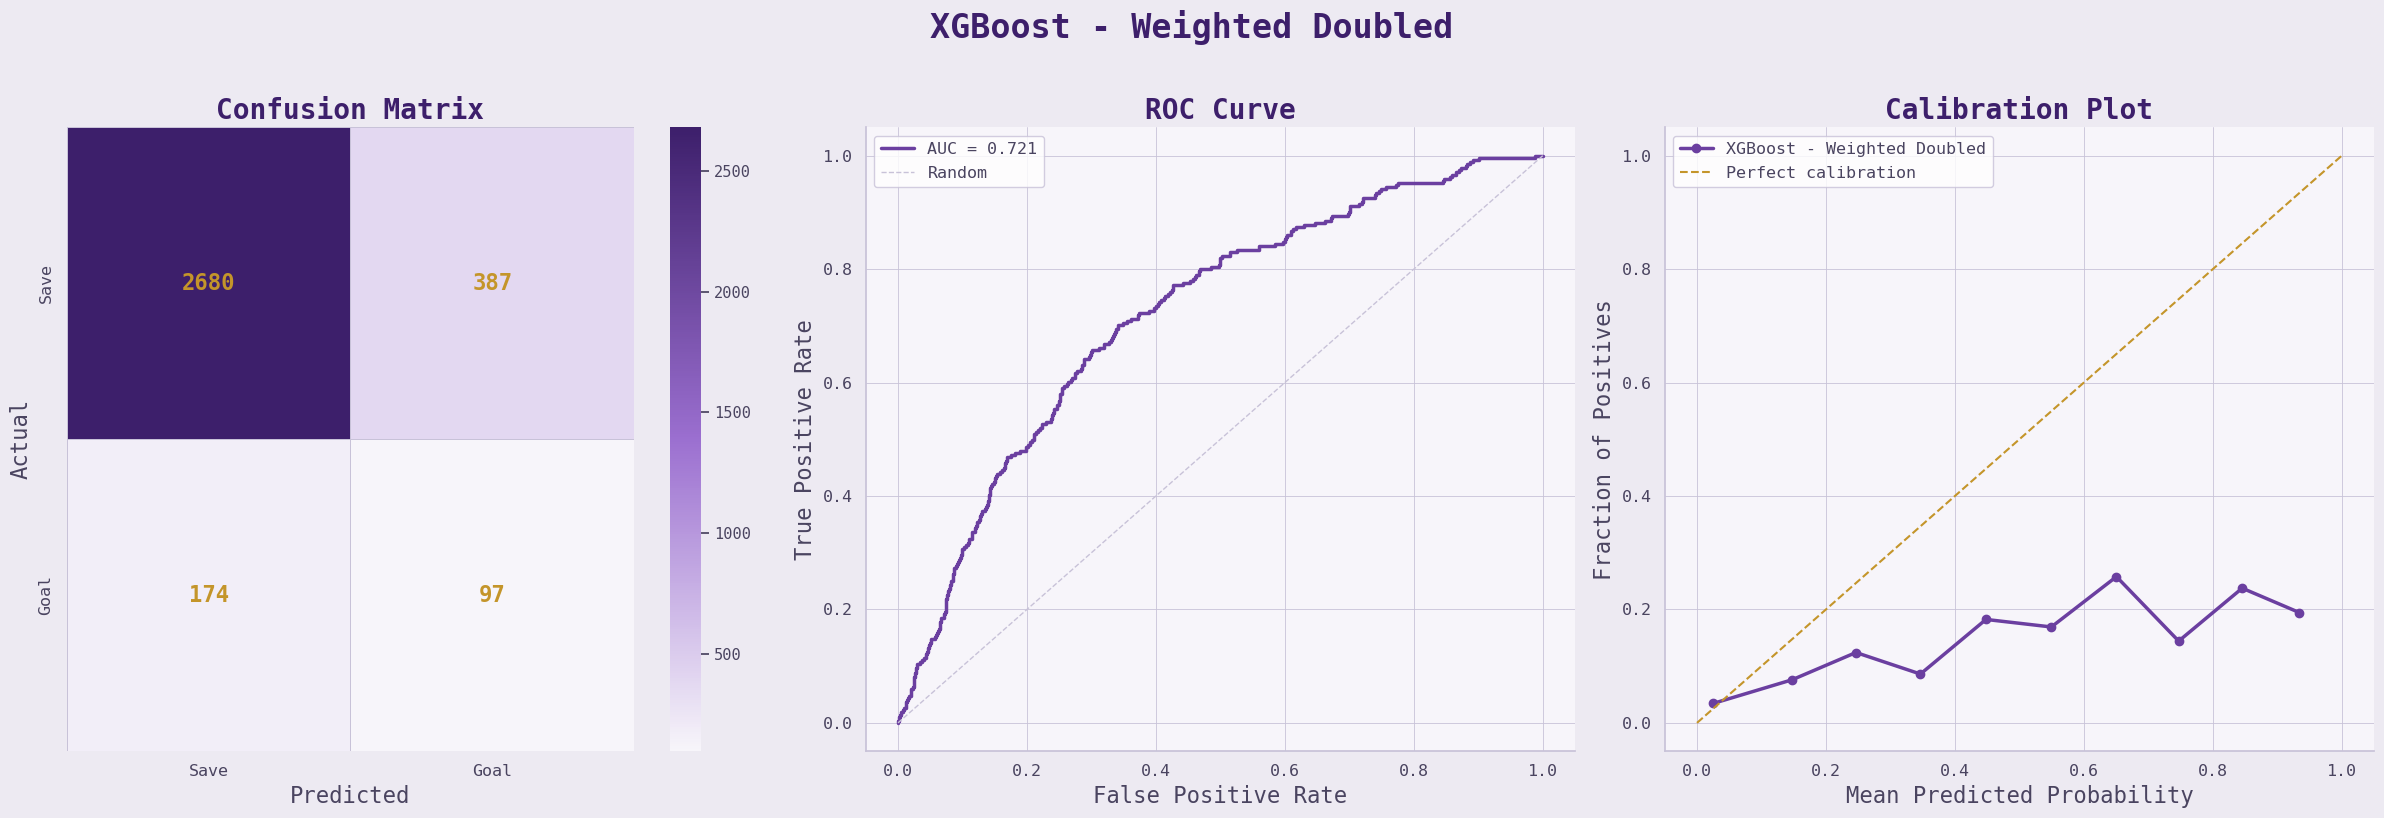

In [56]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=weight*2)

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Weighted Doubled")


  XGBoost - Weighted Halved
  Baseline (always predict save): 91.87%
  Accuracy:                       88.44%
  AUC:                            0.719
  Log Loss:                       0.303
  Avg Precision (PR-AUC):         0.184

              precision    recall  f1-score   support

        Save       0.93      0.95      0.94      3067
        Goal       0.21      0.15      0.18       271

    accuracy                           0.88      3338
   macro avg       0.57      0.55      0.56      3338
weighted avg       0.87      0.88      0.88      3338



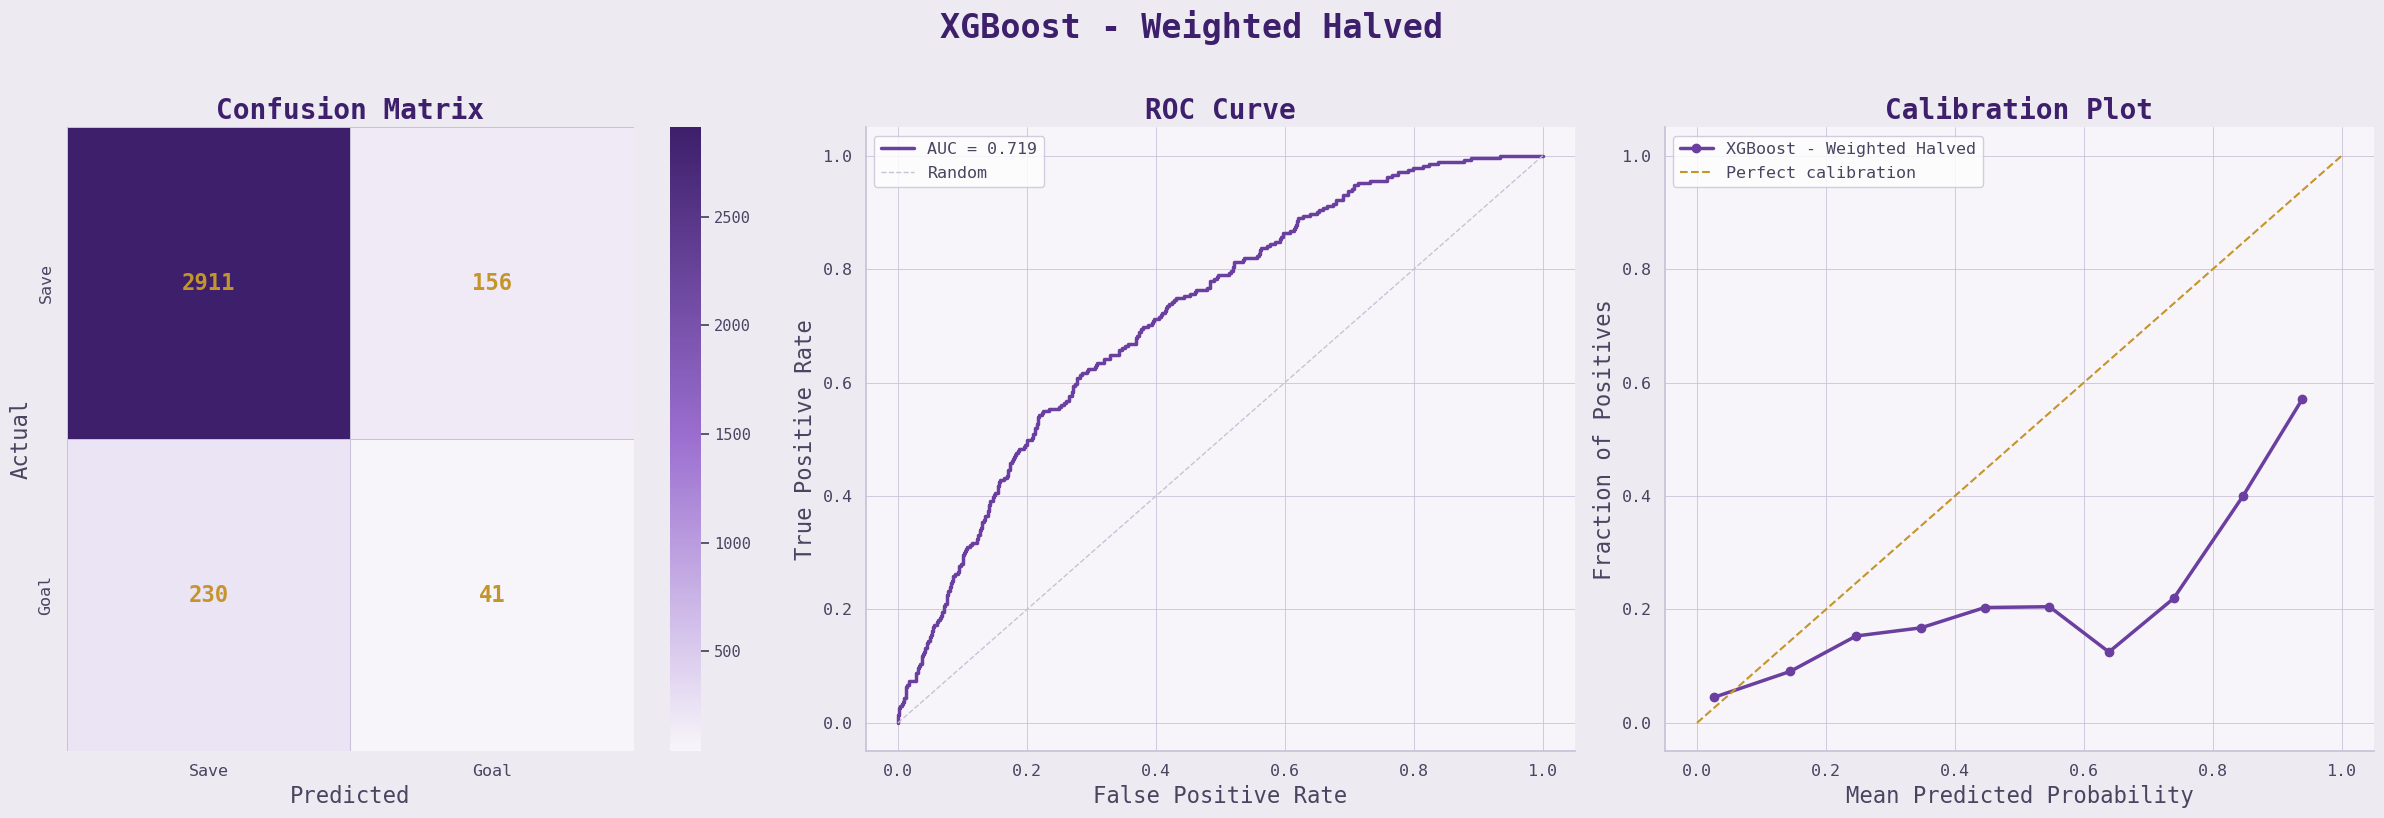

In [57]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=weight/2)

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Weighted Halved")

Adding the weight did produce more goal predictions, but struggled to find a balance in improving the model performance.  Using the default weight looked to add more goal predictions with a minimal loss in AUC, but Log Loss was more significant.  Cutting the weight in half minimized the decrease in Log Loss, but lost more on fewer goal predictions, lower AUC and lower overall accuracy.

Next, we'll look at how the Selected Data performs on a base XGBoost model, and then add weights to it.


  XGBoost - Selected Data
  Baseline (always predict save): 91.87%
  Accuracy:                       91.34%
  AUC:                            0.678
  Log Loss:                       0.285
  Avg Precision (PR-AUC):         0.149

              precision    recall  f1-score   support

        Save       0.92      0.99      0.95      3067
        Goal       0.18      0.02      0.03       271

    accuracy                           0.91      3338
   macro avg       0.55      0.51      0.49      3338
weighted avg       0.86      0.91      0.88      3338



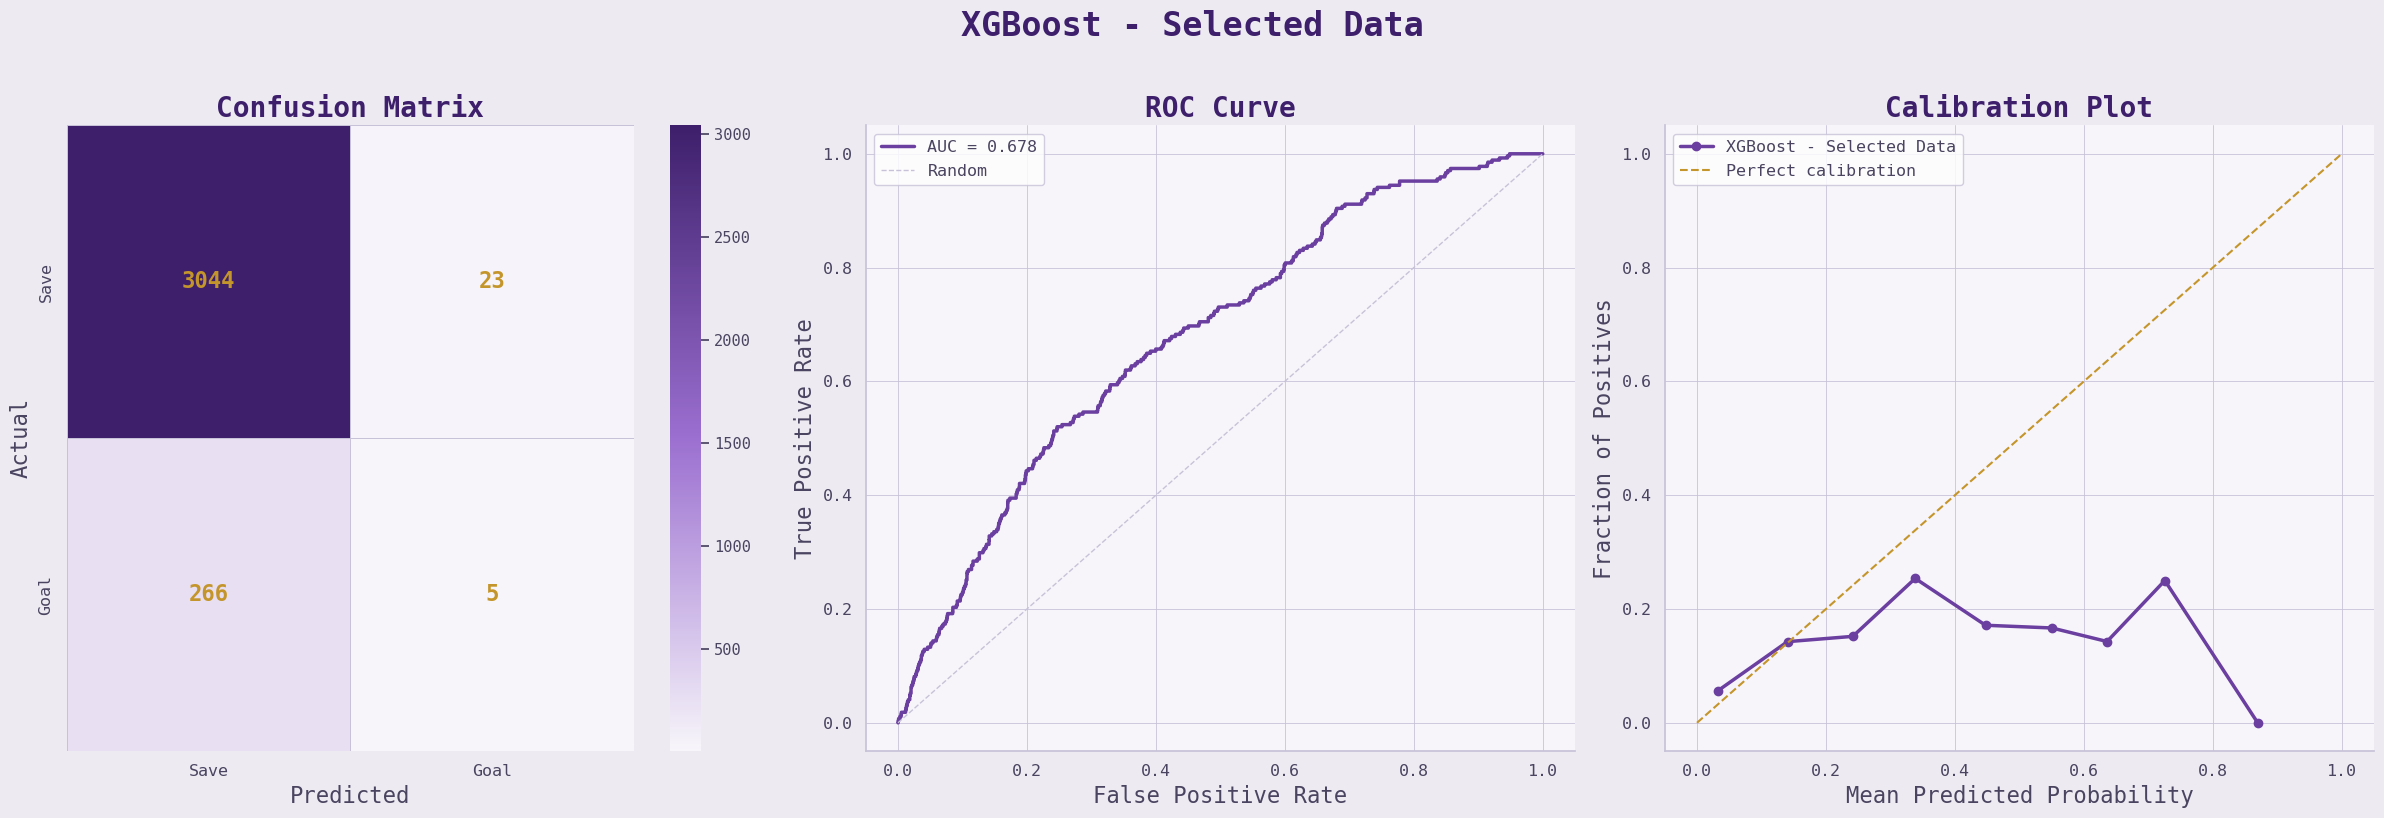

In [58]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss')

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Data")


  XGBoost - Selected Weighted
  Baseline (always predict save): 91.87%
  Accuracy:                       79.78%
  AUC:                            0.66
  Log Loss:                       0.434
  Avg Precision (PR-AUC):         0.135

              precision    recall  f1-score   support

        Save       0.93      0.84      0.88      3067
        Goal       0.15      0.33      0.21       271

    accuracy                           0.80      3338
   macro avg       0.54      0.59      0.55      3338
weighted avg       0.87      0.80      0.83      3338



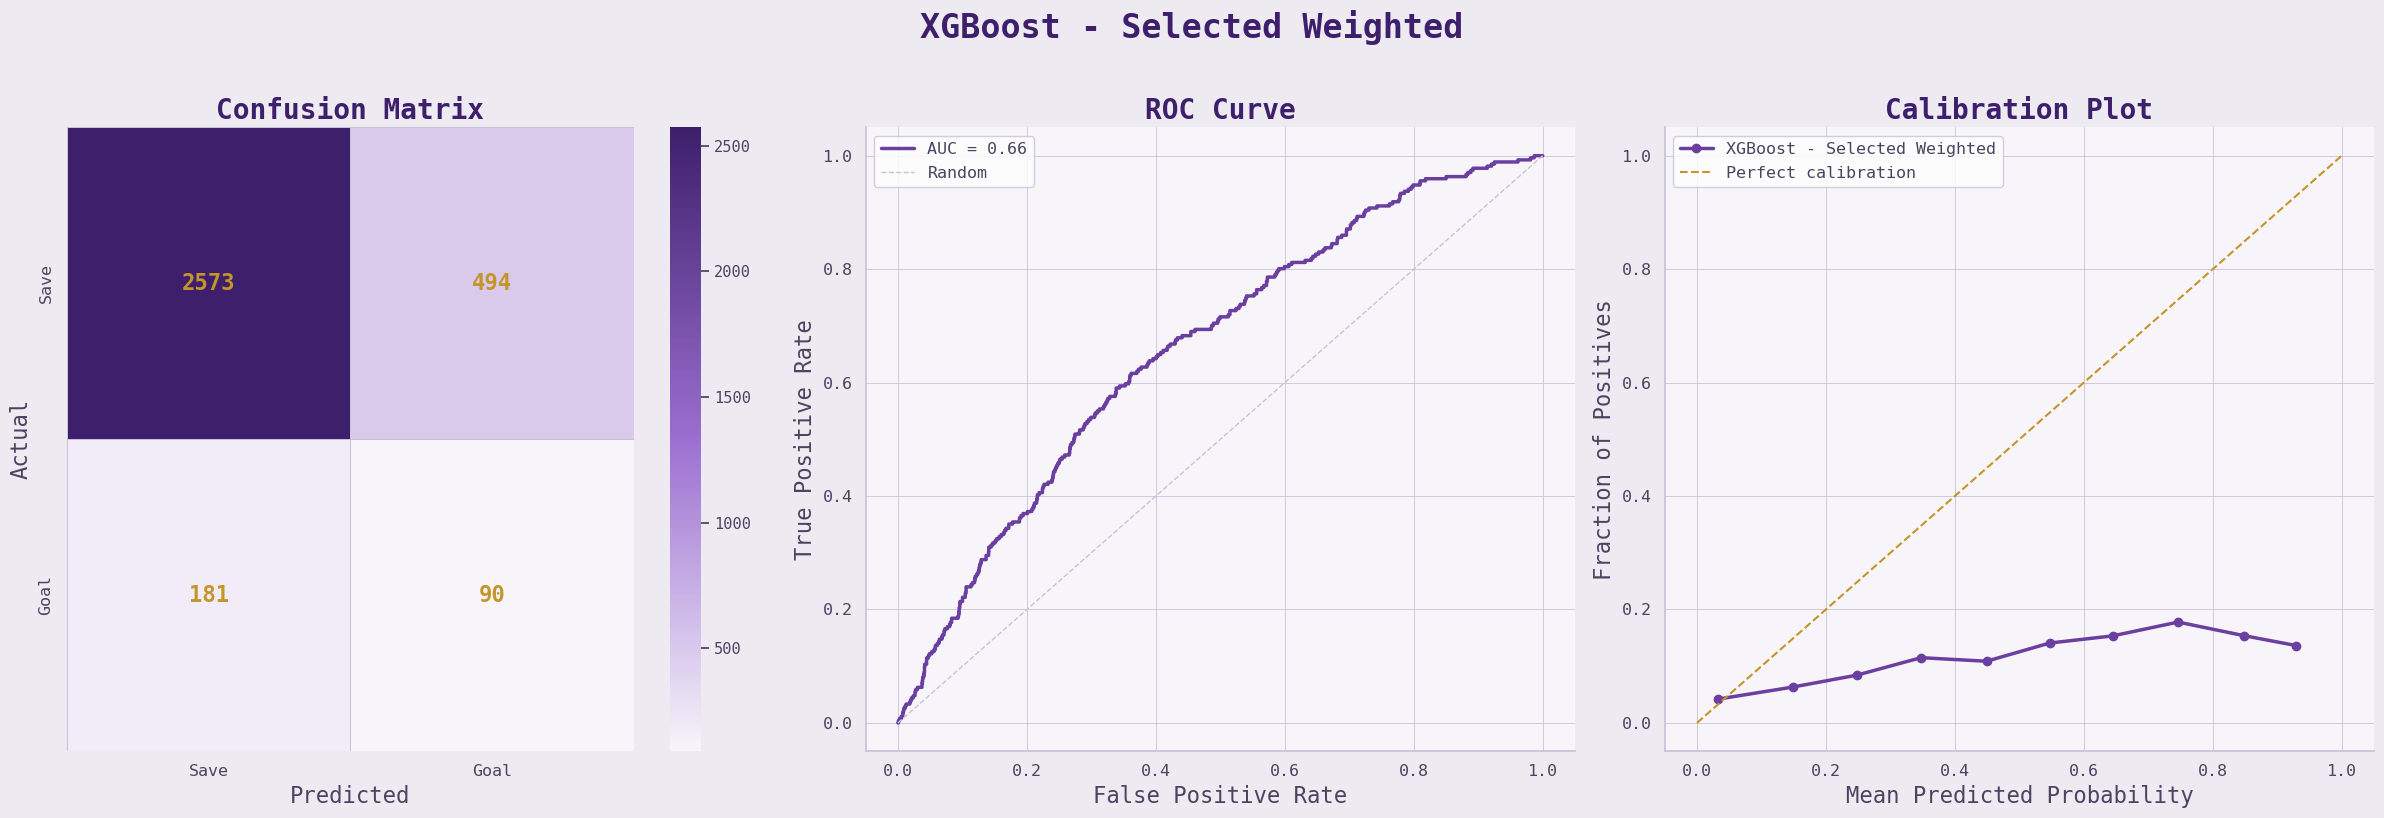

In [59]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=weight)

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Weighted")


  XGBoost - Selected Weighted Doubled
  Baseline (always predict save): 91.87%
  Accuracy:                       71.87%
  AUC:                            0.653
  Log Loss:                       0.542
  Avg Precision (PR-AUC):         0.14

              precision    recall  f1-score   support

        Save       0.94      0.74      0.83      3067
        Goal       0.13      0.44      0.20       271

    accuracy                           0.72      3338
   macro avg       0.53      0.59      0.52      3338
weighted avg       0.87      0.72      0.78      3338



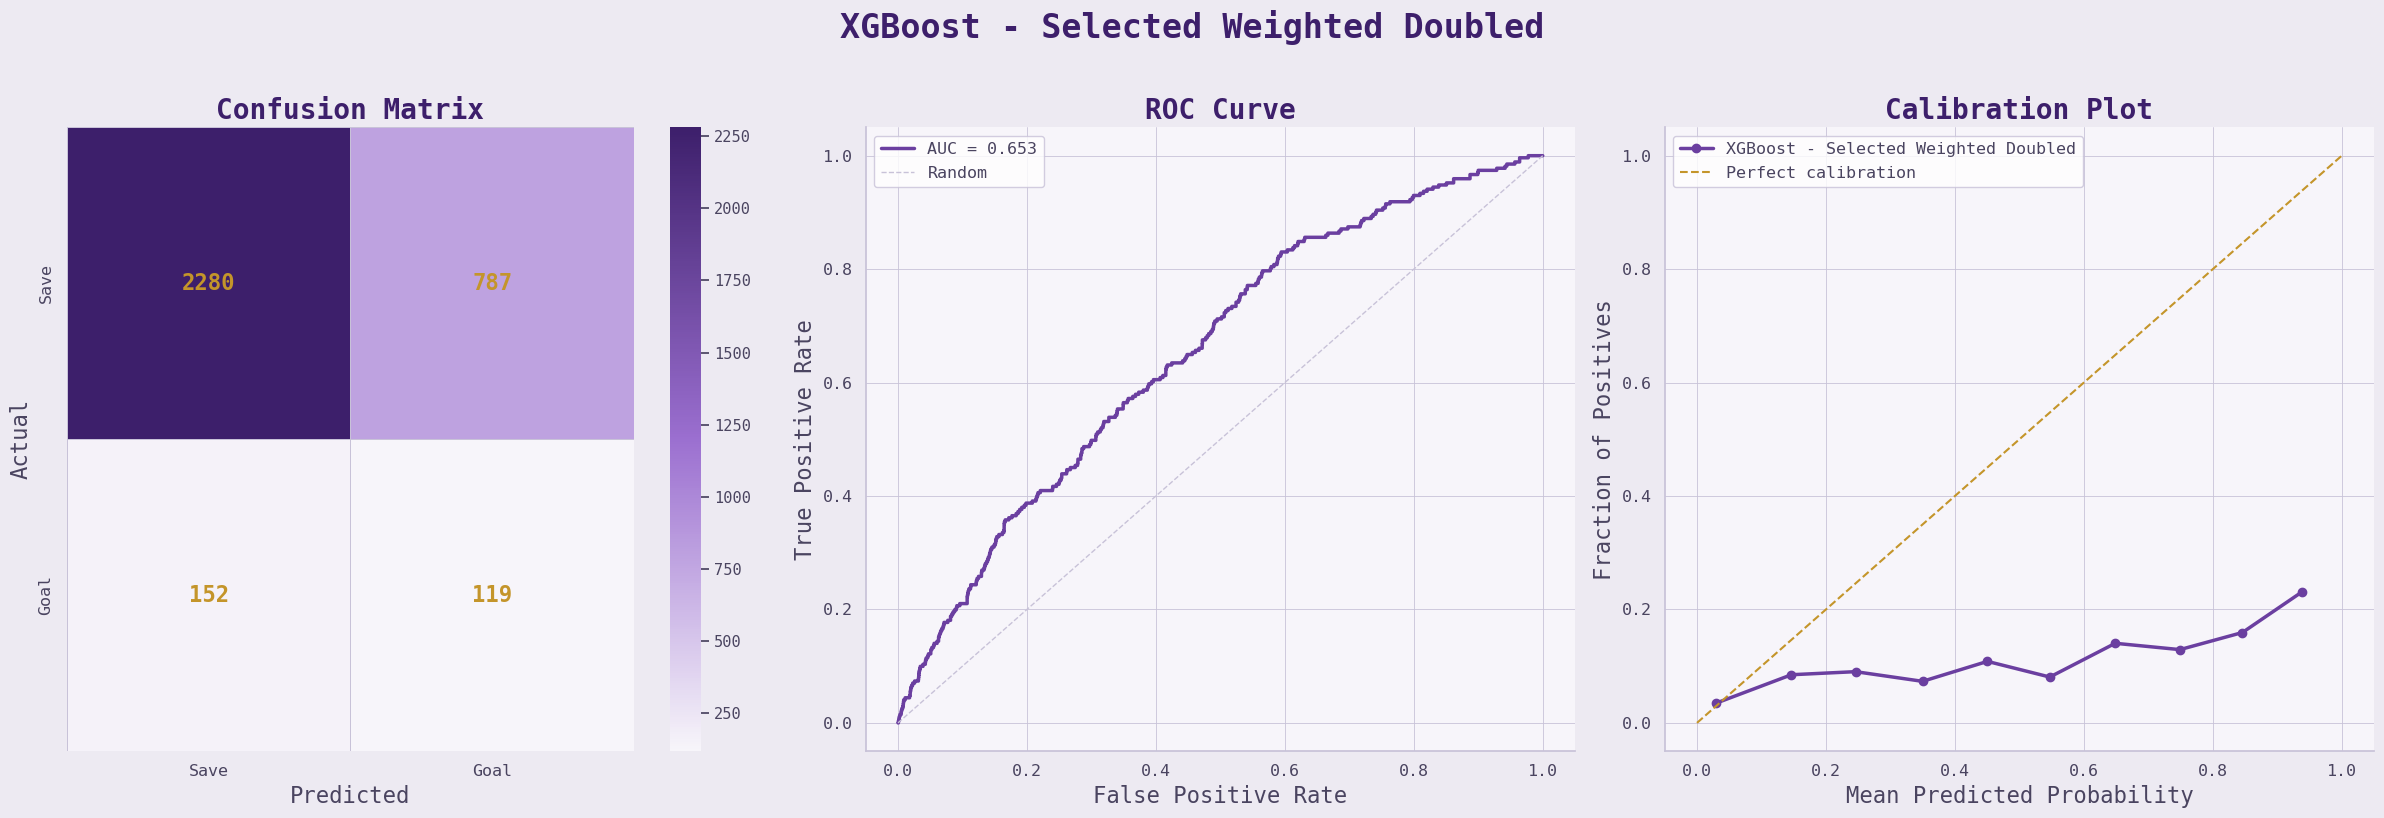

In [60]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=weight*2)

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Weighted Doubled")


  XGBoost - Selected Weighted Halved
  Baseline (always predict save): 91.87%
  Accuracy:                       85.71%
  AUC:                            0.677
  Log Loss:                       0.355
  Avg Precision (PR-AUC):         0.153

              precision    recall  f1-score   support

        Save       0.93      0.91      0.92      3067
        Goal       0.19      0.23      0.21       271

    accuracy                           0.86      3338
   macro avg       0.56      0.57      0.56      3338
weighted avg       0.87      0.86      0.86      3338



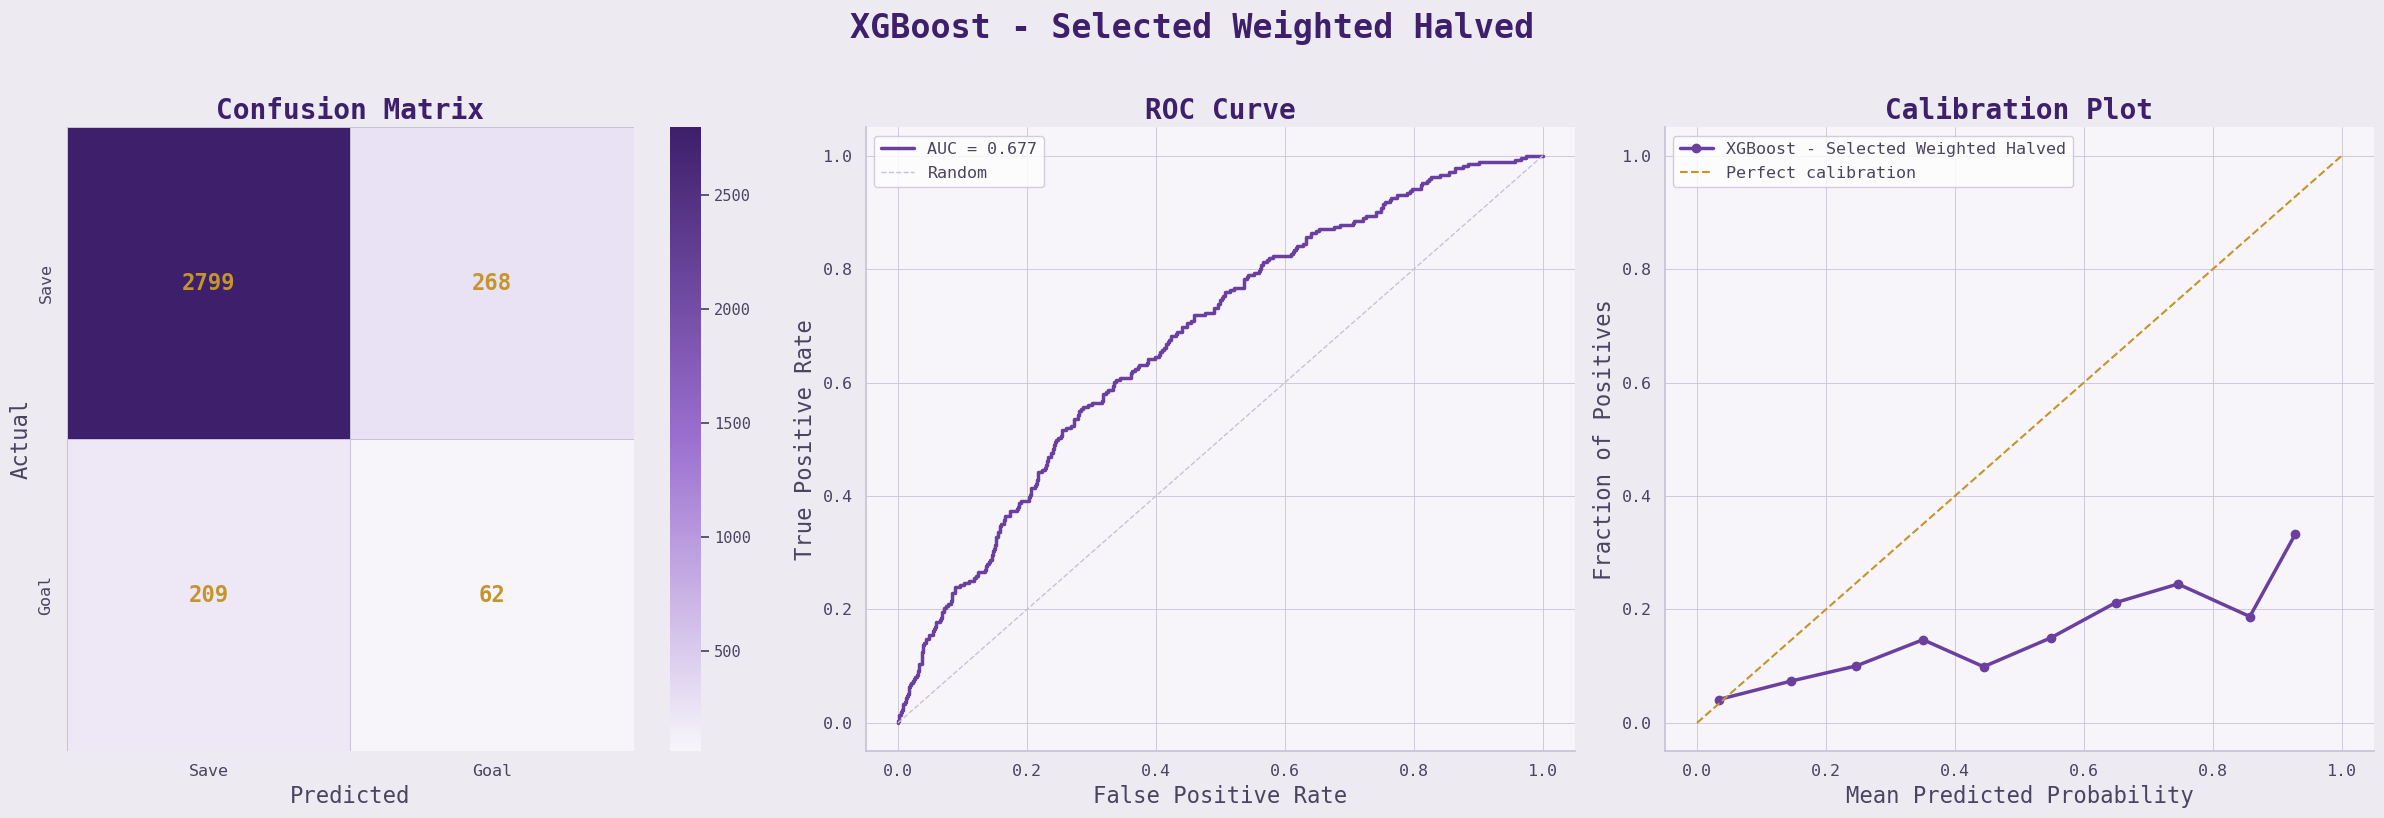

In [61]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=weight/2)

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Weighted Halved")

Halving the weight for the Selected dataset seemed to have the best effect on these versions, but all of them performed much lower than the full dataset, and all of the Logistic Regression models.

Now we will tune these models to a number of parameters.  First we will tune them with no weighting, and then we will increase the parameter grid to include the weighting as part of the tuning.

In [62]:
param_grid = {
    'n_estimators':  [100, 200, 300, 400, 500],
    'max_depth':     [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample':     [0.5, 0.6, 0.7, 0.8],
}

grid = GridSearchCV(xgb, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6} 0.7707071750757561



  XGBoost - Full Tuned Unweighted
  Baseline (always predict save): 91.87%
  Accuracy:                       91.91%
  AUC:                            0.775
  Log Loss:                       0.244
  Avg Precision (PR-AUC):         0.236

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.56      0.02      0.04       271

    accuracy                           0.92      3338
   macro avg       0.74      0.51      0.50      3338
weighted avg       0.89      0.92      0.88      3338



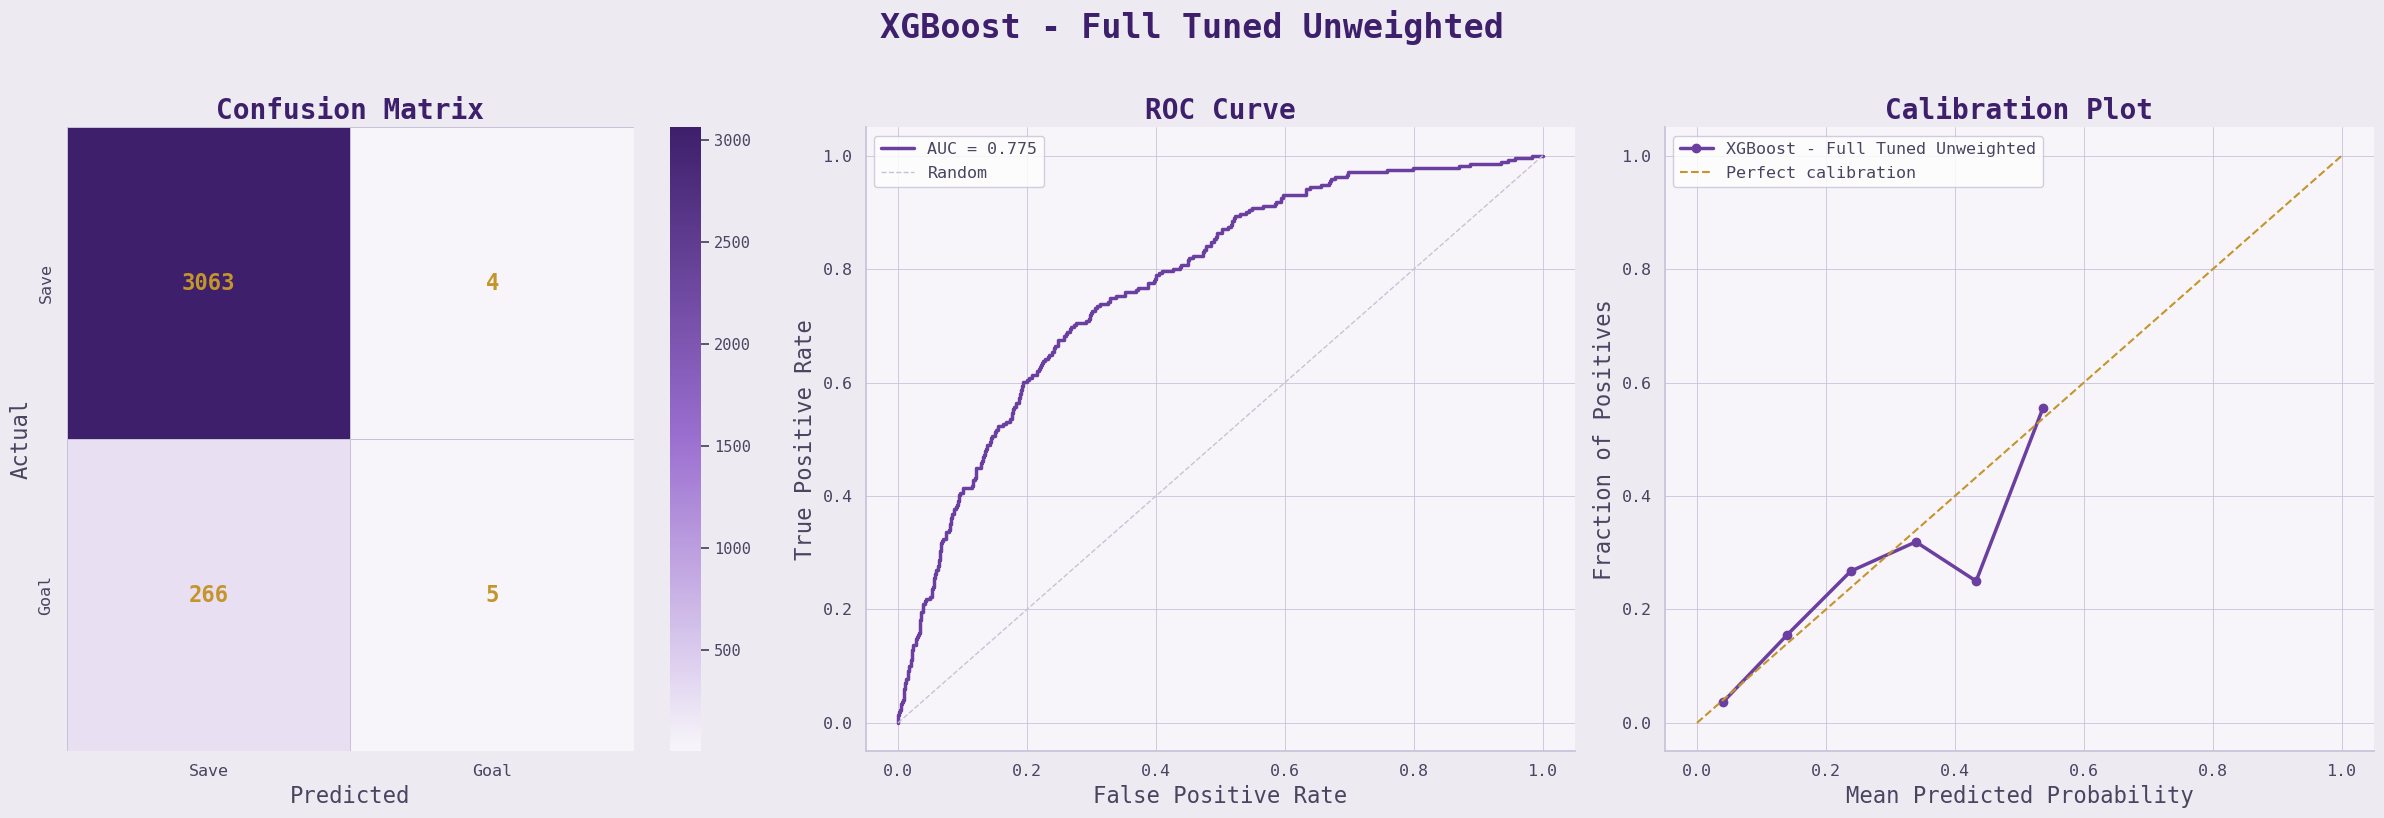

In [63]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 200,
                    max_depth = 3,
                    learning_rate = 0.05,
                    subsample = 0.6)

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Full Tuned Unweighted")

In [64]:
param_grid = {
    'n_estimators':  [100, 200, 300, 400, 500],
    'max_depth':     [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample':     [0.5, 0.6, 0.7, 0.8],
}

grid = GridSearchCV(xgb, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid.fit(X_train[selected_cols], y_train)
print(grid.best_params_, grid.best_score_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.5} 0.729408173195241



  XGBoost - Selected Tuned Unweighted
  Baseline (always predict save): 91.87%
  Accuracy:                       91.88%
  AUC:                            0.719
  Log Loss:                       0.259
  Avg Precision (PR-AUC):         0.185

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.00      0.00      0.00       271

    accuracy                           0.92      3338
   macro avg       0.46      0.50      0.48      3338
weighted avg       0.84      0.92      0.88      3338



/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

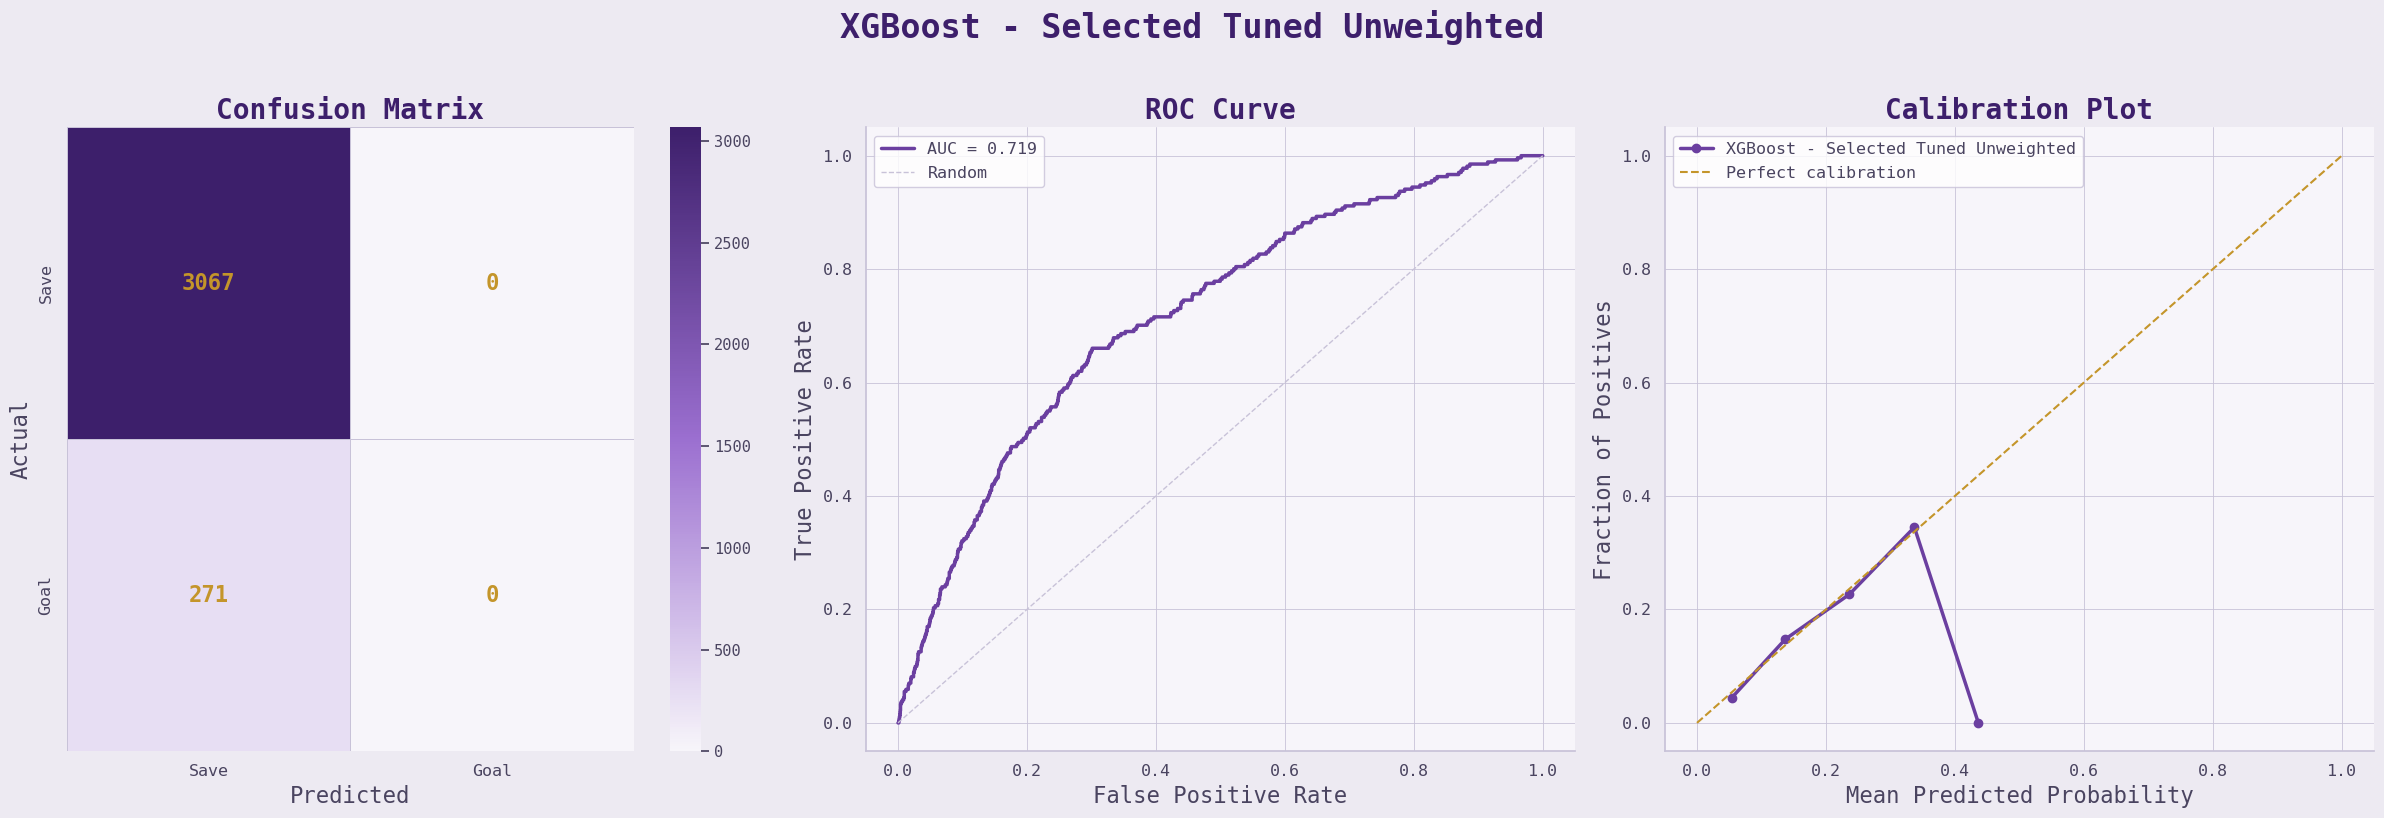

In [65]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 300,
                    max_depth = 3,
                    learning_rate = 0.01,
                    subsample = 0.5)

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Tuned Unweighted")

In [66]:
param_grid = {
    'n_estimators':  [100, 200, 300, 400, 500],
    'max_depth':     [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample':     [0.5, 0.6, 0.7, 0.8],
    'scale_pos_weight': [weight, weight*2, weight/2]
}

grid = GridSearchCV(xgb, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 5.652073732718894, 'subsample': 0.6} 0.7707071750757561



  XGBoost - Full Tuned Weighted
  Baseline (always predict save): 91.87%
  Accuracy:                       84.84%
  AUC:                            0.772
  Log Loss:                       0.376
  Avg Precision (PR-AUC):         0.229

              precision    recall  f1-score   support

        Save       0.95      0.89      0.91      3067
        Goal       0.25      0.43      0.32       271

    accuracy                           0.85      3338
   macro avg       0.60      0.66      0.62      3338
weighted avg       0.89      0.85      0.87      3338



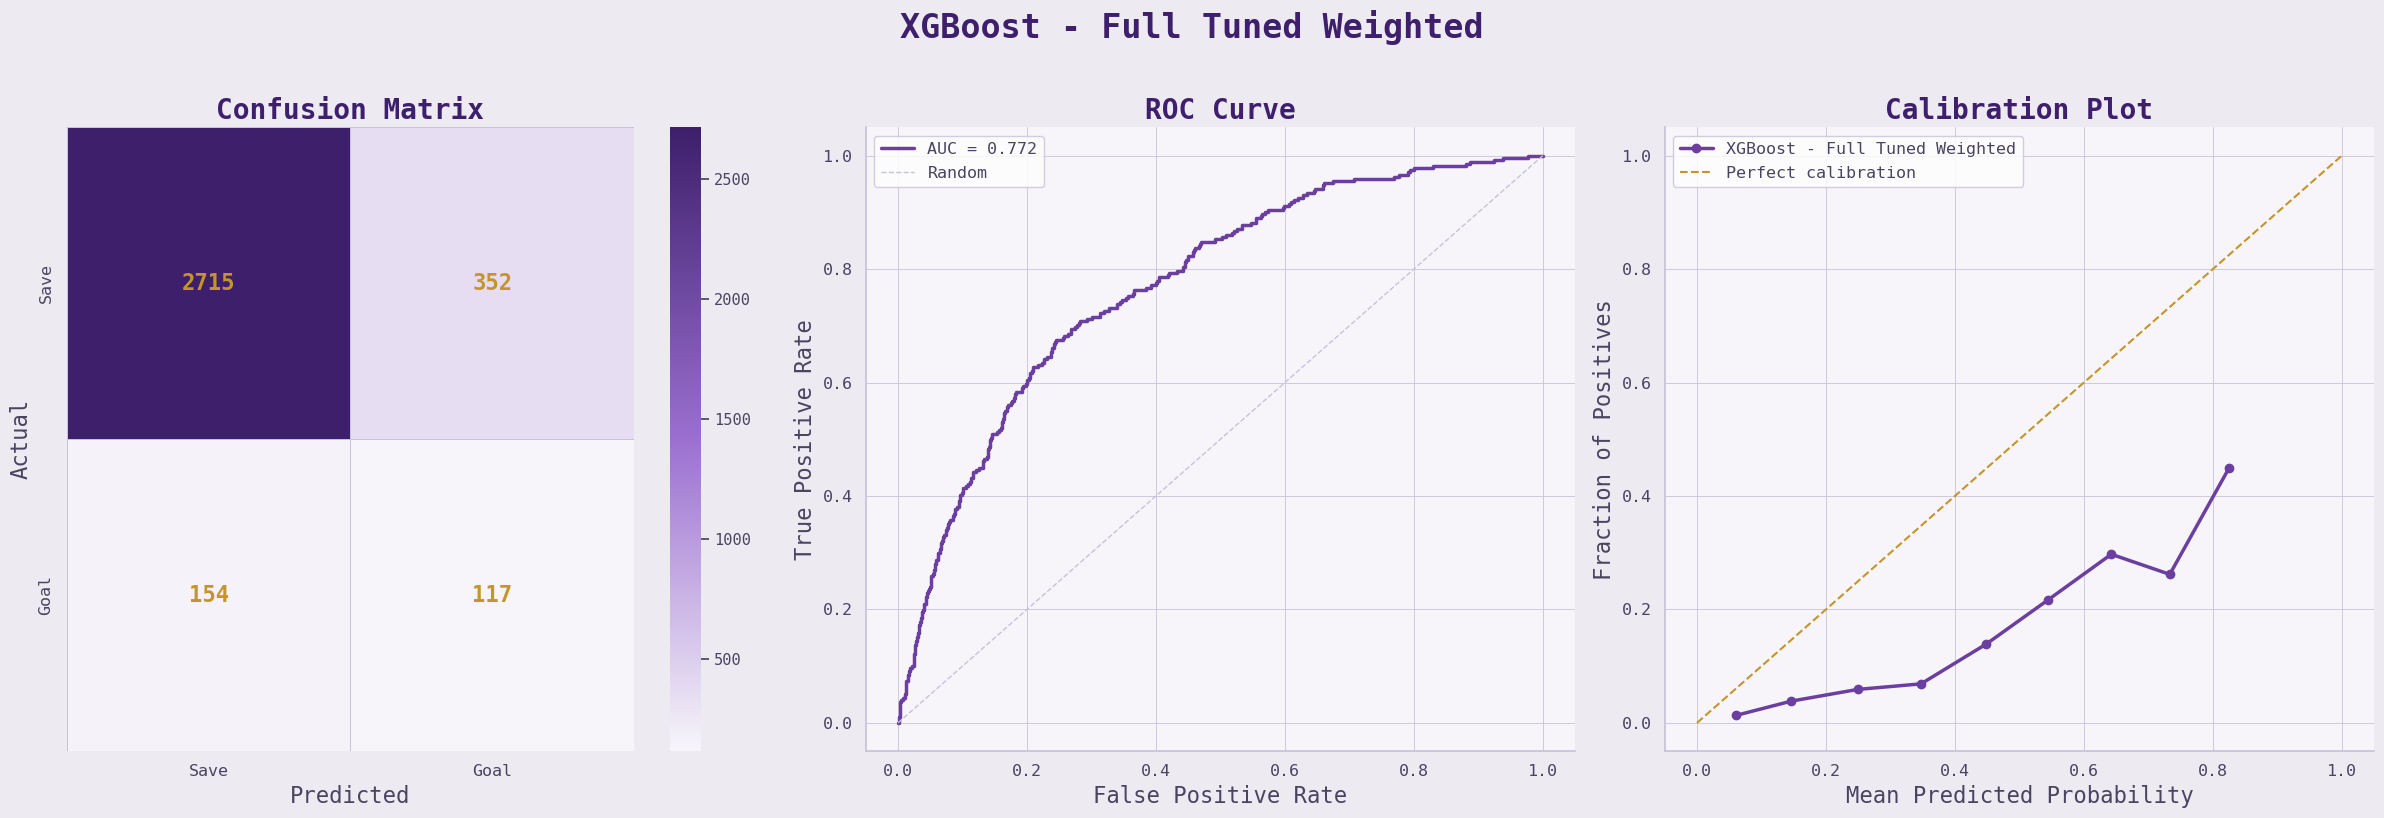

In [67]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 200,
                    max_depth = 3,
                    learning_rate = 0.05,
                    scale_pos_weight = weight/2,
                    subsample = 0.6)

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Full Tuned Weighted")

In [68]:
param_grid = {
    'n_estimators':  [100, 200, 300, 400, 500],
    'max_depth':     [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample':     [0.5, 0.6, 0.7, 0.8],
    'scale_pos_weight': [weight, weight*2, weight/2]
}

grid = GridSearchCV(xgb, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid.fit(X_train[selected_cols], y_train)
print(grid.best_params_, grid.best_score_)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 5.652073732718894, 'subsample': 0.5} 0.729652583782484



  XGBoost - Selected Tuned Weighted
  Baseline (always predict save): 91.87%
  Accuracy:                       86.22%
  AUC:                            0.72
  Log Loss:                       0.413
  Avg Precision (PR-AUC):         0.183

              precision    recall  f1-score   support

        Save       0.93      0.91      0.92      3067
        Goal       0.22      0.27      0.24       271

    accuracy                           0.86      3338
   macro avg       0.58      0.59      0.58      3338
weighted avg       0.88      0.86      0.87      3338



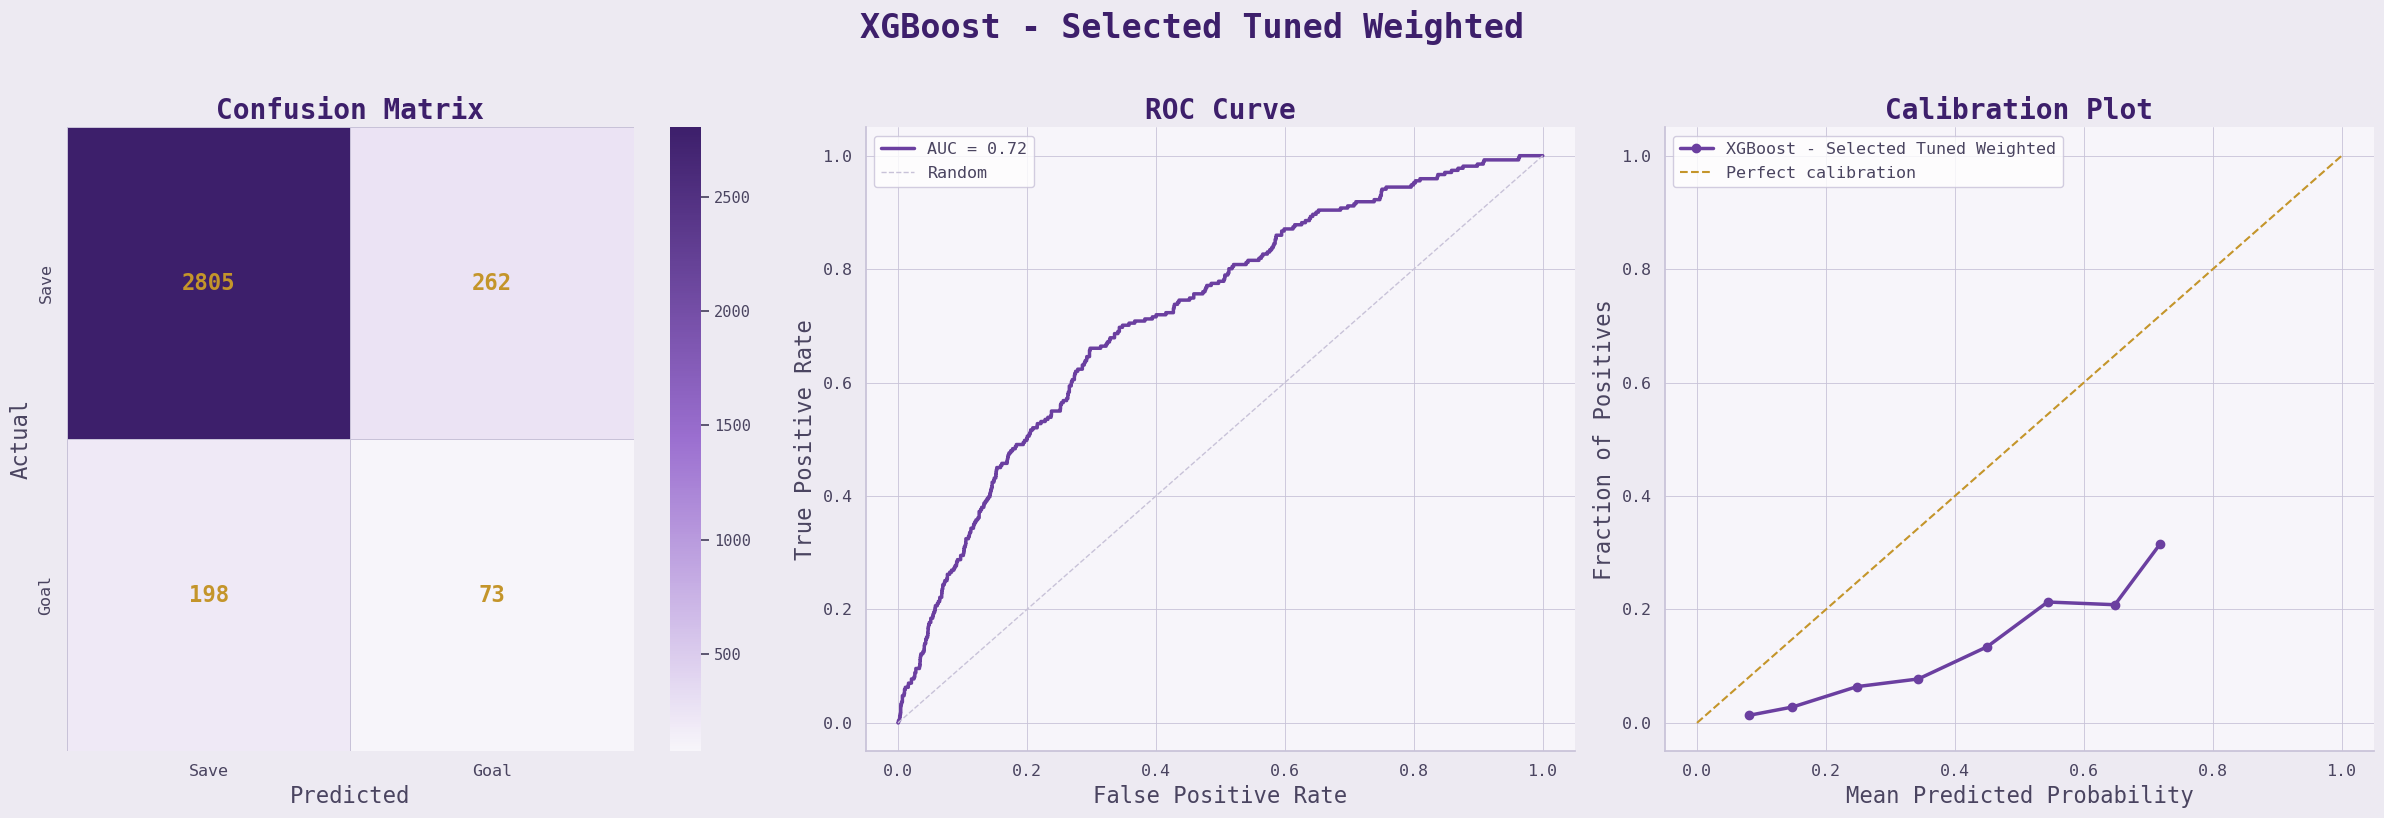

In [69]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 300,
                    max_depth = 3,
                    learning_rate = 0.01,
                    scale_pos_weight = weight/2,
                    subsample = 0.5)

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Tuned Weighted")

With the optimal tuning and weighting known, we can revisit these models and lower the threshold to see if anything more can be done to improve the models.


  Lowered (0.25) XGBoost - Full Tuned Unweighted
  Baseline (always predict save): 91.87%
  Accuracy:                       90.26%
  AUC:                            0.775
  Log Loss:                       0.244
  Avg Precision (PR-AUC):         0.236

              precision    recall  f1-score   support

        Save       0.93      0.97      0.95      3067
        Goal       0.30      0.15      0.20       271

    accuracy                           0.90      3338
   macro avg       0.61      0.56      0.57      3338
weighted avg       0.88      0.90      0.89      3338



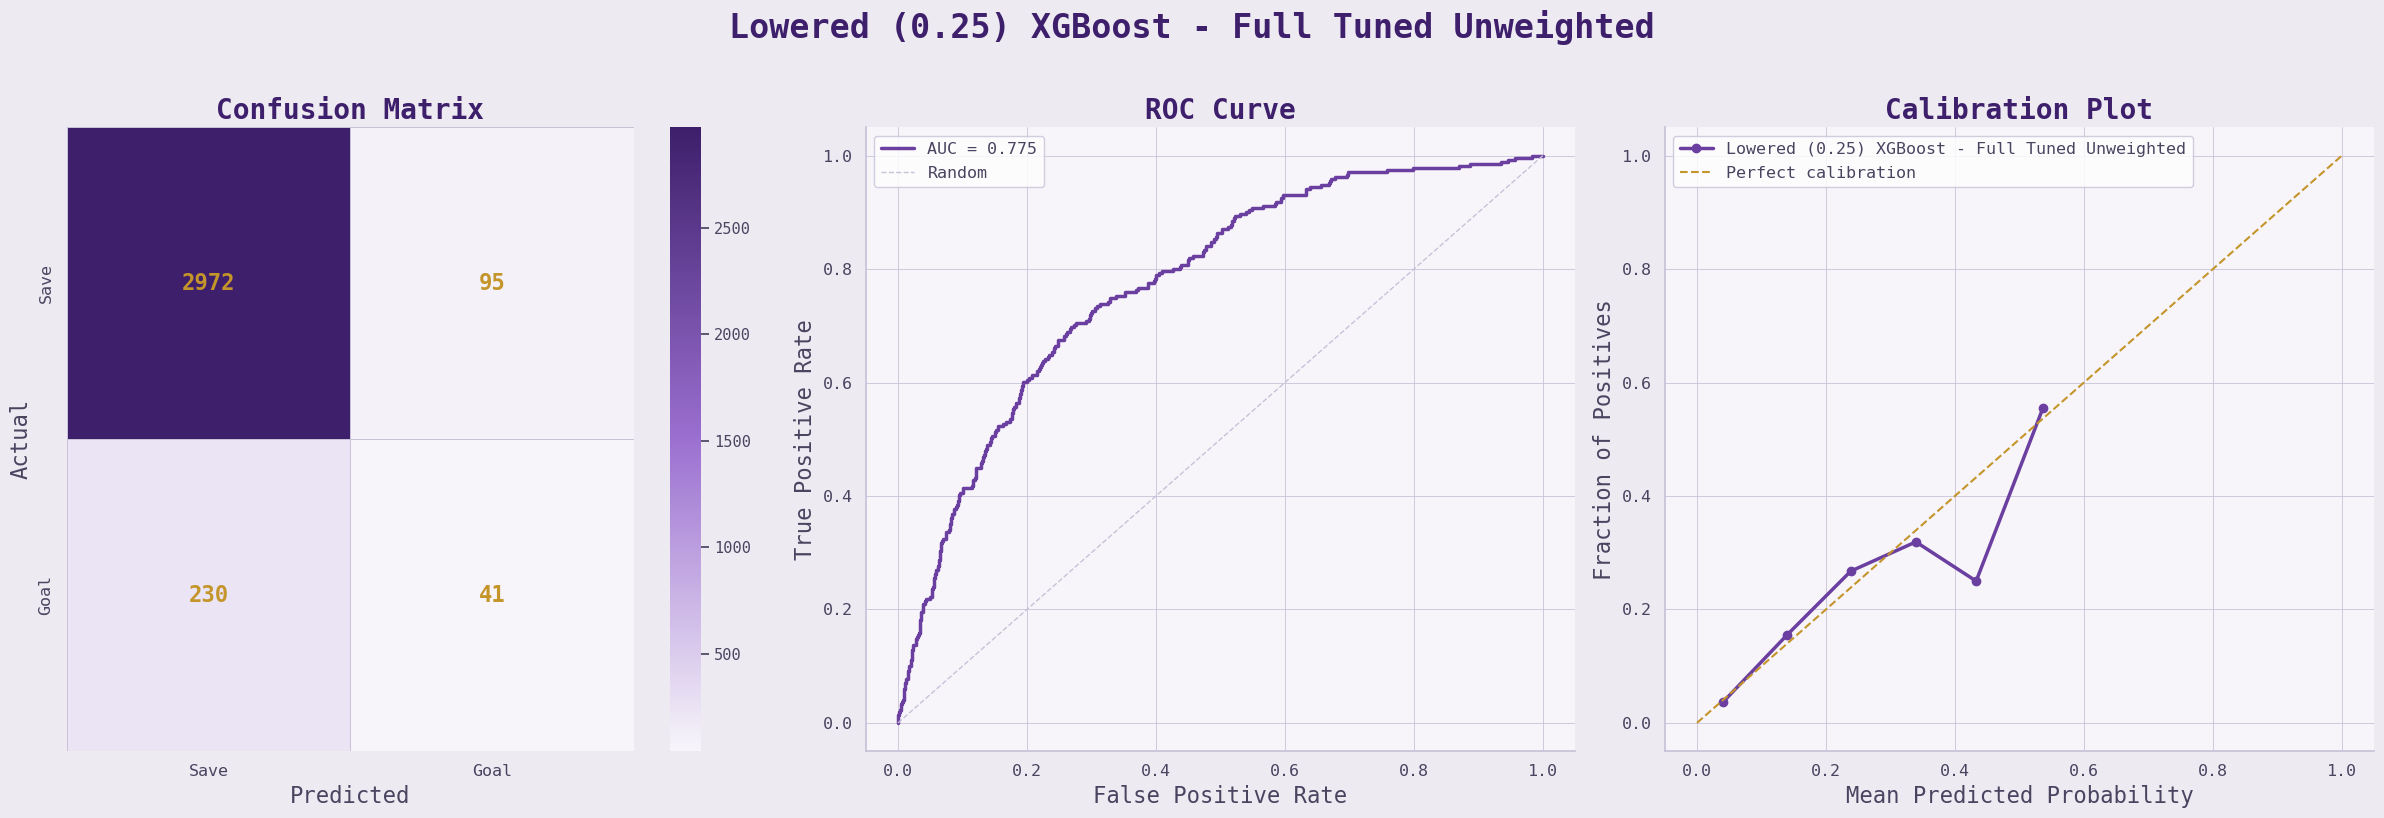

In [70]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 200,
                    max_depth = 3,
                    learning_rate = 0.05,
                    subsample = 0.6)

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "Lowered (0.25) XGBoost - Full Tuned Unweighted", threshold = 0.25)


  Lowered (0.25) XGBoost - Full Tuned Weighted
  Baseline (always predict save): 91.87%
  Accuracy:                       58.0%
  AUC:                            0.772
  Log Loss:                       0.376
  Avg Precision (PR-AUC):         0.229

              precision    recall  f1-score   support

        Save       0.97      0.56      0.71      3067
        Goal       0.14      0.80      0.24       271

    accuracy                           0.58      3338
   macro avg       0.55      0.68      0.47      3338
weighted avg       0.90      0.58      0.67      3338



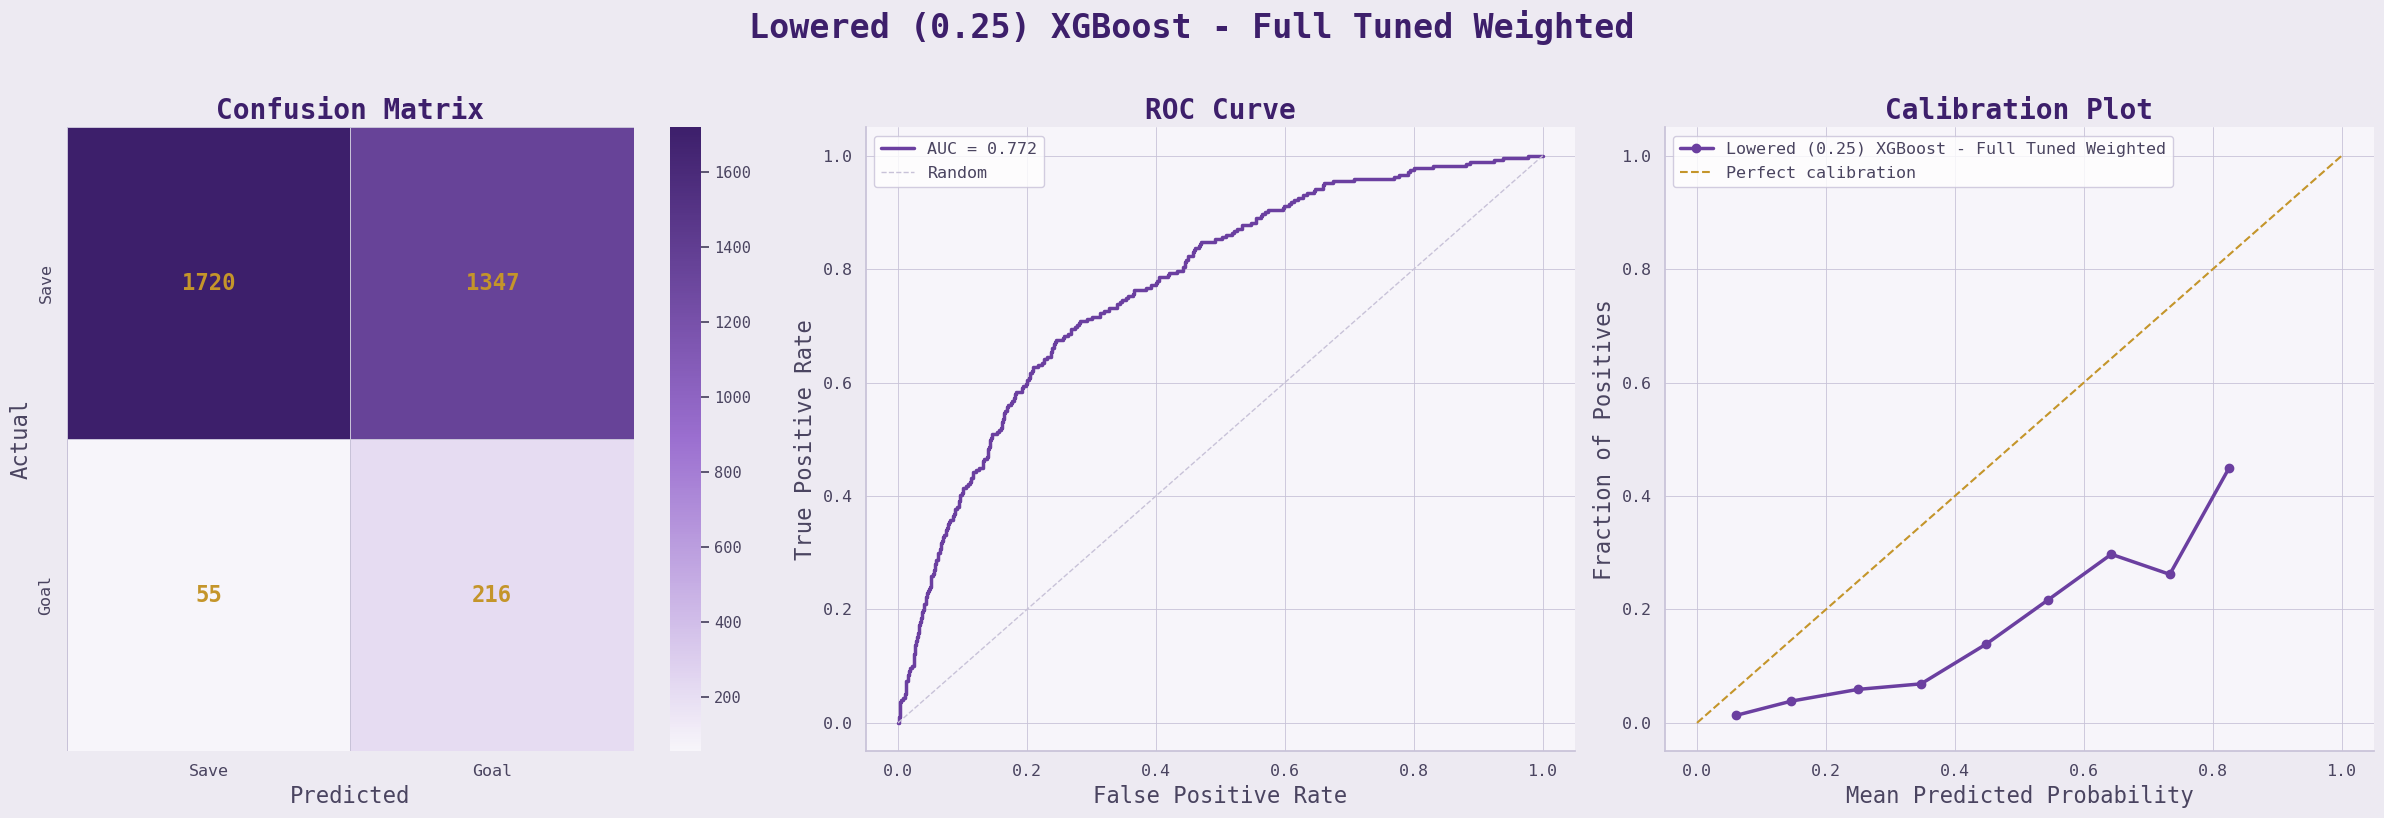

In [71]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 200,
                    max_depth = 3,
                    learning_rate = 0.05,
                    scale_pos_weight = weight/2,
                    subsample = 0.6)

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "Lowered (0.25) XGBoost - Full Tuned Weighted", threshold = 0.25)


  Lowered (0.25) XGBoost - Selected Tuned Unweighted
  Baseline (always predict save): 91.87%
  Accuracy:                       90.8%
  AUC:                            0.719
  Log Loss:                       0.259
  Avg Precision (PR-AUC):         0.185

              precision    recall  f1-score   support

        Save       0.92      0.98      0.95      3067
        Goal       0.26      0.07      0.11       271

    accuracy                           0.91      3338
   macro avg       0.59      0.53      0.53      3338
weighted avg       0.87      0.91      0.88      3338



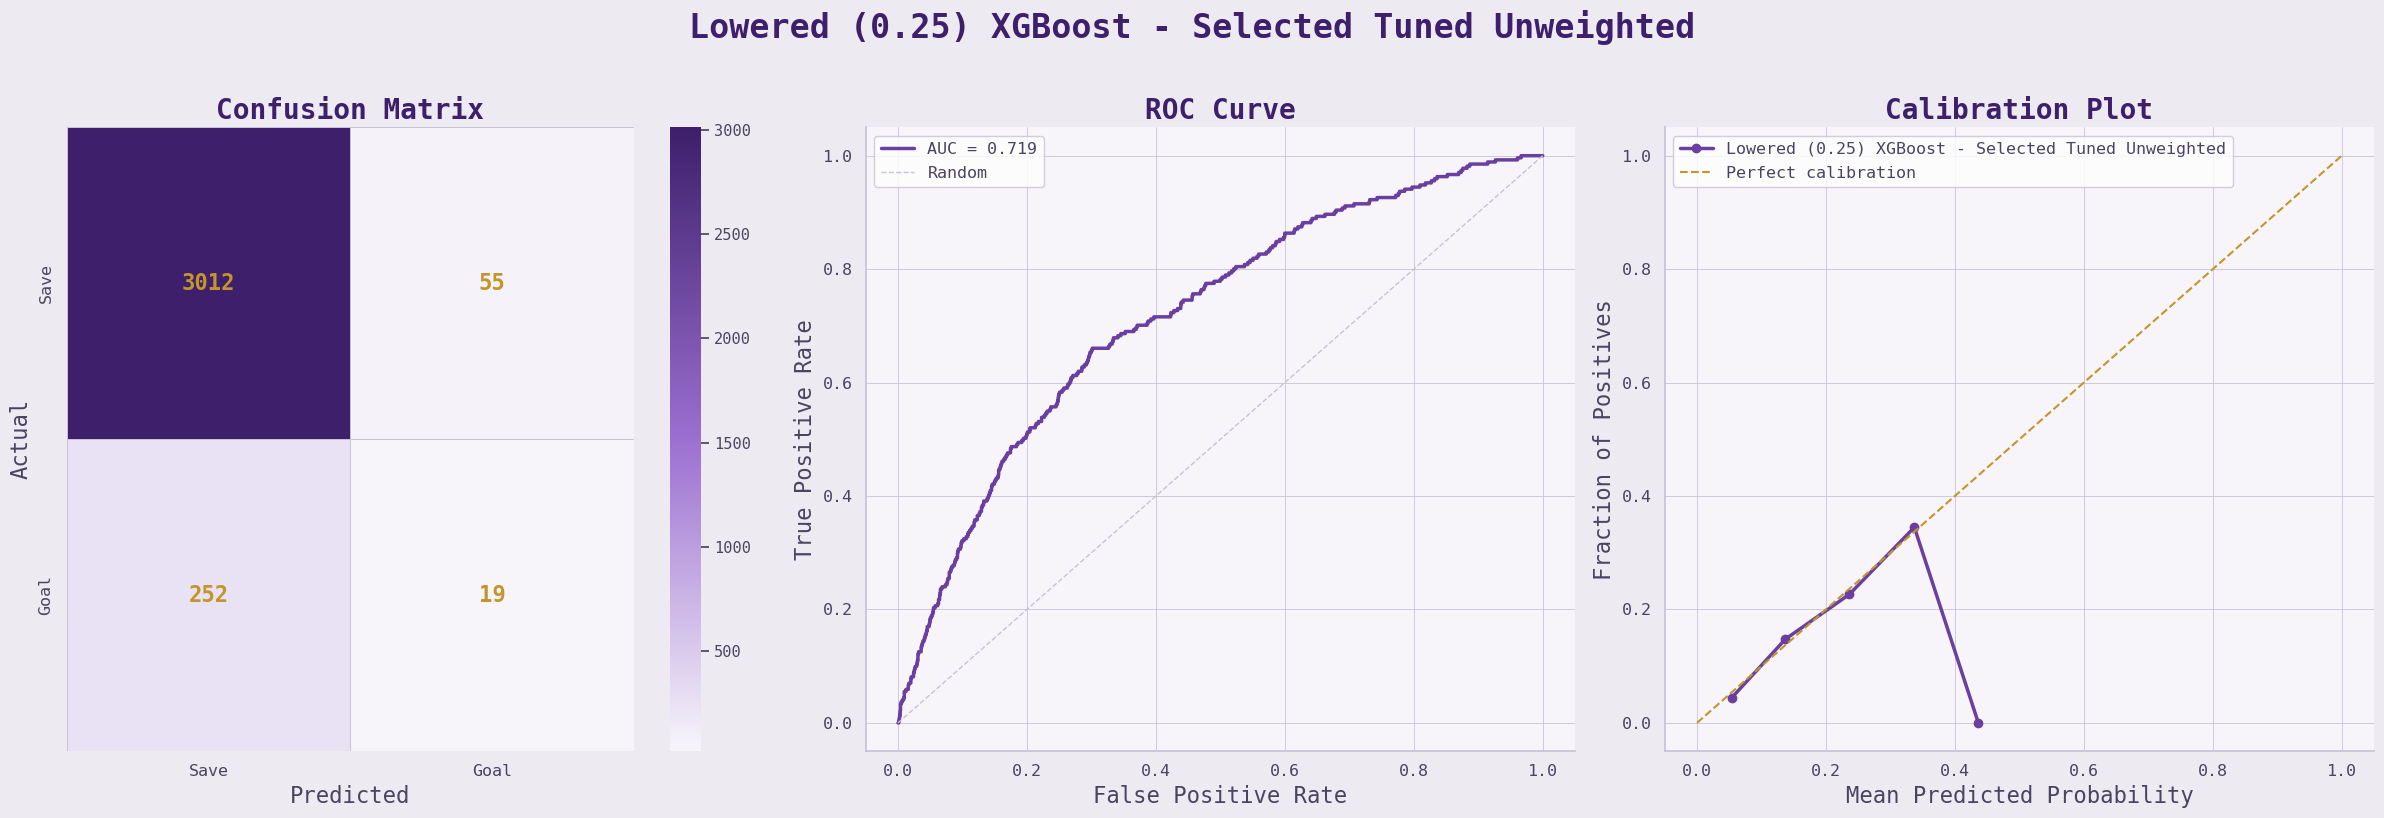

In [72]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 300,
                    max_depth = 3,
                    learning_rate = 0.01,
                    subsample = 0.5)

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "Lowered (0.25) XGBoost - Selected Tuned Unweighted", threshold=0.25)


  Lowered (0.25) XGBoost - Selected Tuned Weighted
  Baseline (always predict save): 91.87%
  Accuracy:                       48.41%
  AUC:                            0.72
  Log Loss:                       0.413
  Avg Precision (PR-AUC):         0.183

              precision    recall  f1-score   support

        Save       0.97      0.45      0.62      3067
        Goal       0.12      0.82      0.20       271

    accuracy                           0.48      3338
   macro avg       0.54      0.64      0.41      3338
weighted avg       0.90      0.48      0.58      3338



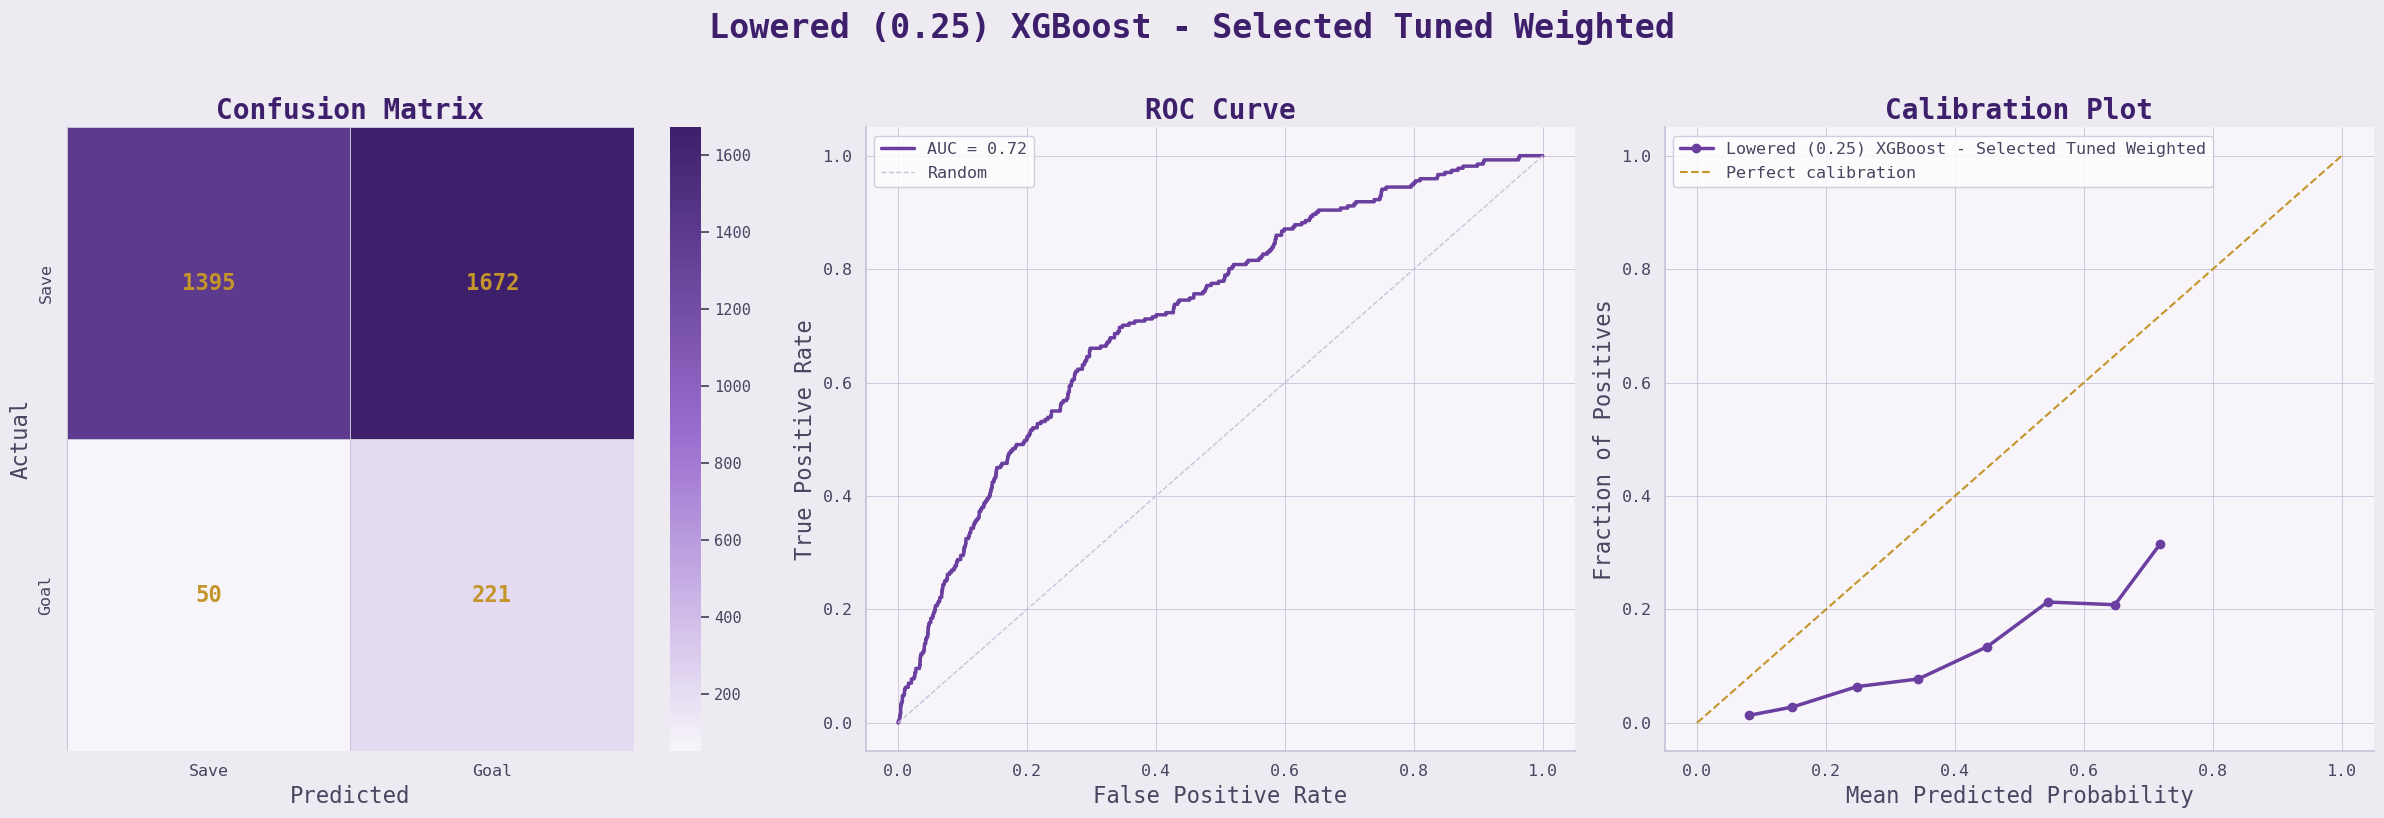

In [73]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 300,
                    max_depth = 3,
                    learning_rate = 0.01,
                    scale_pos_weight = weight/2,
                    subsample = 0.5)

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "Lowered (0.25) XGBoost - Selected Tuned Weighted", threshold=0.25)

In [74]:
pd.DataFrame(eval_list).sort_values(['auc', 'accuracy'], ascending = [False, False])

model  accuracy     auc  \
33                    XGBoost - Full Tuned Unweighted    0.9191  0.7754   
37     Lowered (0.25) XGBoost - Full Tuned Unweighted    0.9026  0.7754   
20            Log Reg C 500 — Full Set Standard Scale    0.9188  0.7747   
21  Lowered (0.25) Log Reg C 500 — Full Set Standa...    0.9005  0.7747   
24  Lowered (0.25) Log Reg C 500 — Full Set Standa...    0.9005  0.7747   
2                   Log Reg — Full Set Standard Scale    0.9191  0.7743   
14   Lowered (0.25) Log Reg — Full Set Standard Scale    0.9008  0.7743   
15    Lowered (0.1) Log Reg — Full Set Standard Scale    0.7349  0.7743   
6          Balanced Log Reg — Full Set Standard Scale    0.6705  0.7734   
35                      XGBoost - Full Tuned Weighted    0.8484  0.7723   
38       Lowered (0.25) XGBoost - Full Tuned Weighted    0.5800  0.7723   
7            Balanced Log Reg — Full Set MinMax Scale    0.6735  0.7721   
11              SMOTE Log Reg — Full Set MinMax Scale    0.6762  0.7717   
10            SMOTE Log Reg — Full Set Standard Scale    0.6765  0.7714   
3                     Log Reg - Full Set MinMax Scale    0.9185  0.7709   
0                            Base Logistic Regression    0.9185  0.7485   
25                                     XGBoost - Base    0.9134  0.7341   
26                                 XGBoost - Weighted    0.8583  0.7319   
5                     Selected Log Reg - MinMax Scale    0.9188  0.7229   
18   Lowered (0.25) Log Reg — Selected Set MinMax ...    0.9059  0.7229   
22       Log Reg C 1000 — Selected Set Standard Scale    0.9188  0.7226   
4                   Selected Log Reg - Standard Scale    0.9185  0.7226   
16   Lowered (0.25) Log Reg — Selected Set Standar...    0.9056  0.7226   
23  Lowered (0.25) Log Reg C 1000 — Selected Set S...    0.9050  0.7226   
17   Lowered (0.1) Log Reg — Selected Set Standard...    0.7163  0.7226   
19   Lowered (0.1) Log Reg — Selected Set Standard...    0.7163  0.7226   
27                         XGBoost - Weighted Doubled    0.8319  0.7210   
9        Balanced Log Reg — Selected Set MinMax Scale    0.6300  0.7209   
8      Balanced Log Reg — Selected Set Standard Scale    0.6318  0.7208   
12        SMOTE Log Reg — Selected Set Standard Scale    0.6315  0.7207   
13        SMOTE Log Reg — Selected Set Standard Scale    0.6306  0.7204   
36                  XGBoost - Selected Tuned Weighted    0.8622  0.7201   
40   Lowered (0.25) XGBoost - Selected Tuned Weighted    0.4841  0.7201   
28                          XGBoost - Weighted Halved    0.8844  0.7194   
34                XGBoost - Selected Tuned Unweighted    0.9188  0.7188   
39  Lowered (0.25) XGBoost - Selected Tuned Unweig...    0.9080  0.7188   
1                        Selected Logistic Regression    0.9188  0.7152   
29                            XGBoost - Selected Data    0.9134  0.6776   
32                 XGBoost - Selected Weighted Halved    0.8571  0.6768   
30                        XGBoost - Selected Weighted    0.7978  0.6596   
31                XGBoost - Selected Weighted Doubled    0.7187  0.6534   

    log_loss  avg_prec  
33    0.2444    0.2355  
37    0.2444    0.2355  
20    0.2442    0.2415  
21    0.2442    0.2415  
24    0.2442    0.2415  
2     0.2443    0.2418  
14    0.2443    0.2418  
15    0.2443    0.2418  
6     0.5755    0.2361  
35    0.3760    0.2286  
38    0.3760    0.2286  
7     0.5770    0.2349  
11    0.5741    0.2313  
10    0.5712    0.2342  
3     0.2454    0.2372  
0     0.2521    0.1994  
25    0.2791    0.1851  
26    0.3329    0.1852  
5     0.2575    0.1948  
18    0.2575    0.1948  
22    0.2576    0.1951  
4     0.2576    0.1952  
16    0.2576    0.1952  
23    0.2576    0.1951  
17    0.2576    0.1952  
19    0.2576    0.1952  
27    0.3834    0.1714  
9     0.6216    0.1947  
8     0.6218    0.1947  
12    0.6203    0.1940  
13    0.6205    0.1937  
36    0.4130    0.1827  
40    0.4130    0.1827  
28    0.3026    0.1842  
34    0.2592    0.1848

### XG Boost Summary

The best performing model was Lowered (0.25) XGBoost - Full Tuned Unweighted.  It had an **AUC of 0.7754**, and the lowered threshold allowed it to make 136 goal predicitons with 30% precision.

The model that tuned to the full dataset but was weighted was one of the highest performing models with an **AUC of 0.7723**.  Even though the accuracy dropped to 84.84%, it made nearly 500 goal predictions.  Even though the overall accuracy, precision and recall were not good, this model provided the best balance between all of the evaluation factors while still scoring well on AUC.  I will take a closer look at this model to see how it made those predictions.


  Lowered (0.25) XGBoost - Full Tuned Unweighted
  Baseline (always predict save): 91.87%
  Accuracy:                       90.26%
  AUC:                            0.775
  Log Loss:                       0.244
  Avg Precision (PR-AUC):         0.236

              precision    recall  f1-score   support

        Save       0.93      0.97      0.95      3067
        Goal       0.30      0.15      0.20       271

    accuracy                           0.90      3338
   macro avg       0.61      0.56      0.57      3338
weighted avg       0.88      0.90      0.89      3338



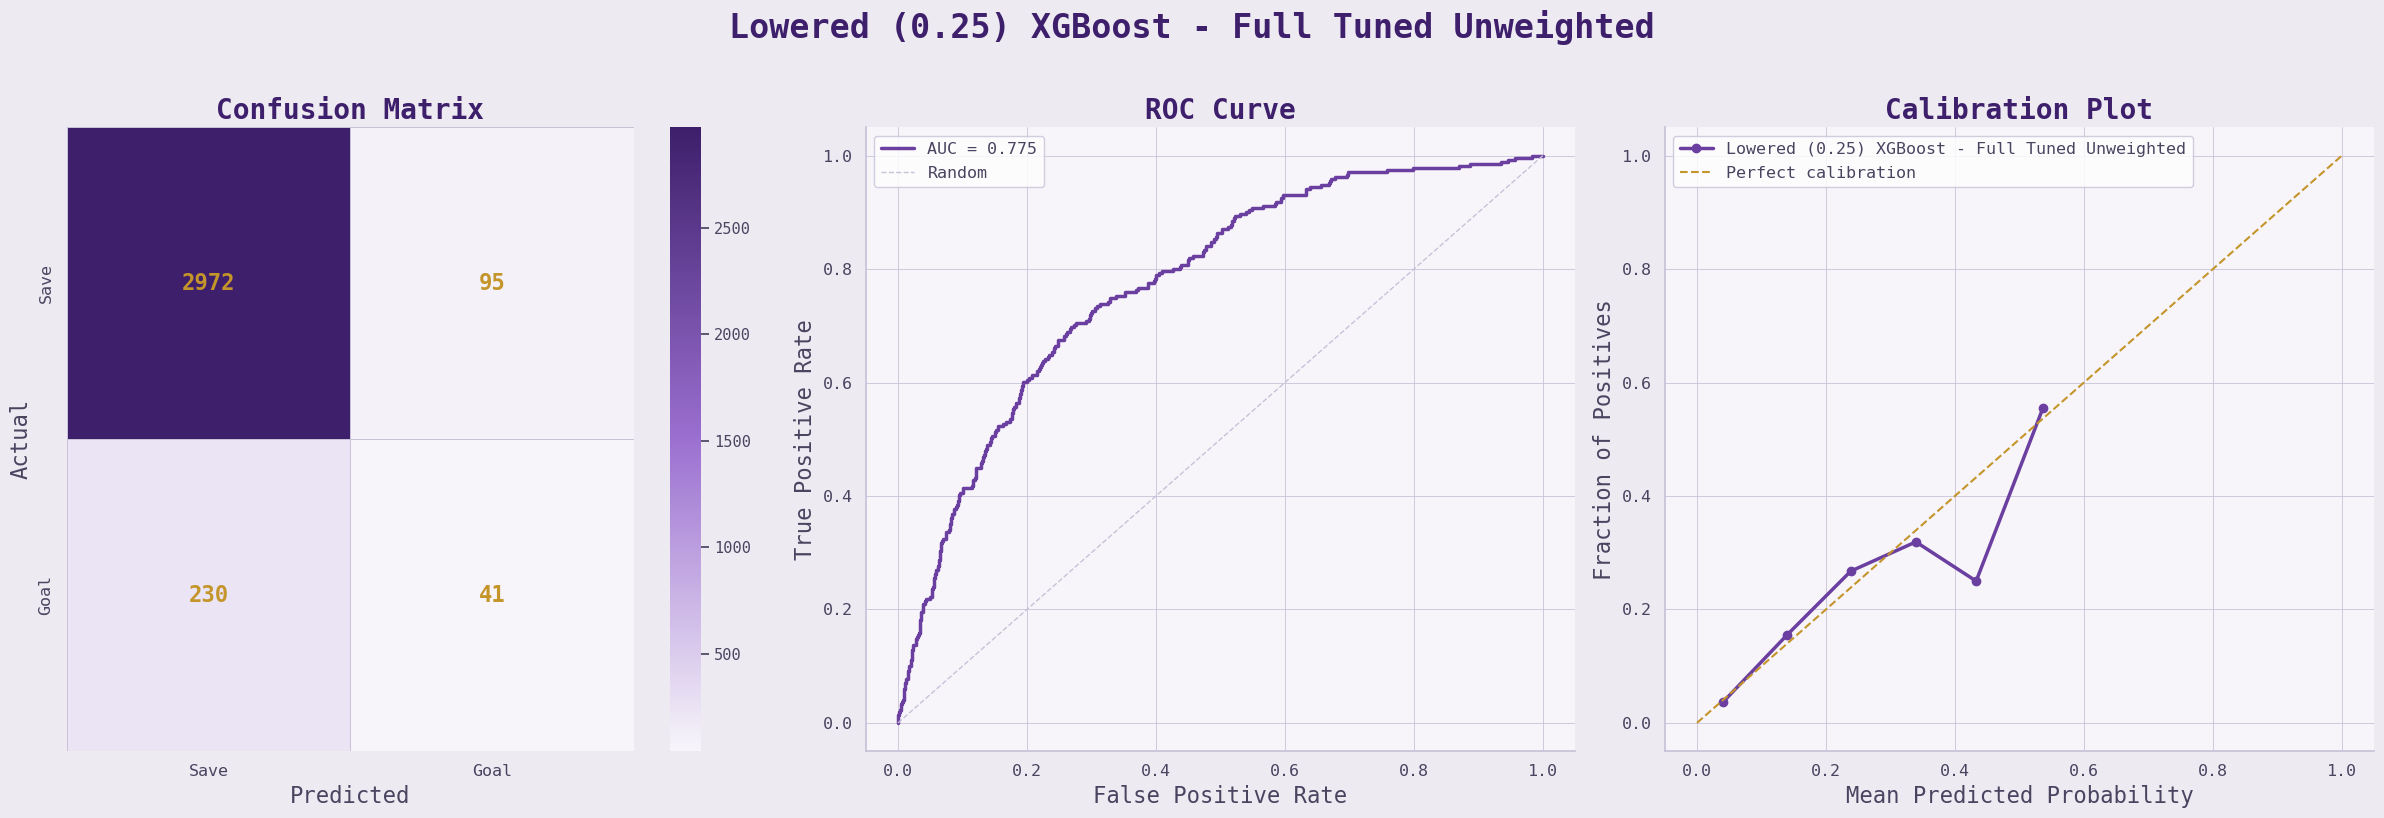

In [75]:
# Re-running the best XGBoost model in order to look closer at the Importance of the features
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 200,
                    max_depth = 3,
                    learning_rate = 0.05,
                    subsample = 0.6)

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "Lowered (0.25) XGBoost - Full Tuned Unweighted", threshold = 0.25)

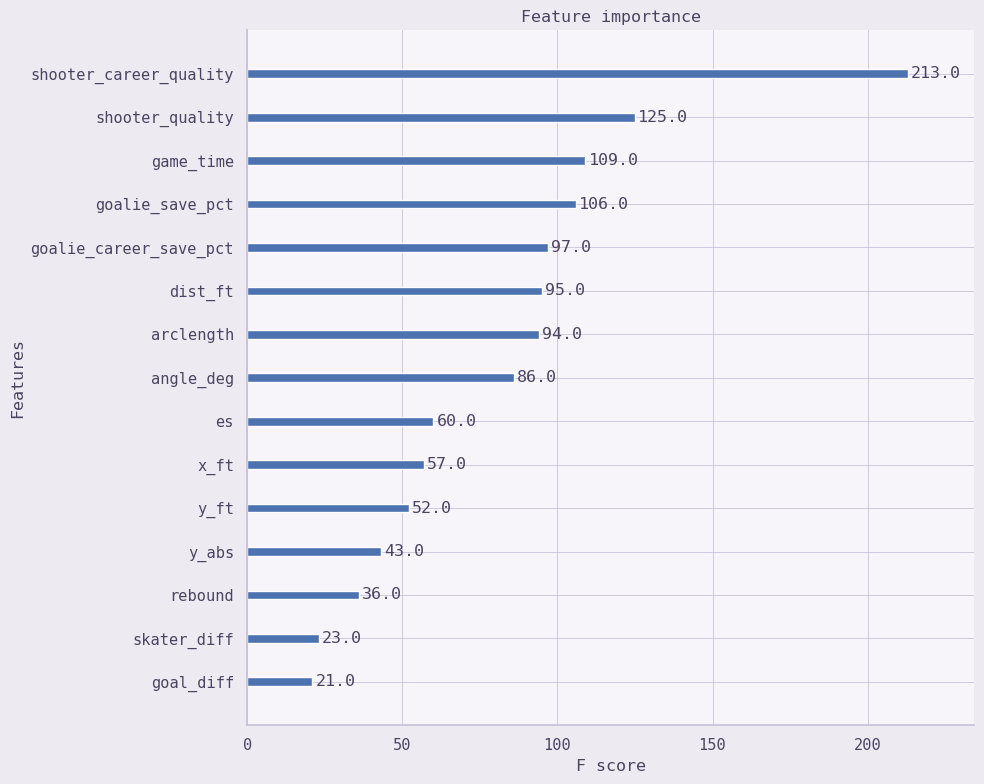

In [76]:
fig, ax = plt.subplots(figsize=(10, 8), facecolor=PWHL["bg"])
plot_importance(xgb, ax=ax, max_num_features=15)
plt.tight_layout()
display(fig)
plt.close(fig)

Unfortunately, this put a high degree of value on BOTH the `shooter_career_quality` and `shooter_quality`, as well as `goalie_career_save_pct` and `goalie_save_pct`, doubling up on features that are highly related.  As well, `arc_length`and `dist_ft` both seem to be important with known multi-colinearity issues as well.

While these models highlight features that are important, there are clear issues in how the features relate to each other, as well as the need to have models fit to specific strength states.

<a id = 'summary'></a>

## 4. Modelling Part 1 Summary

The end result of this modelling was that there is not a model that I would be comfortable with building out a reliable xG model with.  A number of issues became apparent working through this step in the modelling:

1. Multicolinearity issues between Skater and Goalie Quality features
2. Multicolinearity issues between `x_ft`, `dist_ft` and `arc_length` features.
3. The impact of strength states (Even Strength vs Power Play vs Shorthanded) on the model
4. Challenge of getting reliable goal predictions without a significant drop in overall accuracy.
5. Potential of improperly classified data ('default' `shot_type`) impacting predictions.

With an adjusted approach, all of these can be addressed.  In the next phase of modelling, I will filter the data to include only Even Strength shots, and none that are labeled as 'default'.  Also, I will drop features that have significant multi-colinearity, such as `arc_length`, `shooter_quality` and `goalie_save_pct`.  I will also drop features that, though not measured in this modelling, logically could be issues (ie. `period` vs `game_time`)

The best performing model here had an **AUC of 0.7754**.  I hope that by fixing these issues that the score will improve and result in a more useful model.